# Imports

In [2]:
import gzip
import pickle

import platform 
from random import choice
import scipy.stats
import sys
import gi
from gi.repository import Gtk, Gdk
import graph_tool.all as gt
import graph_tool as graph_tool
import pandas as pd
import numpy as np
import os
# move to repo root folder
os.chdir('/data_clear/alberto/projects/decentralization/decentralization/')
# os.chdir('../')
import sys
sys.path.insert(0, os.path.join(os.getcwd(),"utils"))
from hsbm import sbmmultilayer 
# from hsbm.utils.nmi import * 
from hsbm.utils.doc_clustering import construct_nmi_matrix # *
# from hsbm_creation import *
# from hsbm_fit import *
# from hsbm_partitions import *

import time
from tqdm.notebook import tqdm

from sklearn.feature_extraction import text
from nltk.stem import  WordNetLemmatizer
import re

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from datetime import datetime

import random
import seaborn as sn

import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
from IPython.display import display

In [724]:
# DEFAULT PARAMETERS IN THE FIGURES TO BE ADJUSTED!!!!

plt.style.use("default")

height_fig = 5
width_fig = 10

params_default = {
    # no upper and right axes
    'axes.spines.right' : False,
    'axes.spines.top' : False,
    # no frame around the legend
    "legend.frameon" : False,

    # dimensions of figures and labels
    # we will play with these once we see how they are rendered in the latex
    'figure.figsize' : (width_fig, height_fig),

    'axes.labelsize' : 22,
    'axes.titlesize' : 25,
    'xtick.labelsize' : 18,
    'ytick.labelsize' : 18,
    'legend.fontsize' : 16,
    
    
    # no grids (?)
    'axes.grid' : False,

    # the default color(s) for lines in the plots: in order if multiple lines. We can change them or add colors if needed
#     'axes.prop_cycle' : mpl.cycler(color=["#00008B", "#BF0000", "#006400"]), 

    # default quality of the plot. Not too high but neither too low
    "savefig.dpi" : 300,
    "savefig.bbox" : 'tight', 
    
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',
    
    
}


plt.rcParams.update(params_default)

In [4]:
class print_color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [5]:
def split_words(string):
    words = []
    word_tmp = ""
    for letter in string:
        if letter in "QWERTYUIOPASDFGHJKLZXCVBNMqwertyuiopasdfghjklzxcvbnm":
            word_tmp += letter
        else:
            words.append(word_tmp)
            words.append(letter)
            word_tmp = ""
    if letter in "QWERTYUIOPASDFGHJKLZXCVBNMqwertyuiopasdfghjklzxcvbnm":
        words.append(word_tmp)
    return words

# Loading data

In [6]:
corpus_version = '2022-01-01' # '2021-09-01' '2022-01-01'
all_dataset_path = f"data/{corpus_version}/"
dataset_path = f"data/{corpus_version}/decentralization/"
paper_figures_folder = f"figures/"

In [7]:
filter_label = '' # if you want a specific label to do some testing
min_inCitations = 0
min_word_occurences = 5
use_titles = True

In [8]:
results_folder = os.path.join(dataset_path,f'{min_inCitations}_min_inCitations_{min_word_occurences}_min_word_occurrences/')

chosen_text_attribute = 'paperAbstract'
if use_titles:
    # USE TITLES TEXT INSTEAD OF ABSTRACTS
    print('Using titles text instead of abstracts!', flush=True)
    chosen_text_attribute = 'title'
    results_folder = results_folder[:-1] + '_titles/'
prep_results_folder = results_folder

# results_folder += 'ID_1_no_iterMC_5000/'
results_folder += 'consensus_all_100_iter/'

Using titles text instead of abstracts!


## all_docs

In [9]:
print('Loading data')
with gzip.open(f"{dataset_path}papers_dict.pkl.gz", "rb") as fp:
    all_docs_dict = pickle.load(fp)

Loading data


In [10]:
all_docs_dict['a00017fee08f765c31ad7d80d87ddf0d88e2f352'].keys()

dict_keys(['id', 'title', 'paperAbstract', 'authors', 'inCitations', 'outCitations', 'year', 's2Url', 'sources', 'pdfUrls', 'venue', 'journalName', 'journalVolume', 'journalPages', 'doi', 'doiUrl', 'pmid', 'fieldsOfStudy', 'magId', 's2PdfUrl', 'entities'])

## tokenized abstracts

In [11]:
with gzip.open(f"{prep_results_folder}tokenized_texts_dict_all.pkl.gz", "rb") as fp:
    tokenized_texts_dict = pickle.load(fp)

# Fig 1 - papers in year

In [12]:
with gzip.open(all_dataset_path+"no_papers_in_fields_by_year.pkl.gz","rb") as fp:
    papers_per_year_per_field = pickle.load(fp)
    
with gzip.open(all_dataset_path+"no_authors_in_fields_by_year.pkl.gz","rb") as fp:
    authors_per_year_per_field = pickle.load(fp)
    
    
try:
    with gzip.open(all_dataset_path+"no_authors_by_year.pkl.gz","rb") as fp:
        no_authors_per_year = pickle.load(fp)
except Exception as e:
    print(e)
    with gzip.open(all_dataset_path+"sets_authors_in_fields_by_year.pkl.gz","rb") as fp:
        set_authors_per_year_per_field = pickle.load(fp)
     
    no_authors_per_year = {}
    for year in set_authors_per_year_per_field.keys():
        no_authors_per_year[year] = len(set().union(*list(set_authors_per_year_per_field[year].values())))
                                        
    with gzip.open(all_dataset_path+"no_authors_by_year.pkl.gz","wb") as fp:
        pickle.dump(no_authors_per_year,fp)  

In [13]:
years = sorted([x for x in papers_per_year_per_field.keys() if x is not None and x > 1500])

set_authors_per_year_decentralization = {y:set() for y in years}
for paper in all_docs_dict.values():
    if paper['year'] is not None:
        set_authors_per_year_decentralization[paper['year']].update([aut['ids'][0] for aut in paper['authors'] if paper['authors'] is not None and len(paper['authors'])>0 and len(aut['ids'])>0])
        
no_authors_per_year_decentralization = {y:len(set_authors_per_year_decentralization[y]) for y in years}

/home/enterprise.internal.city.ac.uk/aczy350/anaconda3/envs/gt/lib/python3.9/site-packages/pandas/core/indexes/base.py:3706: RuntimeWarning: '<' not supported between instances of 'NoneType' and 'int', sort order is undefined for incomparable objects
  join_index = self.union(other)


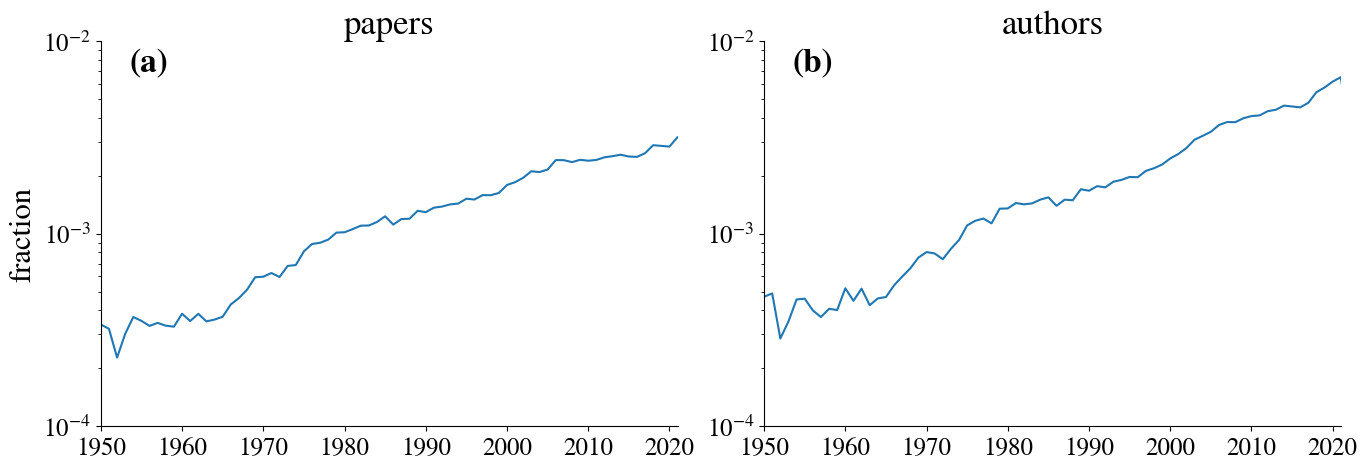

In [192]:
xlims = (1950,2021)
fs = 24
y_small = .92
x_small = 0.05

upper_limit = 10*10**(-3)
fig,axes = plt.subplots(1,2,figsize = (16,5),gridspec_kw={'wspace':0.15})

ax = axes[0]
# ax.set_title("Fraction of decentralization papers in the full academic literature")

dec_papers = pd.Series([x['year'] if 'year' in x else None for x in all_docs_dict.values()]).explode().value_counts().sort_index()

all_papers = pd.Series(index=years,data=[sum(list(papers_per_year_per_field[x].values())) for x in years])

frac_papers = dec_papers.align(all_papers,fill_value=0)[0]/dec_papers.align(all_papers,fill_value=0)[1]
ax.plot(frac_papers.index,frac_papers.values)#, color = 'red')

ax.set_xlim(xlims)
ax.set_xticks(range(1950,2022,10))
ax.set_yscale("log")
ax.set_ylim((10**(-4),upper_limit))
ax.set_ylabel("fraction")
ax.set_title("papers")

# ax.axvline(2016,linestyle='--',color='grey',lw=2, label='New Growth')
# ax.axvline(1963,linestyle='--',color='green',lw=2, label='Start Growth')
# ax.axvline(2008,linestyle='--',color='black',lw=2, label='Bitcoin whitepaper')# ax.legend()

ax.text(s="(a)", y=y_small, fontsize=fs, x = x_small, transform=ax.transAxes, fontweight='bold')
# ax.legend()





ax = axes[1]
# ax.set_title("Fraction of decentralization papers in the full academic literature")
dec_authors = pd.Series(no_authors_per_year_decentralization).sort_index()
all_authors = pd.Series(no_authors_per_year).sort_index()


frac_authors = dec_authors.align(all_authors,fill_value=0)[0]/dec_authors.align(all_authors,fill_value=0)[1]
ax.plot(frac_authors.index,frac_authors.values)#, color = 'red')

ax.set_xlim(xlims)
ax.set_yscale("log")
ax.set_ylim((10**(-4),upper_limit))
# ax.set_ylabel("fraction")
ax.set_xticks(range(1950,2022,10))
ax.set_title("authors")

ax.text(s="(b)", y=y_small, fontsize=fs, x = x_small, transform=ax.transAxes, fontweight='bold')



fig.savefig(f"{paper_figures_folder}figure_1.pdf")

# hsbm results loading

- texts: list of tokenized abstracts
- titles: list of unique paperIds


In [14]:
filter_label = ""# "_filtered_%dcits"%(min_citations)
print(filter_label)

In [15]:
hyperlink_g = gt.load_graph(f"{prep_results_folder}gt_network{filter_label}.gt")
num_vertices = hyperlink_g.num_vertices()
num_edges = hyperlink_g.num_edges()
print(num_vertices, num_edges)

181605 590215


In [16]:
label = hyperlink_g.vp["label"]
name = hyperlink_g.vp["name"] # every vertex has a name already associated to it!

# Retrieve true partition of graph
true_partition = list(hyperlink_g.vp.label)    
# Retrieve ordering of articles
article_names = list(hyperlink_g.vp.name)

In [17]:
try:
    with gzip.open(f"{prep_results_folder}IDs_texts_and_edited_text_papers_with_abstract{filter_label}.pkl.gz", "rb") as fp:
        IDs,texts,edited_text = pickle.load(fp)
except:
    with gzip.open(f"{prep_results_folder}titles_texts_and_edited_text_papers_with_abstract{filter_label}.pkl.gz", "rb") as fp:
        IDs,texts,edited_text = pickle.load(fp)

## Retrieve partitions

Retrieve the partitions assigned to the document nodes by examining the highest non-trivial level of the hierarchical degree-corrected SBM.

In [18]:
with gzip.open(f"{results_folder}results_fit_greedy_partitions{filter_label}.pkl.gz","rb") as fp:
    hyperlink_text_hsbm_partitions, levels = pickle.load(fp)
    # Retrieve partitions assigned to documents in each run. Also save index of highest non-trivial level.

In [19]:
print(levels)

[5, 5, 5, 5, 6, 5, 6, 5, 4, 5, 5, 7, 5, 5, 6, 5, 5, 7, 5, 5, 6, 5, 6, 5, 6, 5, 6, 7, 5, 5, 6, 5, 5, 6, 5, 6, 6, 5, 6, 8, 5, 5, 6, 6, 5, 6, 5, 6, 5, 5, 5, 7, 6, 5, 6, 5, 4, 6, 5, 5, 6, 5, 6, 6, 5, 5, 6, 5, 5, 5, 5, 6, 6, 4, 6, 5, 5, 6, 4, 7, 5, 5, 5, 7, 6, 4, 5, 7, 5, 7, 6, 5, 6, 6, 5, 5, 5, 7, 7, 7]


## Compute centralities

In [410]:
# Created in main script
with gzip.open(f'{prep_results_folder}hyperlink_g_centralities{filter_label}.pkl.gz','rb') as fp:
    centralities = pickle.load(fp)

## Consensus Partition

Compute the consensus partition assignment to document nodes over all the runs.

In [21]:
print("loading")
with gzip.open(f"{results_folder}results_fit_greedy_partitions_docs_all{filter_label}.pkl.gz","rb") as fp:
    hyperlink_text_hsbm_partitions_by_level,duration = pickle.load(fp)
# with gzip.open(f"{results_folder}results_fit_greedy_partitions_docs_all_info{filter_label}.pkl.gz","rb") as fp:
#     hyperlink_text_hsbm_partitions_by_level_info,duration = pickle.load(fp)

loading


In [22]:
with gzip.open(f"{results_folder}/results_fit_greedy_partitions_consensus_all{filter_label}.pkl.gz","rb") as fp:
    h_t_doc_consensus_by_level, h_t_word_consensus_by_level, h_t_consensus_summary_by_level = pickle.load(fp)


In [23]:
ordered_paper_ids = list(hyperlink_g.vp['name'])

In [24]:
# WORKS WITH MORE THAN 1 ITERATION (in teoria va bene sempre...)
name2partition_by_level = {max(list(h_t_doc_consensus_by_level.keys()))+1 : {x:0 for x in ordered_paper_ids}}

for level in h_t_doc_consensus_by_level.keys():
    name2partition_by_level[level] = {}
    for i,paper_id in enumerate(list(hyperlink_g.vp["name"])):
        name2partition_by_level[level][paper_id] = h_t_doc_consensus_by_level[level][i]

In [26]:
doc_partition_remapping_by_level = {}
doc_partition_remapping_by_level_inverse = {}
for level in name2partition_by_level:
    if level != max(list(h_t_doc_consensus_by_level.keys()))+1:
        # level = 3
        doc_partition_remapping_by_level[level] = {}
        doc_partition_remapping_by_level_inverse[level] = {}
        lista1 = []
        for paper in ordered_paper_ids:
            lista1.append(name2partition_by_level[level][paper])
    #     lista2 = hyperlink_text_consensus_partitions_by_level[level]
        lista2 = h_t_doc_consensus_by_level[level]
    #     print(set(list(zip(lista1,lista2))))
        for part1, part2 in set(list(zip(lista1,lista2))):
            if part1 in doc_partition_remapping_by_level[level]:
                print("THERE ARE MULTIPLE INSTANCES... ERROR")
                break
            else:
                doc_partition_remapping_by_level[level][part1] = part2  
                doc_partition_remapping_by_level_inverse[level][part2] = part1

## Topic Modelling

We now show how this framework tackles the problem of topic modelling simultaneously.

We can now retrieve the top 10 words associated to topics associated to consensus partition.topics_df_by_level

In [31]:
with gzip.open(f"{results_folder}results_fit_greedy_topic_frequency_all{filter_label}.pkl.gz","rb") as fp:
    topics_df_by_level,mixture_proportion_by_level, normalized_mixture_proportion_by_level, avg_topic_frequency_by_level = pickle.load(fp)

In [32]:
highest_non_trivial_level = sorted(topics_df_by_level.keys())[-1]
highest_non_trivial_level

6

## Recover Hierarchy

In [35]:
with gzip.open(f"{results_folder}results_fit_greedy_topic_hierarchy_all{filter_label}.pkl.gz","rb") as fp:
    hierarchy_docs,hierarchy_words = pickle.load(fp)

# Functions

In [38]:
paper2fields = {}
paper2year = {}
for paper_id, paper in all_docs_dict.items():
    paper2year[paper_id] = paper["year"] if "year" in paper else None
    paper2fields[paper_id] = paper["fieldsOfStudy"] if "fieldsOfStudy" in paper and paper["fieldsOfStudy"] is not None else []

In [39]:
def get_most_represented_topic(level_partition, partition, level_topic):
    if level_topic >= max(list(hierarchy_words.keys())):
        return 0
    else:
        p = partition
        p_remapped = doc_partition_remapping_by_level[level_partition][p]
    #     print(print_color.UNDERLINE + print_color.BOLD + print_color.RED + "PARTITION %d\n"%(p_remapped) + print_color.END)
        tmp = pd.Series({key:value for key,value in normalized_mixture_proportion_by_level_partition_by_level_topics[level_partition][level_topic]["doc_group %d"%p_remapped].items() if topics_df_by_level[level_topic][int(key[6:])].notna().sum()>0}).sort_values(ascending=False)

        return int(tmp.index[0][6:])

In [40]:
def name_node(level, index, list_labels = [], num_spaces = 200):
    if len(list_labels) == 0:
        return f"{level}_{index}"
    else:
        string = f"" # f"{level}_{index}"
        for _ in list_labels:
            string += "\n" + " "*num_spaces + "%s"%_ + " "*num_spaces
        return string

In [41]:
def topic_mixture_proportion(dict_groups,edited_text, document_partitions):

    topics = dict_groups.keys()
    partitions = np.unique(document_partitions)

    avg_topic_frequency = {}
    mixture_proportion = {}
    normalized_mixture_proportion = {}

    doc_texts = np.array(edited_text, dtype=object)

    n_i_t = {}

    topic_doc_group_words = {}

    for doc_group in partitions:
        topic_doc_group_words[doc_group] = set()
        for i,doc_group_membership in enumerate(document_partitions):
            if doc_group_membership != doc_group:
                continue
            topic_doc_group_words[doc_group] = topic_doc_group_words[doc_group].union(set(edited_text[i]))

    for topic in topics:
        topic_words = set([x[0] for x in dict_groups[topic]])
        n_i_t[topic] = {}

        for doc_group in partitions:
            n_i_t[topic][doc_group] = len(topic_words.intersection(topic_doc_group_words[doc_group]))

    for doc_group in partitions:
        mixture_proportion[f"doc_group {doc_group}"] = {}
        for topic in topics:
            mixture_proportion[f"doc_group {doc_group}"][f"topic {topic}"] = n_i_t[topic][doc_group] / np.sum([n_i_t[topic_j][doc_group] for topic_j in topics])

    S = np.sum([n_i_t[topic_j][doc_group] for doc_group in partitions for topic_j in topics])
    for topic in topics:
        avg_topic_frequency[f"topic {topic}"] = np.sum([n_i_t[topic][doc_group] for doc_group in partitions]) / S

    for doc_group in partitions:
        normalized_mixture_proportion[f"doc_group {doc_group}"] = {}
        for topic in topics:
            normalized_mixture_proportion[f"doc_group {doc_group}"][f"topic {topic}"] = ( mixture_proportion[f"doc_group {doc_group}"][f"topic {topic}"] - avg_topic_frequency[f"topic {topic}"] ) / avg_topic_frequency[f"topic {topic}"]

    return mixture_proportion, normalized_mixture_proportion, avg_topic_frequency

In [42]:
try:
    with gzip.open(f"{results_folder}results_fit_greedy_topic_frequency_all_by_level_partition_by_level_topics{filter_label}_all.pkl.gz","rb") as fp:
        topics_df_by_level,mixture_proportion_by_level_partition_by_level_topics, 
        normalized_mixture_proportion_by_level_partition_by_level_topics, 
        avg_topic_frequency_by_level_partition_by_level_topics = pickle.load(fp)
except FileNotFoundError:
    print("Not found")
    pass

In [43]:
def get_mixture_proportion(level_partition, partition, level_topic, topic):
    if level_topic >= max(list(hierarchy_words.keys())):
        m2 = min(hierarchy_words[max(list(hierarchy_words.keys()))][0])
        return np.max([get_mixture_proportion(level_partition, partition, max(list(hierarchy_words.keys()))-1, t-m2) for t in hierarchy_words[max(list(hierarchy_words.keys()))][0]])
    p_remapped = doc_partition_remapping_by_level[level_partition][partition]
#     m = min(hierarchy_words[level_topic])
    if topics_df_by_level[level_topic][topic].notna().sum() < 10:
        mixture_proportion = -1
    else:
        mixture_proportion = normalized_mixture_proportion_by_level_partition_by_level_topics[level_partition][level_topic][f"doc_group {p_remapped}"][f"topic {topic}"]
#     if mixture_proportion <= 0:
#         return 0.001
#     else:
#         return mixture_proportion
    return mixture_proportion

In [44]:
def create_hierarchy_network(level_partition, partition, top_level_topics, bottom_level_topics, 
                             max_num_topics_to_represent, num_words_to_represent, ax,
                             multiplicator_size_nodes=1, multiplicator_size_edges=1,
                             multiplicator_ypos=0.1,
                             fontsize = 10):
    if level_partition > max(list(hierarchy_words.keys())):
        level_partition = max(list(hierarchy_words.keys())) + 1
    cmap = matplotlib.cm.get_cmap('coolwarm')#('winter') coolwarm
#     cmap = matplotlib.colors.LinearSegmentedColormap.from_list('custom blue', ['red','gray'], N=256)
    # Let's create a tree undirected network
    G = nx.DiGraph()
    # this is just for drawing
    node_size = {} # key is node name
    edge_size = {} # key is tuple of source,target
    
    # let's find the root at the top_level of topics as the one with highest normalized mixture proportion with the chosen cluster
    root = get_most_represented_topic(level_partition, partition, top_level_topics)
#     print(root)
    root_name = name_node(top_level_topics,root)
    node_size[root_name] = get_mixture_proportion(level_partition, partition, top_level_topics, root) * multiplicator_size_nodes
    G.add_node(root_name)
    
            

    # this is just to remember which nodes have been selected at each level
    selected_nodes_by_level = {top_level_topics:[root]}
    
    # Let's add all the children until bottom_level from root, saving node_size of each node as the normalized mixture proportion
    # ACHTUNG: All names are of the type level_index, then they will be changed!
    for l in range(top_level_topics, bottom_level_topics,-1):
        selected_nodes_by_level[l-1] = []
        for i in selected_nodes_by_level[l]:
            m = min(hierarchy_words[l])
            m2 = min(hierarchy_words[l-1])
            
            # topics at lower level in the hierarchy from the superior node
#             print(l,i,m,m2)
            children = np.array(list(hierarchy_words[l][i+m])) - m2
            selected_nodes_by_level[l-1] += list(children)
            
            for child in children:
                child_name = name_node(l-1,child)
                node_size[child_name] = get_mixture_proportion(level_partition, partition, l-1, child) * multiplicator_size_nodes
    
    # There are nodes with negative node_size, so in order to display all of them correctly let's subtract the minimum
    min_node_size_old = min(list(node_size.values()))
    max_node_size_old = max(list(node_size.values()))
    node_size_old = node_size.copy()
    node_size = {x:y - min_node_size_old + multiplicator_size_nodes*0.05 for x,y in node_size.items()}
    min_node_size = min(list(node_size.values()))
    max_node_size = max(list(node_size.values()))
    
    
    edge_size_sum = {}
    edge_counter = {}
    node_colors = {}
    for l in range(bottom_level_topics+1,top_level_topics+1):
        # Let's highlight the top 10 topics at the bottom level, changing their names to the list of words in their topic
        if l-1 == bottom_level_topics:
            leaves = {}
            for i in selected_nodes_by_level[l]:
                m = min(hierarchy_words[l])
                m2 = min(hierarchy_words[l-1])
                # topics at lower level in the hierarchy from the superior node
                children = np.array(list(hierarchy_words[l][i+m])) - m2
                for child in children:
                    child_name = name_node(l-1,child)
                    if node_size_old[child_name] > 0:
                        leaves[child_name] = node_size_old[child_name]
#             highlighted_leaves = set(pd.Series(leaves).sort_values(ascending=False).iloc[:max_num_topics_to_represent].index.values)
            leaves = pd.Series(leaves)
            highlighted_leaves = set(leaves.loc[leaves>0].sort_values(ascending=False).iloc[:max_num_topics_to_represent].index.values)
            
        # Let's add all of these nodes in the Graph, using their new names
        for i in selected_nodes_by_level[l]:
            m = min(hierarchy_words[l])
            m2 = min(hierarchy_words[l-1])
            # topics at lower level in the hierarchy from the superior node
            children = np.array(list(hierarchy_words[l][i+m])) - m2
            sum_weights_children = 0
#             sum_weights_children_highlighted = 0
            # Let's add the nodes
            child_names = []
            father_name = name_node(l,i)
#             node_colors[father_name] = cmap(0)
            for child in children:    
                child_name = name_node(l-1,child)
                if l-1 == bottom_level_topics:
                    if child_name in highlighted_leaves:
                        # let's substitute the name of the nodes
                        significant_string = ""
#                         flag = False
                        for _ in range(min(4,int(node_size_old[child_name]/multiplicator_size_nodes))):
                            significant_string += "*"
#                             flag = True
#                         if flag == True:
                        list_labels = [significant_string] + list(topics_df_by_level[l-1][child].iloc[:num_words_to_represent].values)
#                         else:
#                             list_labels = list(topics_df_by_level[l-1][child].iloc[:num_words_to_represent].values)
                        new_child_name = name_node(l-1,child, list_labels = list_labels)
                        node_size[new_child_name] = node_size[child_name]
                        del node_size[child_name]
                        highlighted_leaves.remove(child_name)
                        highlighted_leaves.add(new_child_name)
                        child_name = new_child_name
#                         node_colors[child_name] = 1.
#                         sum_weights_children_highlighted += node_size[child_name]
#                         node_colors[father_name] = "blue"
#                     else:
#                         node_colors[child_name] = 0.
                    node_colors[child_name] = (node_size[child_name]-min_node_size)/(max_node_size-min_node_size)
#                 elif node_colors[child_name] == "blue":
#                     node_colors[father_name] = "blue"
                child_names.append(child_name)
                sum_weights_children += node_size[child_name]
                G.add_node(child_name)
            node_colors[father_name] = np.sum([node_colors[child_name]*node_size[child_name] for child_name in child_names])/sum_weights_children
            
                
            # Let's add the edges
            edge_size_sum[father_name] = 0
            edge_counter[father_name] = 0
            for child_name in child_names:
                if l == bottom_level_topics+1:
                    edge_size[(father_name,child_name)] = node_size[child_name] * multiplicator_size_edges
                else:
                    edge_size[(father_name,child_name)] = edge_size_sum[child_name] / edge_counter[child_name]
                edge_size_sum[father_name] += edge_size[(father_name,child_name)]
                edge_counter[father_name] += 1
                G.add_edge(father_name,child_name)
            
    
    # DRAWING
    pos = graphviz_layout(G, prog='dot')#{"fontsize":fontsize, "labelfontsize":fontsize})
#     return pos
    y_pos = sorted(list(set([_[1] for _ in list(pos.values())])))

    y_pos_max = y_pos[-1]
    y_pos_min = y_pos[0]
    y_pos_min_new = y_pos_min + (y_pos_max-y_pos_min)*multiplicator_ypos
    y_pos_dict = {y_pos_min:y_pos_min_new, y_pos_max:y_pos_max}
    no_mid_y = len(y_pos[1:-1])
    for index,y in enumerate(y_pos[1:-1]):
        y_pos_dict[y] = y_pos_min_new + (y_pos_max - y_pos_min_new)/(no_mid_y+1)*(index+1)
    for k,v in pos.items():
        pos[k] = (v[0],y_pos_dict[v[1]])
#     print(pos,"\n\n")
#     print(node_colors)
    nx.draw_networkx_nodes(G,pos,node_size=[node_size[node] for node in pos.keys()],ax=ax,node_color=[cmap(node_colors[node]) for node in pos.keys()])
    l = nx.draw_networkx_labels(G,pos,font_size=fontsize, font_color = 'black', font_family="STIXGeneral", labels={x:x.replace(" nan ","").replace(" ","") if len(x)>10 else "" for x in pos.keys()}, verticalalignment="top",  ax=ax)

    for i,edge in enumerate(G.edges()):
        nx.draw_networkx_edges(G, pos, edgelist=[edge], width=edge_size[edge], arrowsize=edge_size[edge]*5,edge_color = cmap(node_colors[edge[1]]),ax=ax)#arrowstyle='fancy')
#             else:
#                 nx.draw_networkx_edges(G, pos, edgelist=[edge], width=weights[i], arrowsize=arrowsize_list[i],edge_color = 'grey',ax=ax)#arrowstyle='fancy')

#     for node in G.nodes:
#         if (node, node) in G.edges:
#             draw_self_loop(point=pos[node], color="grey", alpha=1, linewidth=G[node][node]['weight']*rescaling_factor_edge_width,ax=ax,padding=1.25,arrowsize=arrowsize_dict[node][node])

    
#     import seaborn as sn
#     sn.despine(left=False,bottom=False,ax=ax)
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
    ax.axis('off')
    pos_y_values = [_[1] for _ in pos.values()]
    ax.set_ylim([min(pos_y_values)*0,max(pos_y_values)*1.05])
#     ax.set_title("Level %d: Partition %d"%(level_partition, partition))
#     plt.autoscale()
#     fig.tight_layout()
    return cmap, min_node_size_old/multiplicator_size_nodes, max_node_size_old/multiplicator_size_nodes
    

## Other functions

In [45]:
year_cluster_field_no_papers_df_by_level = {}
for level in tqdm(name2partition_by_level.keys()):
# level = 2
    dict_nested = {}
    for paper_id,cluster in name2partition_by_level[level].items():
        paper = all_docs_dict[paper_id]
        year = paper["year"]
        if year is not None:
            for field in paper["fieldsOfStudy"]:
    #             dict_nested.setdefault(year,{}).setdefault(cluster,{}).setdefault(field,0) 
                dict_nested.setdefault(field,{}).setdefault(cluster,{y:0 for y in range(1950,2022)})
                dict_nested[field][cluster].setdefault(year,0) 
                dict_nested[field][cluster][year] += 1./len(paper["fieldsOfStudy"])

    dict_for_df = {"year":[], "cluster":[], "field":[], "no_papers":[]}
    for field,_ in dict_nested.items():
        for cluster,_2 in _.items():
            for year,no_papers in _2.items():
                dict_for_df["year"].append(int(year))
                dict_for_df["cluster"].append(cluster)
                dict_for_df["field"].append(field)
                dict_for_df["no_papers"].append(no_papers)
    year_cluster_field_no_papers_df_by_level[level] = pd.DataFrame(dict_for_df)    

  0%|          | 0/8 [00:00<?, ?it/s]

In [922]:
def heatmap(df,fixed_labels, x_label, y_label, values_label,costrains_equal={}, 
            fig=None,ax=None,ax_cmap=None,subplot_spec=None,subplot_spec_heatmap=None,figsize=(12,6),
            filename="",
            ordered_cluster_labels = [],
            ordered_cluster_groups = [],
            bottom_level = 2,
            top_level = 6,
            linewidth=1,
            cut_small_clusters = False,
            threshold_num_papers = 1,
            do_barplot = True,
            vmax = None,
            colorbar_log = False,
            linelength = 100
           ):
    '''
        - fixed_labels_and_values_dict is a dict with the key of df to fix and his values to select!
        - If subplot_spec is not None, it must be a valid subplot_spec from gridspec, to position correctly the heatmap in the bigger picture. If this is provided, a fig must be provided to put it there.
        - if cut_small_clusters == True, remember to change threshold_num_papers
        - ACHTUNG! use cut_small_clusters and threshold_num_papers only when clusters are on y_axis
    '''
    class SeabornFig2Grid():

        def __init__(self, seaborngrid, fig,  subplot_spec):
            self.fig = fig
            self.sg = seaborngrid
            self.subplot = subplot_spec
            if isinstance(self.sg, sn.axisgrid.FacetGrid) or \
                isinstance(self.sg, sn.axisgrid.PairGrid):
                self._movegrid()
            elif isinstance(self.sg, sn.axisgrid.JointGrid):
                self._movejointgrid()
            self._finalize()

        def _movegrid(self):
            """ Move PairGrid or Facetgrid """
            self._resize()
            n = self.sg.axes.shape[0]
            m = self.sg.axes.shape[1]
            self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
            for i in range(n):
                for j in range(m):
                    self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

        def _movejointgrid(self):
            """ Move Jointgrid """
            h= self.sg.ax_joint.get_position().height
            h2= self.sg.ax_marg_x.get_position().height
            r = int(np.round(h/h2))
            self._resize()
            self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

            self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
            self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
            self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

        def _moveaxes(self, ax, gs):
            #https://stackoverflow.com/a/46906599/4124317
            ax.remove()
            ax.figure=self.fig
            self.fig.axes.append(ax)
            self.fig.add_axes(ax)
            ax._subplotspec = gs
            ax.set_position(gs.get_position(self.fig))
            ax.set_subplotspec(gs)

        def _finalize(self):
            plt.close(self.sg.fig)
            self.fig.canvas.mpl_connect("resize_event", self._resize)
            self.fig.canvas.draw()

        def _resize(self, evt=None):
            self.sg.fig.set_size_inches(self.fig.get_size_inches())

    keywords_clusters = annotated_keyword_clusters(threshold_num_papers=1)
    keywords_clusters = get_keywords_hierachy(keywords_clusters, top_level, 0, hierarchy_docs, no_words=20,threshold_num_papers = 1)
    if cut_small_clusters:
        keywords_clusters = annotated_keyword_clusters(threshold_num_papers=threshold_num_papers)
        keywords_clusters = get_keywords_hierachy(keywords_clusters, top_level, 0, hierarchy_docs, no_words=20,threshold_num_papers = threshold_num_papers)

#     return keywords_clusters

    ordered_hierarchy_lev = {x:[] for x in range(bottom_level,top_level)}
    ordered_hierarchy_lev[bottom_level] = [(x,()) for x in ordered_cluster_labels]
    for l in range(bottom_level+1,top_level):
        for c in [x[0] for x in ordered_hierarchy_lev[l-1]]:
            for c3 in hierarchy_docs[l].keys():
                if c in hierarchy_docs[l][c3] and c3 not in [x[0] for x in ordered_hierarchy_lev[l]]:
                    ordered_hierarchy_lev[l].append((c3,hierarchy_docs[l][c3]))

    for l in range(bottom_level+2,top_level):
        lev2_children = {x:[] for x in hierarchy_docs[l].keys()}
        for c,children in ordered_hierarchy_lev[l]:
            for child in children:
                for tmp in ordered_hierarchy_lev[l-1]:
                    if tmp[0] == child:
                        lev2_children[c] += list(tmp[1])
        ordered_hierarchy_lev[l] = [(x,lev2_children[x]) for x in [t[0] for t in ordered_hierarchy_lev[l]]]  
    
#     ordered_hierarchy_lev_3 = []
#     for c in ordered_lev2_clusters:
#         for c3 in hierarchy_docs[3].keys():
#             if c in hierarchy_docs[3][c3] and c3 not in [x[0] for x in ordered_hierarchy_lev_3]:
#                 ordered_hierarchy_lev_3.append((c3,hierarchy_docs[3][c3]))
    
    df_costrained_equal = df.copy()
    for key,value in costrains_equal.items():
        df_costrained_equal = df_costrained_equal.loc[df_costrained_equal[key].isin(value)]
    df_costrained_equal = df_costrained_equal.groupby([x_label,y_label],as_index=False)[values_label].sum()
    df_tmp = df_costrained_equal[[x_label, y_label, values_label]]
    matrix = df_tmp.pivot(index=y_label, columns=x_label, values=values_label).fillna(0)
    
    if len(ordered_cluster_labels)>0 and y_label in ["cluster","cluster_from", "cluster_to"]:
        matrix = matrix.loc[ordered_cluster_labels]
        if x_label in ["cluster","cluster_from", "cluster_to"]:
            matrix = matrix[ordered_cluster_labels]
    if cut_small_clusters and y_label in ["cluster","cluster_from", "cluster_to"]:
        matrix = matrix.loc[np.array([True if len(keywords_clusters[bottom_level][x]) > 0 else False for x in matrix.index.values])].copy()
        if x_label in ["cluster","cluster_from", "cluster_to"]:
            matrix = matrix[np.array([x for x in matrix.columns if len(keywords_clusters[bottom_level][x]) > 0])].copy()
        
        
    if cut_small_clusters:
        width_figsize = figsize[0]
        height_figsize = figsize[1]
        n = len(matrix)
        figsize = (width_figsize, 2 + n/40 * (height_figsize - 2))
        if x_label in ["cluster","cluster_from", "cluster_to"] and y_label in ["cluster","cluster_from", "cluster_to"]:
            figsize = (3 + n/40 * (width_figsize-3), 2 + n/40 * (height_figsize - 2))
        
    if fig is None:
        fig = plt.figure(figsize = figsize)
        ax = plt.gca()
        sn.despine(left=True,bottom=True,ax=ax)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if subplot_spec is None:
            subplot_spec = gridspec.GridSpec(nrows=1, ncols=2,wspace=.03,width_ratios=[20,1])
            subplot_spec_heatmap = subplot_spec[0]
        if do_barplot:
            ax = plt.Subplot(fig, subplot_spec[0])
            ax_cmap = plt.Subplot(fig, subplot_spec[1])

        
    else:
        if subplot_spec_heatmap is None:
            subplot_spec = gridspec.GridSpec(nrows=1, ncols=2,wspace=.03,width_ratios=[20,1])
            subplot_spec_heatmap = subplot_spec[0]
        if ax is None:
            ax = plt.Subplot(fig, subplot_spec[0])
        if ax_cmap is None:
            ax_cmap= plt.Subplot(fig, subplot_spec[1])
            

    D = len(matrix.columns.values)
    H = len(matrix.index.values)
    vmin = matrix.min().min()
    if vmax is None:
        vmax = matrix.max().max()
    if do_barplot:
        g = sn.jointplot(data=df_tmp, ax=ax,
                     x=x_label, y=y_label, kind="hist")
        g.ax_marg_y.cla()
        g.ax_marg_x.cla()
        sn.despine(left=True,bottom=True,ax=ax_cmap)
        ax_cmap.get_xaxis().set_visible(False)
        ax_cmap.get_yaxis().set_visible(False)
        ax_joint = g.ax_joint
        #     sn.heatmap(data=matrix, ax=g.ax_joint, cbar=True,cbar_ax=ax_cmap,cbar_kws={"shrink":0.5,"pad":0.,"drawedges":True})#, cmap='Blues')
    #     cb.outline.set_edgecolor('white')
    #     if not cut_small_clusters:
    #         g.ax_marg_y.barh(np.arange(0.5, H), df_tmp.groupby([y_label])[values_label].sum().to_numpy(), color='navy')
    #         g.ax_marg_x.bar(np.arange(0.5, D), df_tmp.groupby([x_label])[values_label].sum().to_numpy(), color='navy')
        g.ax_marg_y.barh(np.arange(0.5, H), matrix.sum(axis=1).to_numpy(), color='navy')
        g.ax_marg_x.bar(np.arange(0.5, D), matrix.sum(axis=0).to_numpy(), color='navy')
    else:
        ax_joint = ax
        if x_label in ["cluster","cluster_from", "cluster_to"] and y_label in ["cluster","cluster_from", "cluster_to"]:
            vmin = 0
            vmax = vmax

    if colorbar_log == False:
        sn.heatmap(data=matrix, ax=ax_joint, cmap="magma",cbar=False,vmin=vmin,vmax=vmax,rasterized=True)#, cmap='Blues')
    else:
        matrix = matrix.applymap(lambda x: np.log(max(1,x)))
        vmin_log = matrix.min().min()
        vmax_log = matrix.max().max()
        sn.heatmap(data=matrix, ax=ax_joint, cmap="magma",cbar=False,vmin=vmin_log,vmax=vmax_log,rasterized=True)#, cmap='Blues')
    if do_barplot:
        if colorbar_log == False:
            cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=vmin,vmax=vmax), cmap=plt.get_cmap("magma")), ax=ax_cmap,shrink=0.5,pad=0., fraction=1)
        else:
            vmin = max(vmin,1)
            cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.LogNorm(vmin=vmin,vmax=vmax), cmap=plt.get_cmap("magma")), ax=ax_cmap,shrink=0.5,pad=0., fraction=1)

    
    if x_label in ["cluster","cluster_from", "cluster_to"] and y_label in ["cluster","cluster_from", "cluster_to"]:
        ax_joint.set_xticks(np.arange(0.5, D))
        ax_joint.set_xticklabels(matrix.columns, rotation=0)
    ax_joint.set_yticks(np.arange(0.5, H))
    ax_joint.set_yticklabels(matrix.index.values, rotation=0)
    ax_joint.set_xlabel("")
    ax_joint.set_ylabel("")

    if do_barplot:
        # remove ticks between heatmap and histograms
        g.ax_marg_x.tick_params(axis='x', bottom=False, labelbottom=False)
        g.ax_marg_y.tick_params(axis='y', left=False, labelleft=False)
        # remove ticks showing the heights of the histograms
        g.ax_marg_x.tick_params(axis='y', left=False, labelleft=False)
        g.ax_marg_y.tick_params(axis='x', bottom=False, labelbottom=False)

        # remove ticks in the histograms
        # sn.despine(left=True,bottom=True,ax=g.ax_marg_x)
        g.ax_marg_x.get_xaxis().set_visible(False)
        g.ax_marg_x.get_yaxis().set_visible(False)
        # sn.despine(left=True,bottom=True,ax=g.ax_marg_y)
        g.ax_marg_y.get_xaxis().set_visible(False)
        g.ax_marg_y.get_yaxis().set_visible(False)
    
    
    # g.fig.set_size_inches(20, 8)  # jointplot creates its own figure, the size can only be changed afterwards
    # g.fig.subplots_adjust(hspace=0.3) # optionally more space for the tick labels
    # g.fig.subplots_adjust(hspace=0.0, wspace=0.0)  # less spaced needed when there are no tick labels

#     gs = gridspec.GridSpec(1, 2,width_ratios=[20,1],wspace=0)#,height_ratios=[1.5,3])

    if do_barplot:
        mg0 = SeabornFig2Grid(g, fig, subplot_spec_heatmap)
        ax_joint = mg0.sg.ax_joint
#     mg1 = SeabornFig2Grid(cbar, fig, subplot_spec[1])
    # mg2 = sfg.SeabornFig2Grid(g2, fig, gs[3])
    # mg3 = sfg.SeabornFig2Grid(g3, fig, gs[2])
    
#     fig.tight_layout(rect=(0.05, 0.1, 0.6, 0.6))#,h_pad=2,w_pad=0.55,pad=3)

#     fig.add_subplot(ax)
    
#     plt.show()
    
        
    line_color = {3:"white",4:"white",5:"red"}
    line_width = {3:linewidth,4:linewidth+2,5:linewidth+3}
    line_style = {3:"--",4:"-",5:"-"}
        
    print_level = bottom_level
    if bottom_level == 2:
        print_level = 3
        
    if x_label in ["cluster","cluster_from", "cluster_to"] and y_label in ["cluster","cluster_from", "cluster_to"]:
        for lev in range(bottom_level+1,top_level):
            y_h = 0
            filtered_ordered_cluster_groups = ordered_hierarchy_lev[lev].copy()
            if len(filtered_ordered_cluster_groups)>0:
                for j,g in enumerate(filtered_ordered_cluster_groups[:]): 
                    tmp = g[1]
                    if cut_small_clusters:
                        tmp = [x for x in g[1] if len(keywords_clusters[bottom_level][x]) > 0]
                    if len(keywords_clusters[lev][g[0]]) == 0:
                        continue
                    if y_h != 0 and len(tmp) != 0:
                        ax_joint.plot([y_h,y_h+len(tmp)],[y_h,y_h],zorder=10000,
                                           color=line_color[lev],lw=line_width[lev],linestyle=line_style[lev])
                        ax_joint.plot([y_h,y_h],[y_h,y_h+len(tmp)],zorder=10000,
                                           color=line_color[lev],lw=line_width[lev],linestyle=line_style[lev])
                    ax_joint.plot([y_h,y_h+len(tmp)],[y_h+len(tmp),y_h+len(tmp)],zorder=10000,
                                           color=line_color[lev],lw=line_width[lev],linestyle=line_style[lev])
                    ax_joint.plot([y_h+len(tmp),y_h+len(tmp)],[y_h,y_h+len(tmp)],zorder=10000,
                                           color=line_color[lev],lw=line_width[lev],linestyle=line_style[lev])
#                     if lev == 3:
#                         delta_y = 0.7
#                         delta_y = len(g[1])/2
#                         txt = keywords_clusters[3][g[0]]
#                         words = txt.split("\n")
#                         txt = ""
#                         flag = False
#                         for i,word in enumerate(words):
#                             if len(txt+word)>100:
#                                 txt+="\n"
#                                 break
#                             txt += word + u' \u2212 '
#                         if i<len(words)-1:
#                             for word in words[i:]:
#                                 txt += word + u' \u2212 '
#                         txt = txt[:-3]
#                         mg0.sg.ax_joint.text(1,y_h+delta_y,txt,color='white',verticalalignment = 'center', fontsize = 15,alpha=.8)
                    y_h += len(tmp)#/len(ordered_cluster_labels)

        
#         # Uncomment if you want ticks on the right as well.
#         # ACHTUNG: They don't move with the rect of tight_layout, so it must be manually set with a precise rect
#         ax2 = mg0.sg.ax_joint.twinx()
#         ax2.grid(visible=False)
#         sn.despine(left=True,bottom=True,ax=ax2)
#         ax2.get_xaxis().set_visible(False)
#         ax2.yaxis.set_label_position("right")
#         ax2.yaxis.tick_right()
#         ax2.set_yticks(np.arange(H-0.5, 0,-1))
#         ax2.set_ylim(0,H)
#         ax2.set_yticklabels(matrix.index.values, rotation=0)



    # TODO fix printing keywords at level > 2

    
    elif y_label=="cluster" or y_label=="cluster_from" or y_label=="cluster_to":
        for lev in range(print_level,top_level):
            y_h = 0
            filtered_ordered_cluster_groups = ordered_hierarchy_lev[lev].copy()
#             print(lev,filtered_ordered_cluster_groups)

            if len(filtered_ordered_cluster_groups)>0:
#                 print('ok')
        #         ax.hlines([y_h], *ax.get_xlim(),color='white',zorder=10000,lw=100)
                for j,g in enumerate(filtered_ordered_cluster_groups[:]): 
        #             print(g)
                    tmp = g[1]
                    if cut_small_clusters:
                        tmp = [x for x in g[1] if len(keywords_clusters[bottom_level][x]) > 0]
#                     if len(tmp) == 0:
#                         continue
                    if len(keywords_clusters[lev][g[0]]) == 0:
                        continue
                    if y_h != 0 and len(tmp)!=0:
                        ax_joint.axhline(y_h,zorder=10000,
                                           color=line_color[lev],lw=line_width[lev],linestyle=line_style[lev])
                    if (lev == print_level):
#                         print("entered")
                        delta_y = 0.5
                        if bottom_level == 2:
                            delta_y = len(tmp)/2
                            
                        txt = keywords_clusters[print_level][g[0]]
                        
                        words = txt.split("\n")
                        txt = ""
                        flag = False
                        for i,word in enumerate(words):
                            if len(txt+word)>linelength:
                                txt+="\n"
                                break
                            txt += word + u' \u2212 '
                        if i<len(words)-1:
                            for word in words[i:]:
                                txt += word + u' \u2212 '
                        txt = txt[:-3]
                                    
                        ax_joint.text(1,y_h+delta_y,txt,color='white',verticalalignment = 'center', fontsize = 15,alpha=.8)
#                         print(y_h,delta_y,j,g[0],txt)
        #             ax.text()
                    if lev == print_level:
                        y_h += delta_y * 2#/len(ordered_cluster_labels)
                    else:
                        y_h += len(tmp)
        #             print(y_h)
        
        
# #     if y_label=="cluster" or y_label=="cluster_from" or y_label=="cluster_to":
# #         g.ax_joint.yaxis.tick_right()
#         ax2 = mg0.sg.ax_joint.twinx()
#         ax2.grid(visible=False)
#         sn.despine(left=True,bottom=True,ax=ax2)
#         ax2.get_xaxis().set_visible(False)
# #         ax2.get_yaxis().set_visible(False)
# #         ax2.set_ylabel('foo')
# #         ax2.yaxis.set_visible(False)
#         ax2.yaxis.set_label_position("right")
#         ax2.yaxis.tick_right()
#         ax2.set_yticks(np.arange(H-0.5, 0,-1))
# #         ax2.set_yticks(np.arange(H-0.5, 0.5,-(len(matrix.index.values)-1/2)/len(matrix.index.values)))
#         ax2.set_ylim(0,H)
#         ax2.set_yticklabels(matrix.index.values, rotation=0)
# #         ax2.yaxis.set_tick_params(length=10)
# #         ax2.yaxis.set_tick_params(pad=20,length=0)
# #         ax2.yaxis.set_tick_params(pad=15)
# #         ax2.axis("off")
        
# #         ax2.plot([0,1],[0,1])
# #         mg02 = SeabornFig2Grid(ax2, fig, subplot_spec_heatmap)
# #     fig.add_subplot(ax_cmap)
    rect = (0,0,1,1)
    
                                                        
    
    if do_barplot:
        if (x_label=="year" and y_label=="cluster") or (x_label=="year_from" and y_label=="cluster_from") or (x_label=="year_from" and y_label=="cluster_to"):
    #         fig.tight_layout(w_pad=0.55,h_pad=2,pad=5)
            n = len(matrix)
            y_min =  -0.025/21 * n + 0.09 # 0.04 : 40 , 0.065 : 19
            rect = (0.015,y_min,1,1)
        elif (x_label=="year" and y_label=="field") :
    #         fig.tight_layout(w_pad=0.55,h_pad=2,pad=5)
            rect=(0.115,0.065,1,1)
        elif (x_label=="year_from" and y_label=="from_to"):
    #         fig.tight_layout(w_pad=0.55,h_pad=2,pad=5)
            rect=(0.05,0.04,1,1)
        if x_label=="cluster" and y_label=="field":
    #         plt.tight_layout(w_pad=0.55,h_pad=2,pad=5)
            ax_joint.set_xticks(np.array(df_tmp[x_label].unique())+0.5)
            ax_joint.set_xticklabels(df_tmp[x_label].unique())
            rect=(0.115,0.025,1,1)
        if x_label in ["cluster","cluster_from", "cluster_to"] and y_label in ["cluster","cluster_from", "cluster_to"]:
    #         n = len(matrix)
    #         y_min =  -0.025/21 * n + 0.09 # 0.04 : 40 , 0.065 : 19
            rect=(0.0135,0.013,1,1)
    #     sn.heatmap(year_cluster_field_no_papers_df,)
    #     if ax is not None and ax_cmap is not None:
    #         return None
    #     else:
    #     fig.add_subplot(ax)
    #     fig.add_subplot(ax_cmap)

        fig.tight_layout(rect=rect)
    else:
        fig.tight_layout()

#     ax_cmap.set_position([1.1,1.1,0.1,0.8])
    
    if len(filename)>0:
        os.makedirs(os.path.dirname(filename),exist_ok=True)
        fig.savefig(filename,bbox_inches=None,)#,bbox_inches = matplotlib.transforms.Bbox.from_extents(*rect))#
        
    if do_barplot:
        return fig
    else:
        fig.add_subplot(ax)
        return fig,ax

In [47]:
def topics_to_print(level_partition,partition,top_level_topics, bottom_level_topics, max_num_topics_to_represent):
    
    node_size = {}
    root = get_most_represented_topic(level_partition, partition, top_level_topics)
#     print(root)
    root_name = name_node(top_level_topics,root)
#     print(root_name)
    node_size[root_name] = get_mixture_proportion(level_partition, partition, top_level_topics, root)
#     G.add_node(root_name)
    
            

    # this is just to remember which nodes have been selected at each level
    selected_nodes_by_level = {top_level_topics:[root]}
    
    # Let's add all the children until bottom_level from root, saving node_size of each node as the normalized mixture proportion
    # ACHTUNG: All names are of the type level_index, then they will be changed!
    for l in range(top_level_topics, bottom_level_topics,-1):
        selected_nodes_by_level[l-1] = []
        for i in selected_nodes_by_level[l]:
            m = min(hierarchy_words[l])
            m2 = min(hierarchy_words[l-1])
            
            # topics at lower level in the hierarchy from the superior node
#             print(l,i,m,m2)
            children = np.array(list(hierarchy_words[l][i+m])) - m2
            selected_nodes_by_level[l-1] += list(children)
            
            for child in children:
                child_name = name_node(l-1,child)
                node_size[child_name] = get_mixture_proportion(level_partition, partition, l-1, child)
    
    # There are nodes with negative node_size, so in order to display all of them correctly let's subtract the minimum
    min_node_size_old = min(list(node_size.values()))
    max_node_size_old = max(list(node_size.values()))
    node_size_old = node_size.copy()
    node_size = {x:y - min_node_size_old  for x,y in node_size.items()}
    min_node_size = min(list(node_size.values()))
    max_node_size = max(list(node_size.values()))
    
    
    edge_size_sum = {}
    node_colors = {}
    
    # Let's highlight the top 10 topics at the bottom level, changing their names to the list of words in their topic
    
    l = bottom_level_topics + 1
    leaves = {}
    for i in selected_nodes_by_level[l]:
        m = min(hierarchy_words[l])
        m2 = min(hierarchy_words[l-1])
        # topics at lower level in the hierarchy from the superior node
        children = np.array(list(hierarchy_words[l][i+m])) - m2
        for child in children:
            child_name = name_node(l-1,child)
            if node_size_old[child_name] > 0:
                leaves[child_name] = node_size_old[child_name]
    leaves = pd.Series(leaves)
    highlighted_leaves = list(leaves.loc[leaves>0].sort_values(ascending=False).iloc[:max_num_topics_to_represent].index.values)
        
    return [int(x[2:]) for x in highlighted_leaves]

In [581]:
def analyse_cluster_supernew(lev = 3, top_level_topics=6, bottom_level_topics=2, partition=0, centralities_to_print=[],
                             num_most_frequent_words = 100, num_papers_to_show = 3, max_num_topics_to_represent = 5,
                             threshold = 1, time_window = 10, remove_duplicates = False, do_sample_knowledge_flow = True,
                             multiplicator_size_nodes=50, multiplicator_size_edges=0.05, multiplicator_ypos=0.1, fontsize_graph=10,
                             colorbar_log_heatmap=True):
    """ADDED HEATMAP INSTEAD OF BARPLOT OF FIELDS REPRESENTATION
    TWO DIFFERENT FIGURES"""

    p = partition
    p_remapped = doc_partition_remapping_by_level[lev][p]
    print(print_color.UNDERLINE + print_color.BOLD + print_color.RED + "LEVEL %d - CLUSTER %d\n"%(lev,p_remapped) + print_color.END)

    tmp_topics = topics_to_print(level_partition=lev,partition=partition,top_level_topics=top_level_topics,bottom_level_topics=bottom_level_topics,max_num_topics_to_represent=max_num_topics_to_represent)
    papers = [x for x in name2partition_by_level[lev].keys() if name2partition_by_level[lev][x]==p]
    
    # YEAR AND FIELDS DISTRIBUTION OF PAPERS IN THE CLUSTER
    # heatmap(df=year_cluster_field_no_papers_df, fixed_labels_and_values_dict={"cluster":cluster}, x_label="year", y_label="field", values_label="no_papers")
#     fig_heatmap = heatmap(df=year_cluster_field_no_papers_df, fixed_labels=["cluster"], x_label="year", y_label="field", values_label="no_papers", 
#             costrains_equal={"cluster":set([24]), "year":set(range(1950,2022))},figsize=(21,7))
    fig_heatmap = heatmap(df=year_cluster_field_no_papers_df_by_level[lev], fixed_labels=["cluster"], x_label="year", y_label="field", values_label="no_papers", 
            costrains_equal={"cluster":set([partition]), "year":set(range(1950,2022))},figsize=(21,8), colorbar_log = colorbar_log_heatmap)
    fig_heatmap.text(0.02, 0.52, "(a)", fontsize=42, transform=fig.transFigure,color="black")
#             fig=fig,subplot_spec=inner) # ax=ax,ax_cmap=ax_cmap,
#     inner = gridspec.GridSpecFromSubplotSpec(1, 2,
#                         subplot_spec=outer[0],wspace=0,width_ratios=[20,1])# ,wspace=.35)
#     ax = plt.Subplot(fig_heatmap, inner[0])
#     ax = fig_heatmap.axes[0]
#     ax.text(-0.3, 0.99, "(a)", fontsize=32, transform=ax.transAxes)
    
    fig_network = plt.figure(figsize = (21,9))
#     plt.suptitle("Level %d - Cluster %d"%(lev,partition), fontsize=32,y=0.93)

#     inner = gridspec.GridSpecFromSubplotSpec(1, 2,
#                         subplot_spec=outer[0],wspace=0,width_ratios=[20,1])# ,wspace=.35)
#     ax = plt.Subplot(fig_network, inner[0])
#     ax = fig.add_subplot(2,1,2)
    ax = plt.gca()
    cmap, vmin, vmax = create_hierarchy_network(level_partition=lev, partition=partition, top_level_topics=top_level_topics, bottom_level_topics=2, 
                             max_num_topics_to_represent=max_num_topics_to_represent, num_words_to_represent=20, 
                             multiplicator_size_nodes=multiplicator_size_nodes, multiplicator_size_edges=multiplicator_size_edges, 
                             multiplicator_ypos=multiplicator_ypos, fontsize = fontsize_graph, ax=ax)
    fig_network.text(0.02, 0.94, "(a)", fontsize=32, transform=ax.transAxes)
#     fig_network.add_subplot(ax)
    
#     ax = plt.Subplot(fig_network, inner[1])
    fig_network.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=vmin,vmax=vmax), cmap=cmap), ax=ax,shrink=0.5,pad=0.)
    
    # TOPICS REPRESENTATION
    word_freq_cluster = pd.Series([tokenized_texts_dict[paper_id] for paper_id in papers]).explode().value_counts().sort_values(ascending=False)
    most_frequent_words_tmp = list(word_freq_cluster.iloc[:10*num_most_frequent_words].index)
    most_frequent_words_list = []
    for word in most_frequent_words_tmp:
        for topic in tmp_topics:
            if word in topics_df_by_level[bottom_level_topics][topic].values:
                most_frequent_words_list.append(word)
    try:
        most_frequent_words_list.remove("com")
    except:
        pass
    most_frequent_words_set = set()
    last_index = num_most_frequent_words-1
    while len(most_frequent_words_set) < num_most_frequent_words:
        most_frequent_words_set = set(most_frequent_words_list[:last_index+1])
        if len(most_frequent_words_set) < num_most_frequent_words:
            last_index += 1
        if last_index >= len(most_frequent_words_list)-1:
            break
    most_frequent_words = []
    for index,word in enumerate(most_frequent_words_list[:last_index+1]):
        if word not in most_frequent_words:
            most_frequent_words.append(word)
    print("%d MOST FREQUENT WORDS IN THE TOPICS ---->"%(num_most_frequent_words),most_frequent_words, "\n")

    for topic in tmp_topics:
        print("---> TOPIC %d"%topic, 
             "normalized mixture proportion = %.4f"%normalized_mixture_proportion_by_level_partition_by_level_topics[lev][bottom_level_topics]["doc_group %d"%p_remapped]["topic %d"%topic],
             "mixture proportion = %.4f"%mixture_proportion_by_level_partition_by_level_topics[lev][bottom_level_topics]["doc_group %d"%p_remapped]["topic %d"%topic],sep='\t\t')
        print("\t%d WORDS"%topics_df_by_level[bottom_level_topics][topic].notna().sum(),end=" ")
        for word in topics_df_by_level[bottom_level_topics][topic].iloc[:20]:
            if pd.notna(word):
                if word in most_frequent_words:
                    print(print_color.BOLD + print_color.RED + "- "+word + print_color.END, end=" ")
                else:
                    print("- "+word,end=" ")
        print("\n")

    # SAMPLING OF PAPERS
    chosen_level = bottom_level_topics
    print("--- %d PAPERS at level %d  ---\n"%(len(papers),chosen_level))

    selected_nodes_by_level = {lev:[partition]}
    # Let's add all the children until bottom_level from root, saving node_size of each node as the normalized mixture proportion
    # ACHTUNG: All names are of the type level_index, then they will be changed!
    for l in range(lev, bottom_level_topics,-1):
        selected_nodes_by_level[l-1] = []
        for i in selected_nodes_by_level[l]:
            m = min(hierarchy_docs[l])
            m2 = min(hierarchy_docs[l-1])
            # topics at lower level in the hierarchy from the superior node
            children = np.array(list(hierarchy_docs[l][i+m])) - m2
            selected_nodes_by_level[l-1] += list(children)
        
    
    papers_tmp = papers.copy()
    print(selected_nodes_by_level.keys())
    for cluster in selected_nodes_by_level[chosen_level]:
        print("Chosen level %d: Cluster %d"%(chosen_level,cluster),end = "\n")
        papers_cluster = [x for x in name2partition_by_level[lev].keys() if name2partition_by_level[chosen_level][x]==cluster]
        for centrality in centralities_to_print:
            # ACHTUNG! we sample articoles at level bottom_level_topics, but we can do it at whatever level lower or equal than lev
            
            if not remove_duplicates:
                papers_cluster = [x for x in name2partition_by_level[lev].keys() if name2partition_by_level[chosen_level][x]==cluster]
                
            for __ in range(num_papers_to_show):
                
                centrality_values = centralities[centrality][np.isin(ordered_paper_ids,papers_cluster)]
                centrality_values_tmp = list(centrality_values.copy())
                
                paper = np.array(ordered_paper_ids)[np.isin(ordered_paper_ids,papers_cluster)][np.nanargmax(centrality_values)]

                papers_cluster.remove(paper)
                centrality_max=np.nanmax(centrality_values_tmp)
                centrality_values_tmp.remove(centrality_max)

                
                print("(%s %s)"%(centrality,"%s"%(str(np.round(centrality_max,6)))),end = " ")
                if all_docs_dict[paper]["year"] != None:
                    print("y=%d"%all_docs_dict[paper]["year"],end = " ")
                print("FoS=[",end = "")
                for field in all_docs_dict[paper]["fieldsOfStudy"]:
                    print("%s"%field,end = ", ")
                if len(all_docs_dict[paper]["fieldsOfStudy"]) == 0:
                    print("None",end = ", ")
                print("] - ", end = "")
                for word in split_words(all_docs_dict[paper]['title']):
                    if pd.notna(word):
                        if word.lower() in most_frequent_words:
                            print(print_color.BOLD + print_color.RED + word + print_color.END, end="")
                        else:
                            print(word,end="")
                print(f" --> {all_docs_dict[paper]['doiUrl']}")
        if do_sample_knowledge_flow:
            sample_knowledge_flow(bottom_level_topics,str(cluster-min(hierarchy_docs[bottom_level_topics].keys())),threshold=threshold,
                              time_window=time_window, num_papers_to_show=num_papers_to_show, most_frequent_words=most_frequent_words)
        print("")

    display(fig_heatmap)
    display(fig_network)
    os.makedirs(paper_figures_folder+"cluster_analysis/",exist_ok=True)
    fig_network.savefig(paper_figures_folder + "cluster_analysis/topics_level_%d_num_%d.pdf"%(lev,partition))
    fig_heatmap.savefig(paper_figures_folder + "cluster_analysis/fields_level_%d_num_%d.pdf"%(lev,partition))
    plt.close(fig_network)
    plt.close(fig_heatmap)

### Keyword annotation

In [846]:
def get_first_keyword(string):
    # String is like this: "blockchain\ntechnology\ncomputing\nIOT\nsecurity"
    # Return blockchain and the rest of the words
    return string.split("\n")[0], "\n".join(string.split("\n")[1:])

def get_keywords_hierachy(keywords_clusters,lev,cluster,hierarchy_clusters,no_words=-1, bottom_level = 2,call_number = 1,threshold_num_papers = 100):
    if call_number == 1:
        for level in list(keywords_clusters.keys()):
            if level > bottom_level:
                del keywords_clusters[level]
    children = hierarchy_clusters[lev][cluster].copy()
#     for child in children.copy():
#         if len([x for x in name2partition_by_level[lev-1].keys() if name2partition_by_level[lev-1][x]==child]) < threshold_num_papers:
#             children.remove(child)
    for child in children:
        if lev-1 > bottom_level and ((lev-1 not in keywords_clusters) or (child not in keywords_clusters[lev-1])):
            keywords_clusters = get_keywords_hierachy(keywords_clusters,lev-1,child,hierarchy_clusters,no_words=no_words, call_number=call_number+1,threshold_num_papers=threshold_num_papers)
    tmp = {child:keywords_clusters[lev-1][child] if lev-1 in keywords_clusters and child in keywords_clusters[lev-1] else "" for child in children}
    chosen_keywords = []
    if no_words == -1:
        no_words = 10000000
    while len(chosen_keywords) < no_words and len([len(string) for string in tmp.values()]) > 0 and np.max([len(string) for string in tmp.values()]) > 0:
        for child,string in tmp.items():
            first_keyword,tmp[child] = get_first_keyword(string)
            if len(first_keyword) != 0 and first_keyword not in chosen_keywords:
                chosen_keywords.append(first_keyword)
            if len(chosen_keywords) >= no_words:
                break
    if lev not in keywords_clusters:
        keywords_clusters[lev] = {}
    keywords_clusters[lev][cluster] = "\n".join(chosen_keywords)
    return keywords_clusters

In [847]:
# For each level (2 and 3) we identify the most important words that identify the cluster
keywords_clusters = {2:{x:"" for x in hierarchy_docs[2].keys()}}

In [934]:
def annotated_keyword_clusters(threshold_num_papers):
    
    
    # For each level (2 and 3) we identify the most important words that identify the cluster
    keywords_clusters = {2:{x:"" for x in hierarchy_docs[2].keys()}}
    
    # Lev 3 Cluster 0
    keywords_clusters[2][22] = "nash equilibrium\ngame theory" # ACHTUNG: ONLY AROUND 122 PAPERS!!
    keywords_clusters[2][18] = "routing\nallocation\ncongestion" # ACHTUNG: ONLY AROUND 900 PAPERS!!
    keywords_clusters[2][26] = "robot swarms\nsupply chain"
    keywords_clusters[2][20] = "planning\ngame theory" # ACHTUNG: ONLY AROUND 700 PAPERS!!
    # Lev 3 Cluster 1
    keywords_clusters[2][0] = "control theory\nnonlinear dynamics"
    keywords_clusters[2][27] = "navigation\nflocking\nformation"
    keywords_clusters[2][28] = "discrete-event systems\ndecision making"
    # Lev 3 Cluster 2
    keywords_clusters[2][1] = "governance\nfiscal federalism\ngovernment\ndevelopment"
    keywords_clusters[2][2] = "natural resources\neducation\ngovernance\n"
    # Lev 3 Cluster 3
    keywords_clusters[2][24] = "cybersecurity\npeer2peer\nfault tolearance\nattacks"
    keywords_clusters[2][3] = "cloud\nsecurity"
    # Lev 3 Cluster 4        
    keywords_clusters[2][4] = "routing" # ACHTUNG: ONLY AROUND 1000 PAPERS!!
    keywords_clusters[2][6] = "renewable energy\nwastewater\nenvironment"
    keywords_clusters[2][31] = "portoguese\nlatin america"
    # Lev 3 Cluster 5 # ACHTUNG only 
    keywords_clusters[2][7] = "smart grids\nenergy trading\nblockchain"
    # Lev 3 Cluster 6
    keywords_clusters[2][8] = "blockchain\ncryptocurrency\nethereum\nbitcoin"
    keywords_clusters[2][9] = "" # ACHTUNG only 3 papers
    # Lev 3 Cluster 7
    keywords_clusters[2][10] = "algebra\nhealthcare\nsymptoms"
    keywords_clusters[2][29] = "hospitals\nHIV\ncancer\nsurgery"
    # Lev 3 Cluster 8
    keywords_clusters[2][11] = "control theory\nequilibrium" # 900 papers
    keywords_clusters[2][12] = "statistical learning\noptimization\ndetection"
    keywords_clusters[2][13] = "heterogeneity\nlinks\nweb"
    # Lev 3 Cluster 9   
    keywords_clusters[2][14] = "connectivity\nnetworks\nsyncronization\nrouting\ntopology"
    keywords_clusters[2][15] = "money\nrisk\ninvestment\nalgorithm"
    # Lev 3 Cluster 10
    keywords_clusters[2][16] = "cellular networks\ncommunication\nradio"
    keywords_clusters[2][17] = "localization\nwireless" 
    keywords_clusters[2][37] = "routing\nprotocols\nsecurity"  
    ###### ARRIVED HERE ########
    # Lev 3 Cluster 11
    keywords_clusters[2][23] = "edge-computing\ncloud-computing"
    # Lev 3 Cluster 12 ###### CONTINUARE DA QUI!!!!!!
    keywords_clusters[2][33] = "" # ACHTUNG 37 papers...
    keywords_clusters[2][19] = "federated learning\ndeep learning\nadversarial networks"    
    keywords_clusters[2][21] = "french" # ACHTUNG only 400 papers
    # Lev 3 Cluster 13
    keywords_clusters[2][30] = "spanish" # ACHTUNG: only 356 papers
    keywords_clusters[2][22] = "wireless\nallocation\ndecision making" # ACHTUNG: only 10 papers
    # Lev 3 Cluster 14  
    keywords_clusters[2][25] = "supply chain\nmanufacturing\npricing"
    keywords_clusters[2][5] = "organizations\nfirms\nsocial network analysis"
    # Lev 3 Cluster 15 # literally 3 papers
    keywords_clusters[2][35] = ""
    # Lev 3 Cluster 16
    keywords_clusters[2][30] = "industry\nfirm\norganization\nsupply chains"
    keywords_clusters[2][23] = "supply chains\npricing"
    # Lev 3 Cluster 17 # literally 2 papers
    keywords_clusters[2][36] = "" # ACHTUNG: just 5 papers..
    # Lev 3 Cluster 18
    keywords_clusters[2][38] = "electricity\ngrids"
    # Lev 3 Cluster 19 # only 100 papers - 
    keywords_clusters[2][39] = "conference proceedings"
    # Lev 3 Cluster 20 # only 100 papers - 
    keywords_clusters[2][40] = "transportation"
    
    keywords_clusters[2] = {x:y if len([t for t in name2partition_by_level[2].keys() if name2partition_by_level[2][t]==x]) >= threshold_num_papers else "" for x,y in keywords_clusters[2].items()}
    return keywords_clusters


In [848]:
threshold_num_papers = 500
keywords_clusters = annotated_keyword_clusters(threshold_num_papers)
keywords_clusters = get_keywords_hierachy(keywords_clusters, 6, 0, hierarchy_docs, no_words=20,threshold_num_papers = threshold_num_papers)
keywords_clusters

{2: {0: 'control theory\nnonlinear dynamics',
  1: 'governance\nfiscal federalism\ngovernment\ndevelopment',
  2: 'natural resources\neducation\ngovernance\n',
  3: 'cloud\nsecurity',
  4: 'routing',
  5: 'organizations\nfirms\nsocial network analysis',
  6: 'renewable energy\nwastewater\nenvironment',
  7: 'blockchain\nsmart grids\nenergy trading',
  8: 'blockchain\ncryptocurrency\nethereum\nbitcoin',
  9: '',
  10: 'algebra\nhealthcare\nsymptoms',
  11: 'control theory\nequilibrium',
  12: 'statistical learning\noptimization\ndetection',
  13: 'heterogeneity\nlinks\nweb',
  14: 'connectivity\nnetworks\nsyncronization\nrouting\ntopology',
  15: 'money\nrisk\ninvestment\nalgorithm',
  16: 'cellular networks\ncommunication\nradio',
  17: 'localization\nwireless',
  18: 'routing\nallocation\ncongestion',
  19: 'federated learning\ndeep learning\nadversarial networks',
  20: 'planning\ngame theory',
  21: '',
  22: 'wireless\nallocation\ndecision making',
  23: 'supply chains\npricing',
 

### ordered_lev2_clusters

In [914]:
def create_hierarchy_network_docs(partition, top_level, bottom_level, 
                             num_words_to_represent, ax, fig,
                             threshold_num_papers = 100, max_num_clusters_to_represent=1000,
                             multiplicator_size_nodes=1, multiplicator_size_edges=1,
                             multiplicator_ypos=0.1,
                             fontsize = 10, num_spaces = 200,
                             do_barplot = True,
                             number_bars = 9,
                             MAX_CHARS = 15):
    
    if top_level > max(list(hierarchy_words.keys())):
        top_level = max(list(hierarchy_words.keys())) + 1
    cmap = matplotlib.cm.get_cmap('magma')#('winter') coolwarm
#     cmap = matplotlib.colors.LinearSegmentedColormap.from_list('custom blue', ['red','gray'], N=256)
    # Let's create a tree undirected network
    G = nx.DiGraph()
    # this is just for drawing
    node_size = {} # key is node name
    edge_size = {} # key is tuple of source,target
    
    # let's find the root at the top_level of topics as the one with highest normalized mixture proportion with the chosen cluster
    root = partition
#     print(root)
    root_name = name_node(top_level,root)
    node_size[root_name] = len([x for x in name2partition_by_level[top_level].keys() if name2partition_by_level[top_level][x]==root]) * multiplicator_size_nodes #get_mixture_proportion(level_partition, partition, top_level_topics, root) * multiplicator_size_nodes
    G.add_node(root_name)
    
            

    # this is just to remember which nodes have been selected at each level
    selected_nodes_by_level = {top_level:[root]}
    
    # Let's add all the children until bottom_level from root, saving node_size of each node as the normalized mixture proportion
    # ACHTUNG: All names are of the type level_index, then they will be changed!
    for l in range(top_level, bottom_level,-1):
        selected_nodes_by_level[l-1] = []
        for i in selected_nodes_by_level[l]:
            m = min(hierarchy_docs[l])
            m2 = min(hierarchy_docs[l-1])
            
            # topics at lower level in the hierarchy from the superior node
#             print(l,i,m,m2)
            children = np.array(list(hierarchy_docs[l][i+m])) - m2
            selected_nodes_by_level[l-1] += list(children)
            
            for child in children:
                child_name = name_node(l-1,child)
                node_size[child_name] = len([x for x in name2partition_by_level[l-1].keys() if name2partition_by_level[l-1][x]==child]) * multiplicator_size_nodes # get_mixture_proportion(level_partition, partition, l-1, child) * multiplicator_size_nodes
    
    # There are nodes with negative node_size, so in order to display all of them correctly let's subtract the minimum
    min_node_size_old = min(list(node_size.values()))
    max_node_size_old = max(list(node_size.values()))
    node_size_old = node_size.copy()
    node_size = {x:y - min_node_size_old + multiplicator_size_nodes*0.05 for x,y in node_size.items()}
    min_node_size = min(list(node_size.values()))
    max_node_size = max(list(node_size.values()))
    
#     print(min_node_size, min_node_size_old)
    edge_size_sum = {}
    edge_counter = {}
    node_colors = {}
    for l in range(bottom_level+1,top_level+1):
        # Let's highlight the top 10 topics at the bottom level, changing their names to the list of words in their topic
        if l-1 == bottom_level:
            leaves = {}
            for i in selected_nodes_by_level[l]:
                m = min(hierarchy_docs[l])
                m2 = min(hierarchy_docs[l-1])
                # topics at lower level in the hierarchy from the superior node
                children = np.array(list(hierarchy_docs[l][i+m])) - m2
                for child in children:
                    child_name = name_node(l-1,child)
                    if node_size_old[child_name] > 0:
                        leaves[child_name] = node_size_old[child_name]
#             highlighted_leaves = set(pd.Series(leaves).sort_values(ascending=False).iloc[:max_num_topics_to_represent].index.values)
            leaves = pd.Series(leaves)
            highlighted_leaves = set(leaves.loc[leaves>threshold_num_papers*multiplicator_size_nodes].sort_values(ascending=False).iloc[:max_num_clusters_to_represent].index.values)
            
        # Let's add all of these nodes in the Graph, using their new names
        for i in selected_nodes_by_level[l]:
            m = min(hierarchy_docs[l])
            m2 = min(hierarchy_docs[l-1])
            # topics at lower level in the hierarchy from the superior node
            children = np.array(list(hierarchy_docs[l][i+m])) - m2
            sum_weights_children = 0
#             sum_weights_children_highlighted = 0
            # Let's add the nodes
            child_names = []
            father_name = name_node(l,i)
#             node_colors[father_name] = cmap(0)
            for child in children:    
                child_name = name_node(l-1,child)
                if l-1 == bottom_level:
                    if child_name in highlighted_leaves and len(keywords_clusters[l-1][child]) > 0:
                        # Let's change previous label with the list of keywords
                        list_labels = keywords_clusters[l-1][child].split("\n")[:num_words_to_represent]
#                         new_child_name = name_node(l-1,child, list_labels = list_labels, num_spaces=num_spaces)
                        # Add also number of cluster
                        new_child_name = child_name + '\n' + "\n" + child_name[2:] + name_node(l-1,child, list_labels = list_labels, num_spaces=num_spaces)
                        node_size[new_child_name] = node_size[child_name]
                        del node_size[child_name]
                        highlighted_leaves.remove(child_name)
                        child_name = new_child_name
                        highlighted_leaves.add(new_child_name)
#                         node_colors[child_name] = 1.
#                         sum_weights_children_highlighted += node_size[child_name]
#                         node_colors[father_name] = "blue"
#                     else:
#                         node_colors[child_name] = 0.
                    node_colors[child_name] = (np.log(node_size[child_name]))/(np.log(max_node_size))
#                 elif node_colors[child_name] == "blue":
#                     node_colors[father_name] = "blue"
                child_names.append(child_name)
                sum_weights_children += node_size[child_name]
                G.add_node(child_name)
            node_colors[father_name] = (np.log(node_size[father_name]))/(np.log(max_node_size)) # np.sum([node_colors[child_name]*node_size[child_name] for child_name in child_names])/sum_weights_children
            
                
            # Let's add the edges
            edge_size_sum[father_name] = 0
            edge_counter[father_name] = 0
            for child_name in child_names:
                if l == bottom_level+1:
                    edge_size[(father_name,child_name)] = node_size[child_name] - min_node_size + 1
                else:
                    edge_size[(father_name,child_name)] = edge_size_sum[child_name] #/ edge_counter[child_name]
                edge_size_sum[father_name] += edge_size[(father_name,child_name)]
                edge_counter[father_name] += 1
                G.add_edge(father_name,child_name)
            
    
    # DRAWING
    pos = graphviz_layout(G, prog='dot')#{"fontsize":fontsize, "labelfontsize":fontsize})
#     return pos
    y_pos = sorted(list(set([_[1] for _ in list(pos.values())])))

    y_pos_max = y_pos[-1]
    y_pos_min = y_pos[0]
    y_pos_min_new = y_pos_min + (y_pos_max-y_pos_min)*multiplicator_ypos
    y_pos_dict = {y_pos_min:y_pos_min_new, y_pos_max:y_pos_max}
    no_mid_y = len(y_pos[1:-1])
    for index,y in enumerate(y_pos[1:-1]):
        y_pos_dict[y] = y_pos_min_new + (y_pos_max - y_pos_min_new)/(no_mid_y+1)*(index+1)
    for k,v in pos.items():
        pos[k] = (v[0],y_pos_dict[v[1]])
#     print(pos,"\n\n")
#     print(node_colors)
    nx.draw_networkx_nodes(G,pos,node_size=[node_size[node] for node in pos.keys()],ax=ax,node_color=[cmap(node_colors[node]) for node in pos.keys()])
    
    counter = 0
    pos_old = pos.copy()
    for node,(x,y) in pos.copy().items():
        if len(node)>10:
            counter += 1
            if counter % 2 == 0:
                pos[node[:node.index("\n")]+"\n"+"\n"+"|\n"*number_bars + node[node.index("\n") + 2:]] = pos[node]
                del pos[node]
    
    labels = {x:x[x.index("\n")+1:].replace(" nan ","").replace("  ","").replace(" ","-\n-") if len(x)>10 else "" for x in pos.keys()}
    
    labels = {}
    for x in pos.keys():
        if len(x)>10:
            final_label = ""
            lines = x[x.index("\n")+1:].replace(" nan ","").replace("  ","").split("\n")
            for line in lines:
                words = line.split(" ")
                tmp_word = ""
                
                counter = 0
#                 print(words)
                while counter < len(words):
                    word = words[counter]
#                     print(counter,word,tmp_word)
                    if (len(tmp_word + word) <= MAX_CHARS) or len(tmp_word)==0:
                        tmp_word += word + " "
                        counter += 1
                    else:
                        tmp_word = tmp_word[:-1] + "-\n-"
                        final_label += tmp_word
                        tmp_word = ""
                final_label += tmp_word + "\n"
                
            labels[x] = final_label
        else:
            labels[x] = ""
        
    l = nx.draw_networkx_labels(G,pos,font_size=fontsize, font_color = 'black',font_family="STIXGeneral",labels=labels, verticalalignment="top",  ax=ax)

    for i,edge in enumerate(G.edges()):
        nx.draw_networkx_edges(G, pos_old, edgelist=[edge], width=np.log(edge_size[edge])* multiplicator_size_edges, arrowsize=np.log(edge_size[edge])* multiplicator_size_edges * 5,
                               edge_color = cmap(node_colors[edge[1]]),ax=ax)#arrowstyle='fancy')
#             else:
#                 nx.draw_networkx_edges(G, pos, edgelist=[edge], width=weights[i], arrowsize=arrowsize_list[i],edge_color = 'grey',ax=ax)#arrowstyle='fancy')

#     for node in G.nodes:
#         if (node, node) in G.edges:
#             draw_self_loop(point=pos[node], color="grey", alpha=1, linewidth=G[node][node]['weight']*rescaling_factor_edge_width,ax=ax,padding=1.25,arrowsize=arrowsize_dict[node][node])

    
#     import seaborn as sn
#     sn.despine(left=False,bottom=False,ax=ax)
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
    ax.axis('off')
    pos_y_values = [_[1] for _ in pos.values()]
    ax.set_ylim([min(pos_y_values)*0,max(pos_y_values)*1.05])
    
    vmin = min(node_size_old.values())/multiplicator_size_nodes
    vmax = max(node_size_old.values())/multiplicator_size_nodes
    
    if do_barplot:
        fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.LogNorm(vmin=vmin,vmax=vmax), cmap=cmap), ax=ax,shrink=0.5,pad=0.) # Normalize
        
#     ax.set_title("Level %d: Partition %d"%(level_partition, partition))
#     plt.autoscale()
#     fig.tight_layout()
    os.makedirs(paper_figures_folder+"cluster_analysis/",exist_ok=True)
#     fig.text(0.02, 0.94, "(b)", fontsize=32, transform=ax.transAxes)
#     plt.savefig(paper_figures_folder + "cluster_analysis/hierarchy_clusters.png")

    fig.savefig(paper_figures_folder + f"cluster_analysis/hierarchy_clusters_top_level_{top_level}_cluster_{cluster}_threshold_{threshold_num_papers}.pdf")
    
#     pos = {}
    if not do_barplot:
        return pos, vmin, vmax
    return pos

/home/enterprise.internal.city.ac.uk/aczy350/anaconda3/envs/gt/lib/python3.9/site-packages/matplotlib/patches.py:3024: RuntimeWarning: invalid value encountered in double_scalars
  cos_t, sin_t = head_length / head_dist, head_width / head_dist
/home/enterprise.internal.city.ac.uk/aczy350/anaconda3/envs/gt/lib/python3.9/site-packages/matplotlib/patches.py:3024: RuntimeWarning: invalid value encountered in double_scalars
  cos_t, sin_t = head_length / head_dist, head_width / head_dist


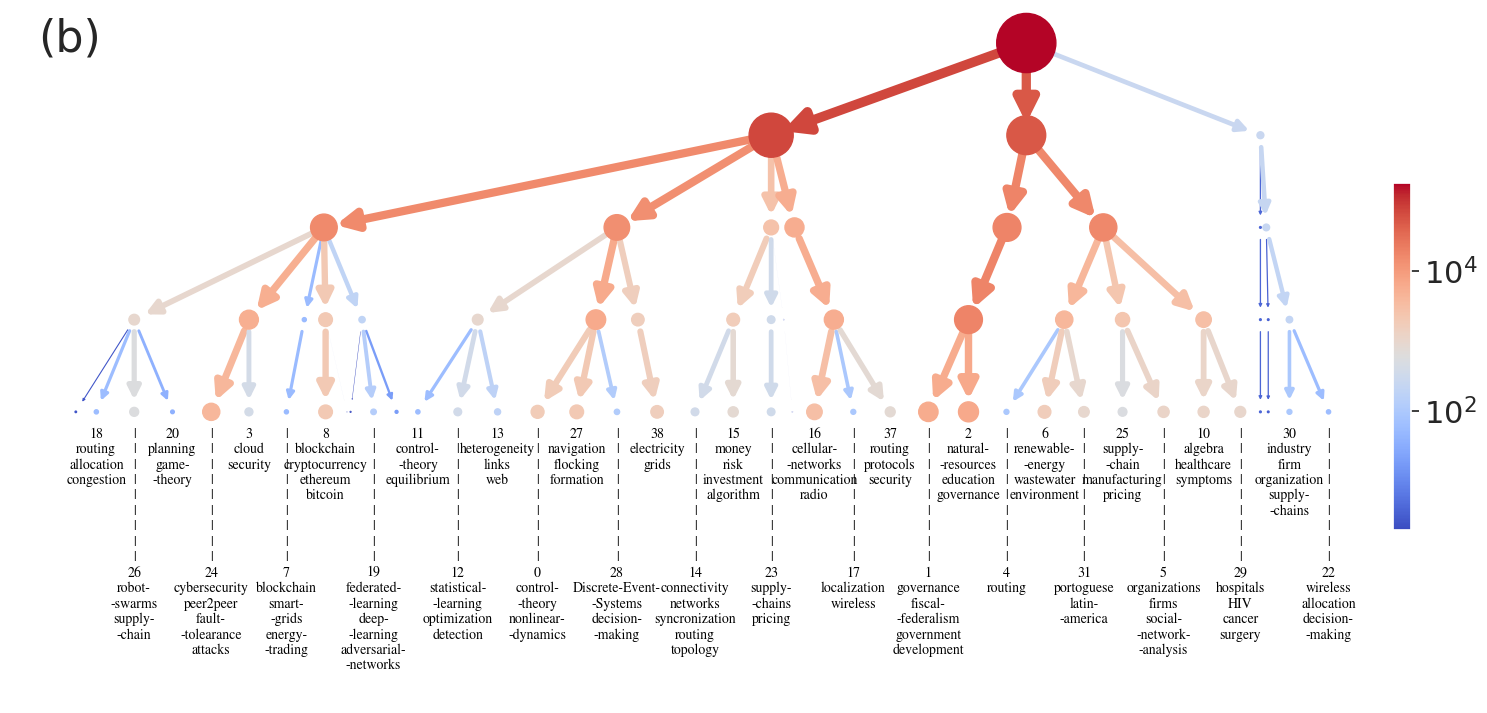

In [56]:
figsize=(21,9)
fig = plt.figure(figsize=figsize)
ax = plt.gca()
# plt.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=1)), ax=ax,shrink=0.5,pad=0.,fraction=0.2)
pos = create_hierarchy_network_docs(partition=0, top_level=6, bottom_level=2, 
                             max_num_clusters_to_represent=10000, num_words_to_represent=20, 
                             multiplicator_size_nodes=.01, multiplicator_size_edges=1, multiplicator_ypos=0.30,
                             fontsize = 10, ax=ax, fig=fig, threshold_num_papers = 500, num_spaces=50)

In [57]:
level2_pos = [(x,y) for x,y in pos.items() if x.split("_")[0]=="2"]
ordered_lev2_clusters_pos = sorted(level2_pos,key = lambda x:x[1][0])
ordered_lev2_clusters = [int(x[0].split("_")[1].split("\n")[0]) for x in ordered_lev2_clusters_pos]

In [58]:
print(ordered_lev2_clusters)

[32, 18, 26, 20, 24, 3, 7, 8, 9, 33, 19, 21, 11, 12, 13, 0, 27, 28, 38, 14, 15, 23, 35, 16, 17, 37, 1, 2, 4, 6, 31, 25, 5, 10, 29, 40, 36, 39, 30, 22]


In [59]:
ordered_hierarchy_lev_3 = []
for c in ordered_lev2_clusters:
    for c3 in hierarchy_docs[3].keys():
        if c in hierarchy_docs[3][c3] and c3 not in [x[0] for x in ordered_hierarchy_lev_3]:
            ordered_hierarchy_lev_3.append((c3,hierarchy_docs[3][c3]))

In [60]:
ordered_hierarchy_lev_3

[(0, {18, 20, 26, 32}),
 (3, {3, 24}),
 (5, {7}),
 (6, {8, 9}),
 (12, {19, 21, 33}),
 (8, {11, 12, 13}),
 (1, {0, 27, 28}),
 (18, {38}),
 (9, {14, 15}),
 (11, {23}),
 (15, {35}),
 (10, {16, 17, 37}),
 (2, {1, 2}),
 (4, {4, 6, 31}),
 (14, {5, 25}),
 (7, {10, 29}),
 (20, {40}),
 (17, {36}),
 (19, {39}),
 (13, {22, 30})]

## NEW KF

In [619]:
knowledge_flow_normalized_per_field_per_time_window_to_future_by_level = {}
for lev in [0,1,2,3]:
#     with gzip.open(f"{results_folder}knowledge_flow_normalized_per_field_per_time_window_to_future_gt_partition_lev_{lev}.pkl.gz","rb") as fp:
    with gzip.open(f"{results_folder}knowledge_flow_normalized_per_cluster_per_time_window_to_future_df_gt_partition_lev_{lev}.pkl.gz","rb") as fp:
        knowledge_flow_normalized_per_field_per_time_window_to_future_by_level[lev] = pickle.load(fp)

In [62]:
# TODO change from dict to df for knowledge flow!

def sample_knowledge_flow(level,cluster,threshold, time_window, num_papers_to_show, most_frequent_words):
    """ 
        selecting the best paper(s) contributing to the knowledge flow between cluster and cluster2 from the time_period to the future
        
    """
        
    knowl_flow_tmp = knowledge_flow_normalized_per_field_per_time_window_to_future_by_level[level][time_window]
    
    
    
    for time_period in knowl_flow_tmp.keys():
        range_time_period = range(time_period[0],time_period[1]+1)
        set_papers_study = set([x for x in ordered_paper_ids if cluster in all_docs_dict[x]['ye_partition'] and all_docs_dict[x]['year'] in range_time_period])
        papers_in_study_dict = {}

        for paper_id in set_papers_study:
            paper = all_docs_dict[paper_id]
            papers_in_study_dict[paper_id] = {"no_citations_all":len(paper["inCitations"]), "no_knowledge_units_all":len(paper["inCitations"])/len(paper["ye_partition"]), 
                                             "no_citations":len(set(paper["inCitations"]).intersection(all_papers_ids)), "no_knowledge_units":len(set(paper["inCitations"]).intersection(all_papers_ids))/len(paper["ye_partition"]) }
            tmp_count = {field:0 for field in all_partitions}
            for citing_paper_id in set(paper["inCitations"]).intersection(all_papers_ids):
                citing_paper = all_docs_dict[citing_paper_id]
                for chosen_edge_field in citing_paper["ye_partition"]:
                    tmp_count[chosen_edge_field] += 1/len(paper["ye_partition"])/len(citing_paper["ye_partition"])
            for field in all_partitions:
                papers_in_study_dict[paper_id][field] = tmp_count[field]

        papers_in_study_df = pd.DataFrame(papers_in_study_dict).transpose()

#         print(knowl_flow_tmp[time_period]['future'])
        knowledge_flows = knowl_flow_tmp[time_period]['future'][cluster].items()
        
        for cluster2,z_score in knowledge_flows:
            if z_score > threshold:
                
                selected_papers = papers_in_study_df[cluster2].sort_values(ascending=False).iloc[:num_papers_to_show].index.values
                
                for paper in selected_papers:
    
                    print(f"({time_period} : {z_score} to {cluster2} - {papers_in_study_df[cluster2].loc[paper]} cits)",end = " ")
                    if all_docs_dict[paper]["year"] != None:
                        print("y=%d"%all_docs_dict[paper]["year"],end = " ")
                    print("FoS=[",end = "")
                    for field in all_docs_dict[paper]["fieldsOfStudy"]:
                        print("%s"%field,end = ", ")
                    if len(all_docs_dict[paper]["fieldsOfStudy"]) == 0:
    #                     print("None",end = " - ")
                        print("None",end = ", ")
                    print("] - ", end = "")
                    for word in split_words(all_docs_dict[paper]['title']):
                        if pd.notna(word):
                            if word.lower() in most_frequent_words:
                                print(print_color.BOLD + print_color.RED + word + print_color.END, end="")
                            else:
                                print(word,end="")
                    print(f" --> {all_docs_dict[paper]['doiUrl']}")
#                     print("")


## SI figure for annotation

LEVEL 3 - CLUSTER 6



/tmp/ipykernel_13041/2242581569.py:390: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=rect)


50 MOST FREQUENT WORDS IN THE TOPICS ----> ['blockchain', 'smart', 'iot', 'privacy', 'bitcoin', 'secure', 'internet', 'digital', 'sharing', 'things', 'applications', 'contracts', 'blockchains', 'ethereum', 'trust', 'authentication', 'storage', 'identity', 'preserving', 'ledger', 'proof', 'voting', 'enabled', 'computing', 'cryptocurrency', 'transaction', 'peer', 'edge', 'payment', 'cryptocurrencies', 'new', 'trusted', 'industry', 'key', 'currency', 'securing', 'private', 'anonymous', 'transactions', 'intelligent', 'lightweight', 'ecosystem', 'crypto', 'integrity', 'hyperledger', 'verifiable', 'devices', 'token', 'permissioned', 'personal'] 

---> TOPIC 47		normalized mixture proportion = 1.6784		mixture proportion = 0.0104
	56 WORDS - virtual - bitcoin - incentive - transaction - route - payment - pre - cryptocurrency - currency - transactions - cryptocurrencies - fundamental - crypto - cash - compatible - currencies - payments - collusion - assets - coin 

---> TOPIC 49		normalized mix

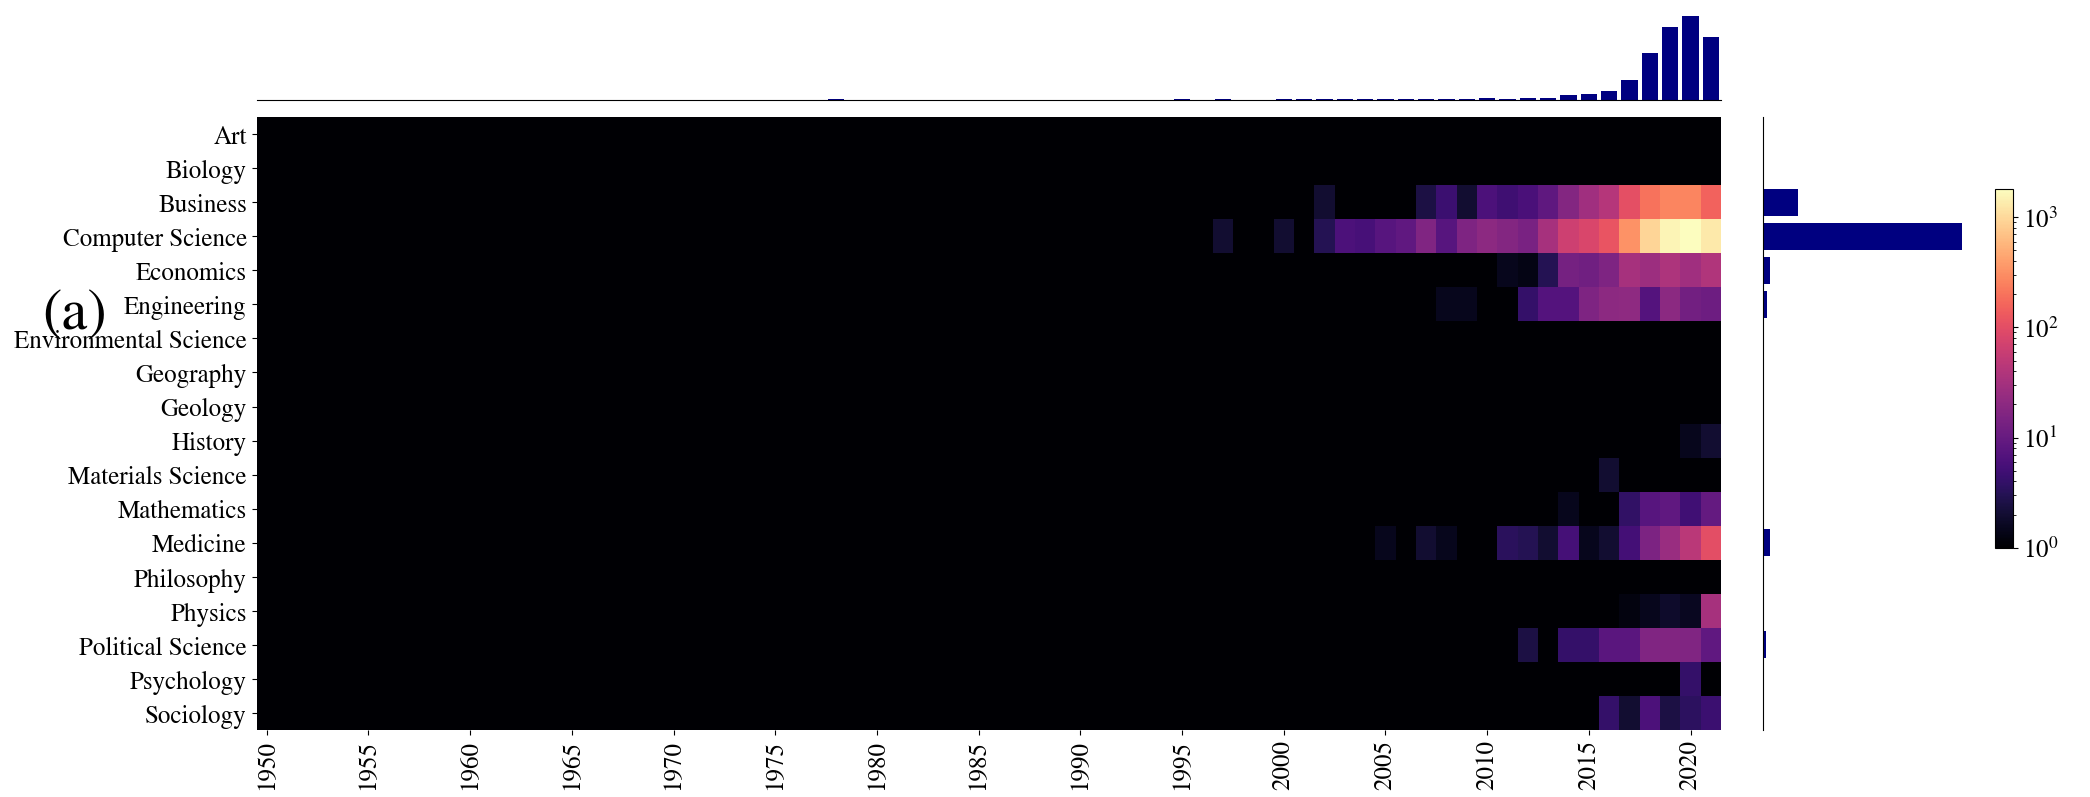

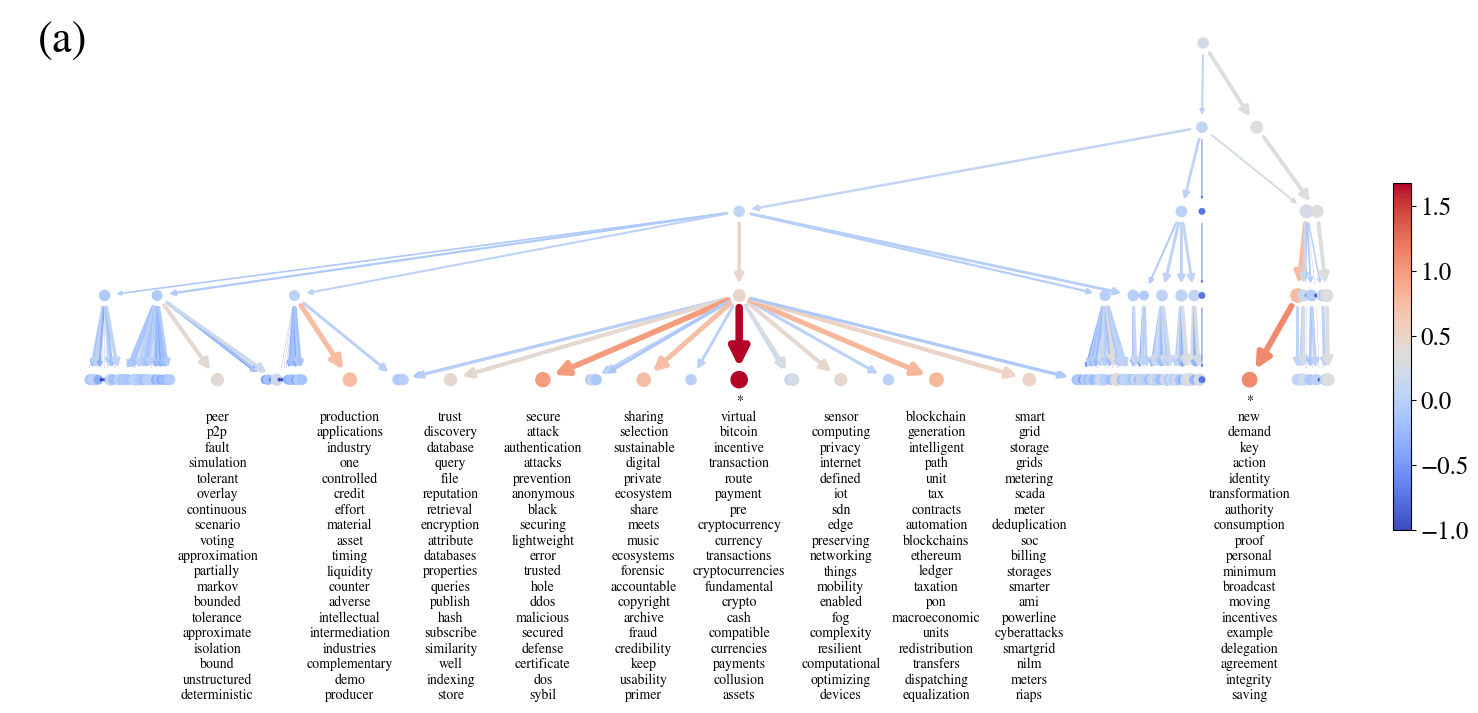

In [188]:
centralities_to_print = ['citations_overall','in_degree','eigenvector','betweenness','closeness','pagerank','katz']
x = analyse_cluster_supernew(lev = 3, top_level_topics=6, bottom_level_topics = 2, partition=6, centralities_to_print=centralities_to_print, 
                 max_num_topics_to_represent = 10, num_most_frequent_words = 50, num_papers_to_show = 1, do_sample_knowledge_flow = True,
                 multiplicator_size_nodes=50, multiplicator_size_edges=0.04, multiplicator_ypos=0.25, fontsize_graph=10,
                    colorbar_log_heatmap=True)

# Papers analysis

In [147]:
all_docs_dict[paper_id].keys()

dict_keys(['id', 'title', 'paperAbstract', 'authors', 'inCitations', 'outCitations', 'year', 's2Url', 'sources', 'pdfUrls', 'venue', 'journalName', 'journalVolume', 'journalPages', 'doi', 'doiUrl', 'pmid', 'fieldsOfStudy', 'magId', 's2PdfUrl', 'entities', 'ye_partition'])

In [389]:
_id = []
_title = []
_fields = []
_clusters_lev2 = []
_clusters_lev3 = []
_clusters_lev4 = []
_clusters_lev5 = []
_year = []
_doi = []
_abstract = []

for i,paper_id in enumerate(ordered_paper_ids):
    paper = all_docs_dict[paper_id]
    
    _id.append(paper_id)
    _title.append(paper['title'])
    _fields.append(paper['fieldsOfStudy'])
    _clusters_lev2.append(h_t_doc_consensus_by_level[2][i])
    _clusters_lev3.append(h_t_doc_consensus_by_level[3][i])
    _clusters_lev4.append(h_t_doc_consensus_by_level[4][i])
    _clusters_lev5.append(h_t_doc_consensus_by_level[5][i])
    _year.append(paper['year'])
    _doi.append(paper['doiUrl'])
    _abstract.append(paper['paperAbstract'])


In [422]:
all_papers_df = pd.DataFrame({'title':_title,
                             'abstract': _abstract,
                             'fields': _fields,
                             'year':_year,
                             'doi':_doi,
                             'clusters_lev2':_clusters_lev2,
                             'clusters_lev3':_clusters_lev3,
                             'clusters_lev4':_clusters_lev4,
                             'clusters_lev5':_clusters_lev5,
                             'citations_overall':centralities['citations_overall'], 
                             'in_degree':centralities['out_degree'], 
                             'eigenvector':centralities['eigenvector'],
                             'betweenness':centralities['betweenness'],
                             'closeness':centralities['closeness'],
                             'pagerank':centralities['pagerank'],
                             'katz':centralities['katz'],
                             'id':_id,
                             })

In [423]:
all_papers_df['decade'] = (all_papers_df['year'].fillna(-10) / 10).astype(int)*10

In [424]:
all_papers_df.sort_values("year").head(20).iloc[2]['title']

'Local self-government and centralization : the characteristics of each; and its practical tendencies, as affecting social, moral, and political welfare and progress, including comprehensive outlines of the English constitution'

In [443]:
all_papers_df.loc[all_papers_df.clusters_lev2.isin([1,2])].sort_values("year").iloc[:50]#.sort_values("in_degree",ascending=False).iloc[0]['abstract']

title  \
96484                            Ministère de l'Intérieur   
142319  Local self-government and centralization : the...   
152089  Recent Centralizing Tendencies in the Supreme ...   
99672   Recent centralizing tendencies in state educat...   
69978   Democracy and the organization of political pa...   
126325       The Centralization Of Administration In Ohio   
127170               De Indische decentralisatiewetgeving   
159003                                   The Labor Market   
146482  Regionalism and Administrative Decentralizatio...   
119262                                   The modern state   
77434   The Evolution of Provincial Finance in British...   
119508  Hunter, Merlin H. Outlines of Public Finance. ...   
116518  The Report of the Committee on Mississippi Flo...   
166355  What is to be done? : burning questions of our...   
133031             The city of to-morrow and its planning   
170533                  Nieuwe vormen van decentralisatie   
59727   25 jaren decentralisatie in Nederlandsch-Indië...   
150211                      Tropical Medicine and Hygiene   
169351  Uniform State Action: A Possible Substitute fo...   
171174                              The method of freedom   
135975                    A Re-statement of Indirect Rule   
136774  Executive Decentralisation with Functional Co‐...   
67975                           Technics and Civilization   
27407   Coördination of Federal, State, and Local Tax ...   
179929  The Royal Commission on Dominion-Provincial Re...   
146481            Three Aspects of Regional Consciousness   
84350                   State Centralization in the South   
158803                  Federal-State Personnel Relations   
22542   Centralization or decentralization? : a study ...   
155622                     The Nuer Of The Southern Sudan   
122310                                 The Garrison State   
137903  Forces of Urban Centralization and Decentraliz...   
110403  Administrative decentralization : a study of t...   
154641  Standardization of distribution in densely loa...   
105883  The new centralization : a study of intergover...   
107243  Centralised vs. Decentralised Government in Re...   
9131                  Capitalism, Socialism and Democracy   
138539         Orestes A. Brownson' The American Republic   
165901  Modernized Cameralism in the Third Reich: The ...   
82575   Francis Lieber's Theories of Society, Governme...   
150018                            A Marx for the Managers   
133126         Thomas Jefferson and Public Administration   
3622                       Decentralization and Democracy   
175992                       Francis Lieber's Nationalism   
178268  Mathematics in Government Service and Industry...   
153667  Worker's Control of Industry and the British L...   
172662         A Plea for Administrative Decentralization   
94514                      Study of Public Administration   
156430  Neighborhood Associations in Japan and Their D...   
12049   Integration vs. Decentralization in the Federa...   

                                                 abstract  \
96484   La délinquance, la violence et l’insécurité re...   
142319                                                      
152089                                                      
99672                                                       
69978   These effects of the dwindling of individualit...   
126325                                                      
127170                                                      
159003  This paper analyzes the case for fiscal federa...   
146482                                                      
119262  Nothing manifests the strengths and weaknesses...   
77434   A STUDY IN THE PROVINCIAL DECENTRALISATION OF ...   
119508  One could wish that the author had written a f...   
116518  (1) To begin with, the Committee attempted to ...   
166355  Rabocheye Dyelo’s assertions, which we have an...   
133031  This is a transla

In [164]:
keywords_clusters[2][10]

'algebra\nhealthcare\nsymptoms'

In [ ]:
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# # Create the data
# rs = np.random.RandomState(1979)
# x = rs.randn(500)
# g = np.tile(list("ABCDEFGHIJ"), 50)
# df = pd.DataFrame(dict(x=x, g=g))
# m = df.g.map(ord)
# df["x"] += m

# # Initialize the FacetGrid object
# pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
# g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# # Draw the densities in a few steps
# g.map(sns.kdeplot, "x",
#       bw_adjust=.5, clip_on=False,
#       fill=True, alpha=1, linewidth=1.5)
# g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# # passing color=None to refline() uses the hue mapping
# # g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# # Define and use a simple function to label the plot in axes coordinates
# def label(x, color, label):
#     ax = plt.gca()
#     ax.text(0, .2, label, fontweight="bold", color=color,
#             ha="left", va="center", transform=ax.transAxes)


# g.map(label, "x")

# # Set the subplots to overlap
# # g.figure.subplots_adjust(hspace=-.25)

# # Remove axes details that don't play well with overlap
# g.set_titles("")
# g.set(yticks=[], ylabel="")
# g.despine(bottom=True, left=True)

In [168]:
import importlib

In [169]:
importlib.reload(sn)

<module 'seaborn' from '/home/enterprise.internal.city.ac.uk/aczy350/anaconda3/envs/gt/lib/python3.9/site-packages/seaborn/__init__.py'>

In [202]:
all_papers_df.groupby(["decade","clusters_lev3"],as_index=False).doi.count().replace(-10,np.nan).dropna().rename({"doi":"papers"},axis=1).head(20)

decade  clusters_lev3  papers
16  1800.0              2       1
17  1800.0             14       1
18  1850.0              2       1
19  1860.0              4       1
20  1860.0              7       1
21  1870.0              7       1
22  1880.0              7       1
23  1890.0              2       2
24  1890.0              7       4
25  1900.0              2       2
26  1900.0              4       1
27  1900.0              7       4
28  1900.0             14       1
29  1910.0              2       2
30  1910.0              3       1
31  1910.0              7       1
32  1920.0              2       8
33  1920.0              7       4
34  1920.0             14       4
35  1930.0              2      10

In [426]:
x = knowledge_flow_normalized_per_field_in_time_by_level_df[2]
x = x.loc[x.knowledge_flow>0]
x.loc[(x.cluster_from.isin([2,4]))&(x.cluster_to.isin([10,29]))&(x.year_from<1900)&(x.year_to<1900)&(x.knowledge_flow>0)]

Empty DataFrame
Columns: [year_from, year_to, cluster_from, cluster_to, knowledge_flow]
Index: []

In [427]:
x[f'within_branch_lev_{3}'] = x.apply(lambda x:same_branch(x['cluster_from'],x['cluster_to'],3),axis=1)
# x[f'within_branch_lev_{4}'] = x.apply(lambda x:same_branch(x['cluster_from'],x['cluster_to'],4),axis=1)

/tmp/ipykernel_19651/2432334579.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[f'within_branch_lev_{3}'] = x.apply(lambda x:same_branch(x['cluster_from'],x['cluster_to'],3),axis=1)


In [428]:
x.loc[(x.year_from<1950)&(x.year_to<1950)]

year_from  year_to  cluster_from  cluster_to  knowledge_flow  \
3965810         1922     1939             1           2             1.0   
6241561         1889     1935            10          10             1.0   
6243901         1908     1919            10          10             2.0   
6243910         1908     1928            10          10             2.0   
6243917         1908     1935            10          10             2.0   
6245530         1923     1943            10          10             3.0   
6245807         1926     1926            10          10             2.0   
6246019         1928     1947            10          10             2.0   
6246291         1931     1940            10          10             1.0   
6247479         1945     1945            10          10             1.0   
37131771        1935     1942             2           2             3.0   
111254617       1920     1925             5           5             1.0   

           within_branch_lev_3  
3965810                      1  
6241561                      2  
6243901                      2  
6243910                      2  
6243917                      2  
6245530                      2  
6245807                      2  
6246019                      2  
6246291                      2  
6247479                      2  
37131771                     2  
111254617                    2

In [429]:
all_papers_df.loc[all_papers_df.year < 1950].clusters_lev2.value_counts()

10    34
2     31
1     20
5      7
31     6
29     2
16     1
24     1
Name: clusters_lev2, dtype: int64

## 1950s

In [430]:
all_papers_df.loc[(all_papers_df.decade.isin([1950]))].clusters_lev2.value_counts()

2     42
10    18
1     16
5     12
15     4
29     4
31     4
16     3
38     3
8      1
13     1
Name: clusters_lev2, dtype: int64

In [431]:
all_papers_df.loc[(all_papers_df.decade.isin([1950]))&~(all_papers_df.clusters_lev2.isin([1,2]))]

title  \
3300      Decentralization and the Transfer-Price Problem   
5131      Toward an Interactional Conception of Community   
5560    centralization vs. decentralization in organiz...   
5951    The Acquisitions and Cataloging of Research Li...   
9960                 On the Economics of Transfer Pricing   
21177     Managing geographically decentralized companies   
22888   Management Decentralization: An Historical Ana...   
25750   CENTRALIZATION AND DECENTRALIZATION IN ECONOMI...   
29338    The extended centralizer of a ring over a module   
34839             CENTRALIZATION VERSUS DECENTRALIZATION.   
39774      On finite groups with given conjugate types. I   
55027           A FEW CASES OF RETINITIS CENTRALIS SEROSA   
65541   Centralized Control Desirable for Single Boile...   
65542   Centralized Instrumentation and Controls for S...   
67818   Contribution to the chorioretinitis centralis ...   
79978   EVOKED ACTIVITY IN THE CAUDATE NUCLEUS OF THE ...   
80093   Capital Equipment Analysis: The Required Rate ...   
84595              On the tower theorem for finite groups   
90428   LARGE BRANCH FROM THE SUPERIOR TEMPORAL VEIN C...   
90648                       Centralized vs decentralized.   
97717   Left centralizers and isomorphisms of group al...   
99524   Über die Färbbarkeit des NISSLschen Grau an ve...   
99525   Örtliche Verschiedenheit der Mengenverhältniss...   
100168  The Balance between centralization and decentr...   
101129  Effect of decentralisation on the content of c...   
104872     SPHERICAL FUNCTIONS ON A SEMISIMPLE LIE GROUP.   
104873            The characters of semisimple Lie groups   
110451          On characterizations of linear groups. II   
111189  The effect of anticholinesterases on the parot...   
115408      External Economies, Investment, and Foresight   
116259             CENTRALIZING MEDICAL LIBRARY RESOURCES   
120450  Organization and Information Handling in Task ...   
135137  La conception de la décentralisation administr...   
136701  Monkeys in relation to the epidemiology of yel...   
137579              The Concept of Organizational Control   
140183  An experimental remote controlled line concent...   
140184         Common control telephone switching systems   
142305  Relation of Personnel Statistics to Organizati...   
153328  Course of fibers of brachium conjunctivum reve...   
154674  A Comment on the Pure Theory of Public Expendi...   
158871                    Centralizers in Jordan algebras   
161863  Über die inframikroskopische Strukturdichte de...   
163011  Centralization vs. Decentralization: The Case ...   
163786  [Expansion of the rod-free area of the fovea c...   
164845  [Centralization of muscular activity in loweri...   
165618             Organizing for Retail Decentralization   
166145  [Centralization of treatment in hypnotic poiso...   
166773                    The transformer analog computer   
171582  The multi-sequence computer as a communication...   
178827  The thalamic source of cortical recruiting in ...   

                                                 abstract  \
3300                                                        
5131    T IHE GROWING CONCERN of the general public an...   
5560                                                        
5951    IN ITS report to Congress in 1815 the Joint Co...   
9960    TN ORDER to achieve the benefits of decentrali...   
21177                                                       
22888   This article deals with development of basic m...   
25750   The preference for decentralization in the cla...   
29338   In a recent paper,' K. Asano gave a new proof ...   
34839   Thirteen years ago, the American Political Sci...   
39774   Let G be a finite group. Let n 1 , n 2 ,…, n r...   
55027   The following work is a contribution to the ca...   
65541                                                       
65542                                                       
67818                    

In [432]:
x.loc[(x.year_from<1960)&(x.year_to<1960)&(x.knowledge_flow>0)&(x.cluster_from!=x.cluster_to)]

year_from  year_to  cluster_from  cluster_to  knowledge_flow  \
3965810       1922     1939             1           2             1.0   
3968243       1950     1950             1           2             6.0   
3968324       1951     1959             1           2             3.5   

         within_branch_lev_3  
3965810                    1  
3968243                    1  
3968324                    1

## 1960s

In [433]:
all_papers_df.loc[(all_papers_df.decade.isin([1960]))].clusters_lev2.value_counts()

10    138
2      98
1      51
5      50
15     29
31     14
29     13
16      8
24      5
38      3
33      2
0       2
20      2
11      2
6       2
27      1
28      1
13      1
39      1
Name: clusters_lev2, dtype: int64

In [434]:
keywords_clusters[2][15]

'money\nrisk\ninvestment\nalgorithm'

In [435]:
all_papers_df.loc[(all_papers_df.decade.isin([1960]))&(all_papers_df.clusters_lev2.isin([15]))].sort_values("in_degree",ascending=False)

title  \
7562          Decomposition Principle for Linear Programs   
8252    Decomposition, Pricing for Decentralization an...   
27856               Decentralized Procedures for Planning   
1262    EFFECTIVE CONTROL THROUGH COHERENT DECENTRALIZ...   
51199                             Planning without Prices   
75390      The Evaluation of Information in Organizations   
83995           Studies in Resource Allocation Processes.   
103289  On the Concept and Possibility of Informationa...   
75566          Price Guides in Decentralized Organization   
48815       Labour Allocation in a Cooperative Enterprise   
69281   Computation In Organizations: Comparison Of Pr...   
84425   Plant Location Under Economies-of-Scale---Dece...   
157778            Planning in decentralized organizations   
123205  Centralized Versus Decentralized Resource Allo...   
113251  INFORMATIONAL EFFICIENCY AND DECENTRALIZATION ...   
103603    Public Goods and Decentralization of Production   
61889   On the Comparison of Centralized and Decentral...   
101762  An Economic Analysis of Internal Migration in ...   
67641           Decentralization in Separable Programming   
62343                   On Choosing an Optimal Technology   
159338  OPTIMAL PATHS OF CAPITAL ACCUMULATION UNDER TH...   
172900  Centralization and decentralization of decisio...   
179374  A Reinterpretation of the Pure Theory of Exhau...   
101761                                 Volume Information   
84424   INDUSTRIAL DEVELOPMENT PLANNING MODELS WITH EC...   
112914  EFFECTIVE CONTROL THROUGH COHERENT DECENTRALIZ...   
58768   Decision Making Behaviours Represented in a Fo...   
68894   The Assignment of Costs to Joint Products in a...   
174627  Competitive Organizational Structures in Coupl...   

                                                 abstract  \
7562    A technique is presented for the decomposition...   
8252    The decomposition procedure for the solution o...   
27856   One of the main aims of long-term plans, which...   
1262    Abstract : This paper shows that control throu...   
51199   Discussions of decentralized planning procedur...   
75390   Abstract : Contents: Team decision problems wi...   
83995   One of the central questions of economics rela...   
103289                                                      
75566                                                       
48815   Two methods of income distribution have been p...   
69281   We shall be concerned in this paper with the g...   
84425   An exploration of the margin of error entailed...   
157778                                                      
123205  I. Introduction: comparing allocation mechanis...   
113251                                                      
103603                                                      
61889                                                       
101762  Analyzing interstate migration in Brazil 3 hyp...   
67641                                                       
62343   This paper is concerned with the problem of ch...   
159338  Abstract : The important question of investmen...   
172900  L’accès aux archives de la revue « Revue franç...   
179374  EVENTUAL exhaustion of natural resources is of...   
101761  Andersen, Leonall C. Federal Reserve Defensive...   
84424   In the field of industrial planning and planni...   
112914  The theory of economic models of decentralizat...   
58768   Following the definitions of concepts of the l...   
68894   T .JTHEN two or more products are jointly prod...   
174627  The effect of different company organizational...   

                               fields    year  \
7562               [Computer Science]  1960.0   
8252                      [Economics]  1964.0   
27856                   [Engineering]  1967.0   
1262                      [Economics]  1967.0   
51199                     [Economics]  1969.0   
75390                   [Mathematics]  1961.0   
83995   [Computer Science, Economics]  1962.0  

In [436]:
t=x.loc[(x.year_from<1970)&(x.year_to<1970)&(x.knowledge_flow>0)&(x.cluster_from!=x.cluster_to)].copy()
z = t.apply(lambda x:find_kf_important_paper(x['cluster_from'],x['cluster_to'],x['year_from'],x['year_to']),axis=1)
t[['paper_id','kf']] = z.to_list()
t['title'] = t.paper_id.apply(lambda x:all_docs_dict[x]['title'])

In [437]:
t

year_from  year_to  cluster_from  cluster_to  knowledge_flow  \
3965810         1922     1939             1           2        1.000000   
3966973         1934     1968             1           2        3.000000   
3968243         1950     1950             1           2        6.000000   
3968324         1951     1959             1           2        3.500000   
3968931         1960     1963             1           2        7.333333   
3968998         1961     1968             1           2        5.750000   
21176355        1960     1963            15           0       22.000000   
21176360        1960     1968            15           0       22.000000   
22058728        1959     1967            15           2       19.000000   
23823649        1960     1961            15           5       22.000000   
23823898        1964     1968            15           5        7.500000   
23823899        1964     1969            15           5       15.000000   
36839062        1953     1964             2          16        2.000000   
38898536        1960     1968             2           5        2.000000   
38898720        1963     1969             2           5        3.333333   
63018701        1966     1968            27           5       24.500000   
109125157       1956     1967             5          15        2.000000   
109125477       1961     1967             5          15        7.666667   

           within_branch_lev_3                                  paper_id   kf  \
3965810                      1  6ed1e68e2e06e77027abb2d3392d02c369e82f7a  1.0   
3966973                      1  a6e6b369e01240e3f3c76405285510a033fdb84a  1.0   
3968243                      1  a012028e6830c5fe466194d092a8e066d81cc685  1.0   
3968324                      1  a935e2106cb77ae65a1f6ea805e0828880824a29  1.0   
3968931                      1  dd5332ae557525edbaa7858450fff8394f0ddd51  1.0   
3968998                      1  8ac7561b09c20b393bdbda37ad74473ed9c1f34f  1.0   
21176355                     0  6c7a9b049927e6756fbaf425e323c1aad05591f8  1.0   
21176360                     0  6c7a9b049927e6756fbaf425e323c1aad05591f8  1.0   
22058728                     0  c138866124b3d8dcbd0c6b1c191426d6de76ef92  1.0   
23823649                     0  6c7a9b049927e6756fbaf425e323c1aad05591f8  1.0   
23823898                     0  5240fe445be9d06cb71181e8320fe52425a311bf  1.0   
23823899                     0  a54807c4dbfccbef2935f80bef49229eaadcdb9e  1.0   
36839062                     0  19eac23d652f9b8e2098238d9414001439701693  1.0   
38898536                     0  14349039ab994d05aa5be7f666748d2138564ef8  1.0   
38898720                     0  9548e326f8ec5b8da61b0c89782ec16e44268973  1.0   
63018701                     0  c1058d5807656a31599743f1e06c5a5d114d640a  1.0   
109125157                    0  8c495ad959ea4fd25f9733f64ef30bd1116bc07f  1.0   
109125477                    0  dde88e5b14227a107bba25ebf0fa78bd93194d9f  1.0   

                                                       title  
3965810    Regionalism and Administrative Decentralizatio...  
3966973                      A Re-statement of Indirect Rule  
3968243    The States and Decentralized Administration of...  
3968324                 Patterns of Authority in West Africa  
3968931    Indigenous Politics and Colonial Administratio...  
3968998    The Relation of Local Government Structure to ...  
21176355         Decomposition Principle for Linear Programs  
21176360         Decomposition Principle for Linear Programs  
22058728   CENTRALIZATION AND DECENTRALIZATION IN ECONOMI...  
23823649         Decomposition Principle for Linear Programs  
23823898   Decomposition, Pricing for Decentralization an...  
23823899   Plant Location Under Economies-of-Scale---Dece...  
36839062                      Cooperation and Centralization  
38898536   Correlates of Trade Union Participation: A Sum...  
38898720   From Evangelism to General Services: The Trans...  
63018701   Allocating Weapons to Targ

## 1970s

In [438]:
all_papers_df.loc[(all_papers_df.decade.isin([1970]))].clusters_lev2.value_counts()

10    508
2     395
1     206
5     140
15    125
0     118
11    110
31     46
24     45
6      32
29     29
27     21
14     18
16     17
4      11
25     10
13      7
21      6
38      5
22      5
28      4
23      4
8       3
3       3
39      2
30      2
19      2
26      2
12      2
20      1
18      1
34      1
17      1
40      1
Name: clusters_lev2, dtype: int64

In [439]:
keywords_clusters[2][15]

'money\nrisk\ninvestment\nalgorithm'

In [440]:
all_papers_df.loc[(all_papers_df.decade.isin([1970]))&~(all_papers_df.clusters_lev2.isin([156]))].sort_values("in_degree",ascending=False)

title  \
351     Survey of decentralized control methods for la...   
2394    On the stabilization of decentralized control ...   
3086    Centrality in social networks conceptual clari...   
1741    Decentralized control of linear multivariable ...   
369                      The Structuring of Organizations   
...                                                   ...   
109016  Morita's Fh-condition and double centralizers. II   
156629  Nuclear Policy and World Order: Why Denucleari...   
156601  The influence of noradrenaline synthesis inhib...   
72675   Frequency of Alzheimer's Neurofibrillary Tangl...   
76887   The Responsiveness of Public Schools to Their ...   

                                                 abstract  \
351     This paper surveys the control theoretic liter...   
2394    This paper considers the problem of stabilizin...   
3086    Abstract The intuitive background for measures...   
1741    Abstract: This paper studies the effect of dec...   
369     This [reading] argues that […] spans of contro...   
...                                                   ...   
109016                                                      
156629  While taking note of the growing anxiety, part...   
156601  The disappearance of dl-metaraminol-7-3H (3H-M...   
72675   The authors studied the frequency of neurofibr...   
76887   EDRS PRICE MF-$0.83 HC-$8.69 Plus Postage. DES...   

                                              fields    year  \
351                                    [Engineering]  1978.0   
2394                                   [Mathematics]  1973.0   
3086                                    [Psychology]  1978.0   
1741    [Engineering, Computer Science, Mathematics]  1976.0   
369                               [Computer Science]  1979.0   
...                                              ...     ...   
109016                                 [Mathematics]  1973.0   
156629                                   [Economics]  1978.0   
156601                         [Chemistry, Medicine]  1971.0   
72675                                     [Medicine]  1975.0   
76887                            [Political Science]  1973.0   

                                                      doi  clusters_lev2  \
351              https://doi.org/10.1109/TAC.1978.1101704              0   
2394             https://doi.org/10.1109/TAC.1973.1100362              0   
3086     https://doi.org/10.1016/0378-8733%2878%2990021-7              5   
1741     https://doi.org/10.1016/0005-1098%2876%2990008-X              0   
369          https://doi.org/10.1007/978-1-349-20317-8_23              5   
...                                                   ...            ...   
109016   https://doi.org/10.1016/0021-8693%2873%2990017-3             10   
156629         https://doi.org/10.1177/030437547800300301              6   
156601  https://doi.org/10.1111/J.1748-1716.1971.TB050...             10   
72675   https://doi.org/10.1111/j.1440-1819.1975.tb023...             10   
76887                                                                  2   

        clusters_lev3  clusters_lev4  clusters_lev5  citations_overall  \
351                 1              1              0               1084   
2394                1              1              0                756   
3086               14              3              1              13287   
1741                1              1              0                325   
369                14              3              1               4786   
...               ...            ...            ...                ...   
109016              7              3              1                  4   
156629              4              3              1                  4   
156601              7              3              1                  1   
72675               7              3              1                 24   
76887               2              2              1                  0   

        in_degr

In [409]:
all_papers_df.loc[all_papers_df.title.str.contains("clarification")]

title  \
3086    Centrality in social networks conceptual clari...   
49968   Tailored water treatment using enhanced primar...   
75487   Knowledge heterogeneity and social network ana...   
148758  Taxonomic status of the Australian burrowing f...   
159490  Electronic marketplace definition and classifi...   
178130  Power relinquishment versus power sharing: The...   

                                                 abstract  \
3086    Abstract The intuitive background for measures...   
49968   An emerging strategy for urban water infrastru...   
75487   This literature review highlights some Social ...   
148758  I review genetic and call structure data avail...   
159490  The definitions and classifications of any new...   
178130  This article presents a theoretical and empiri...   

                              fields    year  \
3086                    [Psychology]  1978.0   
49968        [Environmental Science]  2017.0   
75487                    [Sociology]  2008.0   
148758                     [Biology]  2010.0   
159490  [Business, Computer Science]  2007.0   
178130                  [Psychology]  1987.0   

                                                      doi  clusters_lev2  \
3086     https://doi.org/10.1016/0378-8733%2878%2990021-7              5   
49968                  https://doi.org/10.1039/C7EW00019G              6   
75487                 https://doi.org/10.1057/kmrp.2008.9              5   
148758  https://doi.org/10.18195/issn.0312-3162.25%284...             10   
159490          https://doi.org/10.1080/17517570601088380              8   
178130         https://doi.org/10.1037/0021-9010.72.2.228              2   

        clusters_lev3  clusters_lev4  clusters_lev5  citations_overall  \
3086               14              3              1              13287   
49968               4              3              1                  2   
75487              14              3              1                 16   
148758              7              3              1                  6   
159490              6              0              0                 79   
178130              2              2              1                157   

        in_degree    eigenvector   betweenness  closeness  pagerank      katz  \
3086          2.0   2.794759e-04  9.355892e-07   1.000000  0.000886  0.014797   
49968         6.0   0.000000e+00  0.000000e+00   0.402062  0.000002  0.002238   
75487         4.0   0.000000e+00  0.000000e+00   0.555556  0.000002  0.002238   
148758        4.0   0.000000e+00  0.000000e+00   0.833333  0.000002  0.002238   
159490        0.0  1.507053e-135  0.000000e+00        NaN  0.000004  0.002266   
178130        0.0   0.000000e+00  0.000000e+00        NaN  0.000005  0.002261   

                                              id  decade  
3086    5d61ef638fd684facc1e68e654053e9bc065b36f    1970  
49968   1cea8196541069cd591424b8bc9af1cf2556eaf8    2010  
75487   75f87edd4833d372b2e6791b5b70f0fd76769585    2000  
148758  469b10cb329c3fa21482f017d85371508b280245    2010  
159490  090596364357b5e6727ca9b2f02972f6b6213dc3    2000  
178130  4c36e3e73a05ed4ecdecf103e40f8f0421d92302    1980

In [384]:
t = x.loc[(x.year_from<1980)&(x.knowledge_flow>2)&(x.cluster_from!=x.cluster_to)&(x.cluster_from==5)].copy() #&(x.year_to<1980) (x.year_from>=1970)&(x.year_to>=1970)
z = t.apply(lambda x:find_kf_important_paper(x['cluster_from'],x['cluster_to'],x['year_from'],x['year_to']),axis=1)
t[['paper_id','kf']] = z.to_list()
t['title'] = t.paper_id.apply(lambda x:all_docs_dict[x]['title'])

In [385]:
t

year_from  year_to  cluster_from  cluster_to  knowledge_flow  \
108682871       1941     2007             5           1        7.000000   
108682877       1941     2013             5           1        3.500000   
108683835       1954     1996             5           1        6.000000   
108683840       1954     2001             5           1        6.000000   
108683850       1954     2011             5           1        3.000000   
...              ...      ...           ...         ...             ...   
111479579       1978     2016             5           8       18.214286   
111479580       1978     2017             5           8       18.214286   
111479581       1978     2018             5           8       18.214286   
111479583       1978     2020             5           8       18.214286   
111479627       1979     2020             5           8       17.588235   

           within_branch_lev_3  within_branch_lev_4  \
108682871                    0                    0   
108682877                    0                    0   
108683835                    0                    0   
108683840                    0                    0   
108683850                    0                    0   
...                        ...                  ...   
111479579                    0                    0   
111479580                    0                    0   
111479581                    0                    0   
111479583                    0                    0   
111479627                    0                    0   

                                           paper_id   kf  \
108682871  c75c4fa9ef3f821e4a2da4718217d9634f2a5594  1.0   
108682877  c75c4fa9ef3f821e4a2da4718217d9634f2a5594  1.0   
108683835  7a3a90d07cb5e88713643cec6324ac0c51c8e085  1.0   
108683840  7a3a90d07cb5e88713643cec6324ac0c51c8e085  1.0   
108683850  7a3a90d07cb5e88713643cec6324ac0c51c8e085  1.0   
...                                             ...  ...   
111479579  5d61ef638fd684facc1e68e654053e9bc065b36f  2.0   
111479580  5d61ef638fd684facc1e68e654053e9bc065b36f  1.0   
111479581  5d61ef638fd684facc1e68e654053e9bc065b36f  2.0   
111479583  5d61ef638fd684facc1e68e654053e9bc065b36f  2.0   
111479627  d16eea8cabab99c23d7804853b8ce20cfb132b34  1.0   

                                                       title  
108682871                             The new centralization  
108682877                             The new centralization  
108683835  centralization vs. decentralization in organiz...  
108683840  centralization vs. decentralization in organiz...  
108683850  centralization vs. decentralization in organiz...  
...                                                      ...  
111479579  Centrality in social networks conceptual clari...  
111479580  Centrality in social networks conceptual clari...  
111479581  Centrality in social networks conceptual clari...  
111479583  Centrality in social networks conceptual clari...  
111479627                   The Structuring of Organizations  

[427 rows x 10 columns]

In [269]:
keywords_clusters[2][11]

'control theory\nequilibrium'

In [270]:
keywords_clusters[2][0]

'control theory\nnonlinear dynamics'

In [273]:
len(all_papers_df.loc[all_papers_df.clusters_lev2 == 11])

926

## kf important papers

In [281]:
def sample_knowledge_flow(level,cluster,threshold, time_window, num_papers_to_show, most_frequent_words):
    """ 
        selecting the best paper(s) contributing to the knowledge flow between cluster and cluster2 from the time_period to the future
        
    """
        
    knowl_flow_tmp = knowledge_flow_normalized_per_field_per_time_window_to_future_by_level[level][time_window]
    
    
    
    for time_period in knowl_flow_tmp.keys():
        range_time_period = range(time_period[0],time_period[1]+1)
        set_papers_study = set([x for x in ordered_paper_ids if cluster in all_docs_dict[x]['ye_partition'] and all_docs_dict[x]['year'] in range_time_period])
        papers_in_study_dict = {}

        for paper_id in set_papers_study:
            paper = all_docs_dict[paper_id]
            papers_in_study_dict[paper_id] = {"no_citations_all":len(paper["inCitations"]), "no_knowledge_units_all":len(paper["inCitations"])/len(paper["ye_partition"]), 
                                             "no_citations":len(set(paper["inCitations"]).intersection(all_papers_ids)), "no_knowledge_units":len(set(paper["inCitations"]).intersection(all_papers_ids))/len(paper["ye_partition"]) }
            tmp_count = {field:0 for field in all_partitions}
            for citing_paper_id in set(paper["inCitations"]).intersection(all_papers_ids):
                citing_paper = all_docs_dict[citing_paper_id]
                for chosen_edge_field in citing_paper["ye_partition"]:
                    tmp_count[chosen_edge_field] += 1/len(paper["ye_partition"])/len(citing_paper["ye_partition"])
            for field in all_partitions:
                papers_in_study_dict[paper_id][field] = tmp_count[field]

        papers_in_study_df = pd.DataFrame(papers_in_study_dict).transpose()

#         print(knowl_flow_tmp[time_period]['future'])
        knowledge_flows = knowl_flow_tmp[time_period]['future'][cluster].items()
        
        for cluster2,z_score in knowledge_flows:
            if z_score > threshold:
                
                selected_papers = papers_in_study_df[cluster2].sort_values(ascending=False).iloc[:num_papers_to_show].index.values
                
                for paper in selected_papers:
    
                    print(f"({time_period} : {z_score} to {cluster2} - {papers_in_study_df[cluster2].loc[paper]} cits)",end = " ")
                    if all_docs_dict[paper]["year"] != None:
                        print("y=%d"%all_docs_dict[paper]["year"],end = " ")
                    print("FoS=[",end = "")
                    for field in all_docs_dict[paper]["fieldsOfStudy"]:
                        print("%s"%field,end = ", ")
                    if len(all_docs_dict[paper]["fieldsOfStudy"]) == 0:
    #                     print("None",end = " - ")
                        print("None",end = ", ")
                    print("] - ", end = "")
                    for word in split_words(all_docs_dict[paper]['title']):
                        if pd.notna(word):
                            if word.lower() in most_frequent_words:
                                print(print_color.BOLD + print_color.RED + word + print_color.END, end="")
                            else:
                                print(word,end="")
                    print(f" --> {all_docs_dict[paper]['doiUrl']}")
#                     print("")


In [286]:
knowledge_flow_normalized_per_field_per_time_window_to_future_by_level[2][10][(2012, 2021)]['future'].keys()

dict_keys(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '5', '6', '7', '8', '9'])

In [292]:
sample_knowledge_flow(2,'5',1,10,1,[""])

((2012, 2021) : 1.2214006449372254 to 30 - 2.0 cits) y=2014 FoS=[Business, ] - Decentralized Task Assignment and Centralized Contracting: On the Optimal Allocation of Authority --> https://doi.org/10.2308/JMAR-50654
((2012, 2021) : 24.492875138118247 to 5 - 36.0 cits) y=2014 FoS=[Computer Science, Business, Economics, ] - The Distinct Effects of Information Technology and Communication Technology on Firm Organization --> https://doi.org/10.1287/mnsc.2014.2013
((2002, 2011) : 1.2024453866461482 to 30 - 5.0 cits) y=2003 FoS=[None, ] - Practice Developments in Budgeting: An Overview and Research Perspective --> https://doi.org/10.2139/ssrn.410544
((2002, 2011) : 22.082505653239263 to 5 - 112.0 cits) y=2006 FoS=[Business, ] - When Does Coordination Require Centralization? --> https://doi.org/10.1257/aer.98.1.145
((1992, 2001) : 1.1788068451250393 to 30 - 2.0 cits) y=1999 FoS=[Sociology, ] - Networks, Dynamics, and the Small‐World Phenomenon1 --> https://doi.org/10.1086/210318
((1992, 2001)

In [362]:
def find_kf_important_paper(cluster_from,cluster_to,year_from,year_to):
    set_papers_study = set([x for i,x in enumerate(ordered_paper_ids) if h_t_doc_consensus_by_level[l][i] == cluster_from])
    papers_in_study_dict = {}
    
    for paper_id in set_papers_study:
        paper = all_docs_dict[paper_id]
        if paper['year'] != year_from:
            continue
#                     papers_in_study_dict[paper_id] = {"no_citations_all":len(paper["inCitations"]), "no_knowledge_units_all":len(paper["inCitations"])/len(paper["ye_partition"]), 
#                                                      "no_citations":len(set(paper["inCitations"]).intersection(all_papers_ids)), "no_knowledge_units":len(set(paper["inCitations"]).intersection(all_papers_ids))/len(paper["ye_partition"]) }
        papers_in_study_dict[paper_id] = {}
        tmp_count = {field:0 for field in all_partitions}
        for citing_paper_id in set(paper["inCitations"]).intersection(all_papers_ids):
            citing_paper = all_docs_dict[citing_paper_id]
            if citing_paper['year'] != year_to:
                continue
            for chosen_edge_field in citing_paper["ye_partition"]:
                tmp_count[chosen_edge_field] += 1/len(paper["ye_partition"])/len(citing_paper["ye_partition"])
        for field in all_partitions:
            papers_in_study_dict[paper_id][field] = tmp_count[field]

    papers_in_study_df = pd.DataFrame(papers_in_study_dict).transpose()

#     return papers_in_study_df
#         print(knowl_flow_tmp[time_period]['future'])
#                 knowledge_flows = knowl_flow_tmp[time_period]['future'][cluster].items()

    selected_paper = papers_in_study_df[str(int(cluster_to))].sort_values(ascending=False).index.values[0]
    kf = papers_in_study_df[str(int(cluster_to))].sort_values(ascending=False).values[0]

    return selected_paper, kf


In [371]:
t = x.iloc[:10].copy()
z = t.apply(lambda x:find_kf_important_paper(x['cluster_from'],x['cluster_to'],x['year_from'],x['year_to']),axis=1)


In [372]:
t[['paper_id','kf']] = z.to_list()

In [373]:
t

year_from  year_to  cluster_from  cluster_to  knowledge_flow  \
71711       1963     1968             0           0       20.000000   
71756       1963     2013             0           0       20.000000   
72000       1968     1972             0           0       67.000000   
72111       1970     1976             0           0       42.333333   
72112       1970     1977             0           0       42.333333   
72151       1970     2016             0           0       42.333333   
72211       1972     1973             0           0       27.555556   
72212       1972     1974             0           0       27.555556   
72213       1972     1975             0           0       27.555556   
72214       1972     1976             0           0       24.800000   

       within_branch_lev_3  within_branch_lev_4  \
71711                    2                    2   
71756                    2                    2   
72000                    2                    2   
72111                    2                    2   
72112                    2                    2   
72151                    2                    2   
72211                    2                    2   
72212                    2                    2   
72213                    2                    2   
72214                    2                    2   

                                       paper_id   kf  
71711  315e02a55566f30be9c2a1909988c0e5b753fee3  1.0  
71756  315e02a55566f30be9c2a1909988c0e5b753fee3  1.0  
72000  97052b575a179126d1f307ed47f3db396d8bd210  1.0  
72111  8d96368c54f22ceb7d1c9aa1dcafa04bb12a4925  1.0  
72112  8d96368c54f22ceb7d1c9aa1dcafa04bb12a4925  1.0  
72151  251a9eac5924788706fa9c5e1feb6b9859e01882  1.0  
72211  fcce2f437ec75b7c6b32b560ddab983b91231b7b  2.0  
72212  fcce2f437ec75b7c6b32b560ddab983b91231b7b  2.0  
72213  fcce2f437ec75b7c6b32b560ddab983b91231b7b  4.0  
72214  fcce2f437ec75b7c6b32b560ddab983b91231b7b  6.0

In [ ]:
l = 2
threshold = 3
num_papers_to_show = 1

_year_from = []
_year_to = []
_cluster_from = []
_cluster_to = []
_paper_id = []
_kf = []

for cluster_from in tqdm(np.unique(h_t_doc_consensus_by_level[l])):
    set_papers_study = set([x for i,x in enumerate(ordered_paper_ids) if h_t_doc_consensus_by_level[l][i] == cluster_from])
    set_years_from_study = set([all_docs_dict[x]['year'] for i,x in enumerate(ordered_paper_ids) if h_t_doc_consensus_by_level[l][i] == cluster_from and all_docs_dict[x]['year'] is not None])
    set_years_to_study = set([all_docs_dict[p]['year'] for i,x in enumerate(ordered_paper_ids) for p in all_docs_dict[x]['inCitations']  if p in all_papers_ids and h_t_doc_consensus_by_level[l][i] == cluster_from and all_docs_dict[p]['year'] is not None])
    
    for year_from in set_years_from_study:
        for year_to in set_years_to_study:
            if year_from > year_to:
                continue
                
            tmp = knowledge_flow_normalized_per_field_in_time_by_level_df[2]
            tmp = tmp.loc[tmp.cluster_from == cluster_from]
            tmp = tmp.loc[tmp.knowledge_flow>0]
            tmp = tmp.loc[(tmp.year_from == year_from)&(tmp.year_to == year_to)]
            
            if len(tmp) == 0:
                continue
            
            papers_in_study_dict = {}
            for paper_id in set_papers_study:
                paper = all_docs_dict[paper_id]
                if paper['year'] != year_from:
                    continue
#                     papers_in_study_dict[paper_id] = {"no_citations_all":len(paper["inCitations"]), "no_knowledge_units_all":len(paper["inCitations"])/len(paper["ye_partition"]), 
#                                                      "no_citations":len(set(paper["inCitations"]).intersection(all_papers_ids)), "no_knowledge_units":len(set(paper["inCitations"]).intersection(all_papers_ids))/len(paper["ye_partition"]) }
                papers_in_study_dict[paper_id] = {}
                tmp_count = {field:0 for field in all_partitions}
                for citing_paper_id in set(paper["inCitations"]).intersection(all_papers_ids):
                    citing_paper = all_docs_dict[citing_paper_id]
                    if citing_paper['year'] != year_to:
                        continue
                    for chosen_edge_field in citing_paper["ye_partition"]:
                        tmp_count[chosen_edge_field] += 1/len(paper["ye_partition"])/len(citing_paper["ye_partition"])
                for field in all_partitions:
                    papers_in_study_dict[paper_id][field] = tmp_count[field]

            papers_in_study_df = pd.DataFrame(papers_in_study_dict).transpose()

    #         print(knowl_flow_tmp[time_period]['future'])
#                 knowledge_flows = knowl_flow_tmp[time_period]['future'][cluster].items()

            for cluster_to,z_score in zip(tmp.cluster_to,tmp.knowledge_flow):
                if z_score > threshold:

                    selected_paper = papers_in_study_df[str(cluster_to)].sort_values(ascending=False).iloc[:num_papers_to_show].index.values[0]
                    kf = papers_in_study_df[str(cluster_to)].sort_values(ascending=False).iloc[:num_papers_to_show].values[0]
                    _year_from.append(year_from)
                    _year_to.append(year_to)
                    _cluster_from.append(cluster_from)
                    _cluster_to.append(cluster_to)
                    _paper_id.append(selected_paper)
                    _kf.append(kf)


## blockchain

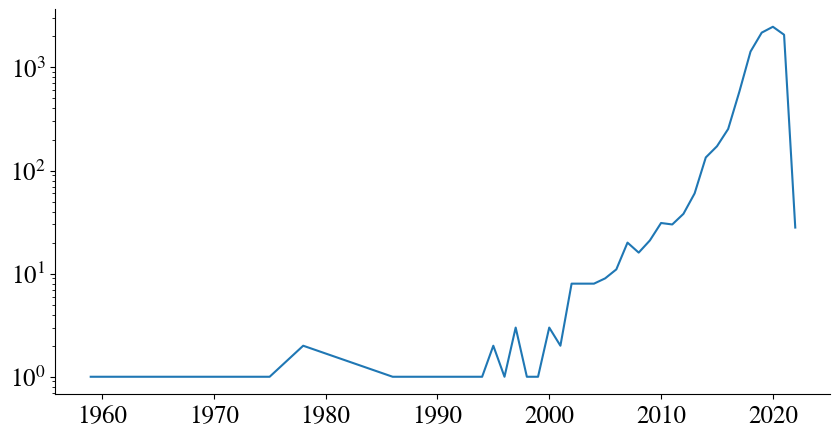

In [933]:
all_papers_df.loc[(all_papers_df.clusters_lev2 == 8)].year.value_counts().sort_index().plot()
plt.yscale("log")

In [434]:
keywords_clusters[2][15]

'money\nrisk\ninvestment\nalgorithm'

In [ ]:
all_papers_df.loc[(all_papers_df.clusters_lev2.isin([8]))].sort_values("year",ascending=True)#.iloc[1]

In [554]:
def find_citations_paper(paper_id):
    
    return all_papers_df.loc[all_papers_df.id.isin(all_docs_dict[paper_id]['inCitations'])].clusters_lev2.value_counts()

In [555]:
find_citations_paper("63a9681663778913982f8f028e170be5ff36f532")

8    39
Name: clusters_lev2, dtype: int64

In [562]:
all_papers_df.loc[all_papers_df.id.isin(all_docs_dict["63a9681663778913982f8f028e170be5ff36f532"]['inCitations'])].iloc[0]#title#.iloc[15]#.abstract#title

title                Measuring Decentrality in Blockchain Based Sys...
abstract             Blockchain promises to provide a distributed a...
fields                                              [Computer Science]
year                                                            2020.0
doi                        https://doi.org/10.1109/ACCESS.2020.3026577
clusters_lev2                                                        8
clusters_lev3                                                        6
clusters_lev4                                                        0
clusters_lev5                                                        0
citations_overall                                                    3
in_degree                                                          3.0
eigenvector                                                        0.0
betweenness                                                   0.000001
closeness                                                      0.13361
pagera

In [576]:
t=x.loc[(x.cluster_to == 8)&(x.knowledge_flow>0)&(x.cluster_from!=x.cluster_to)].copy()
z = t.apply(lambda x:find_kf_important_paper(x['cluster_from'],x['cluster_to'],x['year_from'],x['year_to']),axis=1)
t[['paper_id','kf']] = z.to_list()
t['title'] = t.paper_id.apply(lambda x:all_docs_dict[x]['title'])

In [577]:
t[t.knowledge_flow > 2]#.cluster_from.value_counts()

year_from  year_to  cluster_from  cluster_to  knowledge_flow  \
5954523         1961     2021             1           8        5.750000   
5955237         1974     2020             1           8        7.333333   
5955711         1985     2021             1           8        9.213115   
5955884         1990     2019             1           8        3.468750   
5955886         1990     2021             1           8        6.937500   
...              ...      ...           ...         ...             ...   
117510512       2017     2022             7           8        6.929932   
117510513       2018     2018             7           8        4.631432   
117510514       2018     2019             7           8        3.830147   
117510515       2018     2020             7           8        2.495387   
117510516       2018     2021             7           8        2.543551   

           within_branch_lev_3                                  paper_id  \
5954523                      0  39f07f510f86843935c116f0caa748ffd9d929ac   
5955237                      0  c2e64671a368079b0ffe8a73a3b0ffef673efd27   
5955711                      0  bd8d709da89cec78624e3d0b9d065a9b8f028135   
5955884                      0  30ed7026c21e34dee1a901bd2c8f55c22ea0ae3d   
5955886                      0  ea0395884143c59f0deb329b9a2a45f5a9ebcadd   
...                        ...                                       ...   
117510512                    0  57d6de06108aab568915c1590b2fc114947cd35c   
117510513                    0  9978f6a9ff6ebbbf6cf134ea9324da6271f3e07d   
117510514                    0  9978f6a9ff6ebbbf6cf134ea9324da6271f3e07d   
117510515                    0  9978f6a9ff6ebbbf6cf134ea9324da6271f3e07d   
117510516                    0  9978f6a9ff6ebbbf6cf134ea9324da6271f3e07d   

             kf                                              title  
5954523     1.0  The Concept of Centralization and Decentraliza...  
5955237     1.0                       Economic theory of democracy  
5955711     1.0         Assistance to the Poor in a Federal System  
5955884     1.0  Democratizing France: The Political and Admini...  
5955886     1.0  Government Spending in a Simple Model of Endog...  
...         ...                                                ...  
117510512   1.0  A blockchain-based smart grid: towards sustain...  
117510513  17.0  Security and Privacy in Decentralized Energy T...  
117510514  45.0  Security and Privacy in Decentralized Energy T...  
117510515  38.0  Security and Privacy in Decentralized Energy T...  
117510516  26.0  Security and Privacy in Decentralized Energy T...  

[486 rows x 9 columns]

In [548]:
t[(t.cluster_from.isin([5]))&(t.knowledge_flow>=2)].title.value_counts()

Centrality in social networks conceptual clarification                                                                  4
Diffusion of Innovations                                                                                                3
Centralized versus decentralized computing: organizational considerations and management options                        3
P2P and the promise of internet equality                                                                                3
Social Networks and Collective Action: A Theory of the Critical Mass. III                                               2
Structure in 5's: A Synthesis of the Research on Organization Design                                                    2
Decentralization, Hierarchies, and Incentives: A Mechanism Design Perspective                                           2
Information Production and Capital Allocation: Decentralized vs. Hierarchical Firms                                     1
An Empirically Derived T

In [464]:
t[(t.knowledge_flow>=2)].title.value_counts().iloc[:20]

The Sybil Attack                                                                                                             12
Identity-Based Cryptosystems and Signature Schemes                                                                            9
Decentralized trust management                                                                                                8
Pastry: Scalable, Decentralized Object Location, and Routing for Large-Scale Peer-to-Peer Systems                             7
S/Kademlia: A practicable approach towards secure key-based routing                                                           5
Efficient decentralized consensus protocols                                                                                   5
Design patterns: elements of reuseable object-oriented software                                                               5
On Distributed Communications Networks                                                                  

In [475]:
t.loc[(t.within_branch_lev_3 == 0)&(t.knowledge_flow>2)].groupby("cluster_from").title.value_counts()#[1]

cluster_from  title                                                                                                                                 
1             Governance without government? Rethinking public administration                                                                           2
              Assistance to the Poor in a Federal System                                                                                                1
              Decentralization briefing notes                                                                                                           1
              Decentralization: Conceptualization and measurement                                                                                       1
              Definitions and Typologies in Public Administration Research: The Case of Decentralization                                                1
                                                                                 

### 2008-2014 influenced by

### Print level 1 clusters

LEVEL 2 - CLUSTER 8



/tmp/ipykernel_19651/2242581569.py:390: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=rect)


50 MOST FREQUENT WORDS IN THE TOPICS ----> ['blockchain', 'smart', 'iot', 'privacy', 'bitcoin', 'secure', 'internet', 'digital', 'sharing', 'things', 'applications', 'contracts', 'blockchains', 'ethereum', 'trust', 'authentication', 'storage', 'identity', 'preserving', 'ledger', 'proof', 'enabled', 'computing', 'cryptocurrency', 'transaction', 'edge', 'payment', 'cryptocurrencies', 'new', 'trusted', 'tracing', 'industry', 'key', 'currency', 'securing', 'private', 'contact', 'anonymous', 'transactions', 'vehicular', 'intelligent', 'lightweight', 'ecosystem', 'crypto', 'integrity', 'hyperledger', 'devices', 'verifiable', 'permissioned', 'personal'] 

---> TOPIC 47		normalized mixture proportion = 1.6931		mixture proportion = 0.0104
	56 WORDS - virtual - bitcoin - incentive - transaction - route - payment - pre - cryptocurrency - currency - transactions - cryptocurrencies - fundamental - crypto - cash - compatible - currencies - payments - collusion - assets - coin 

---> TOPIC 13		normal

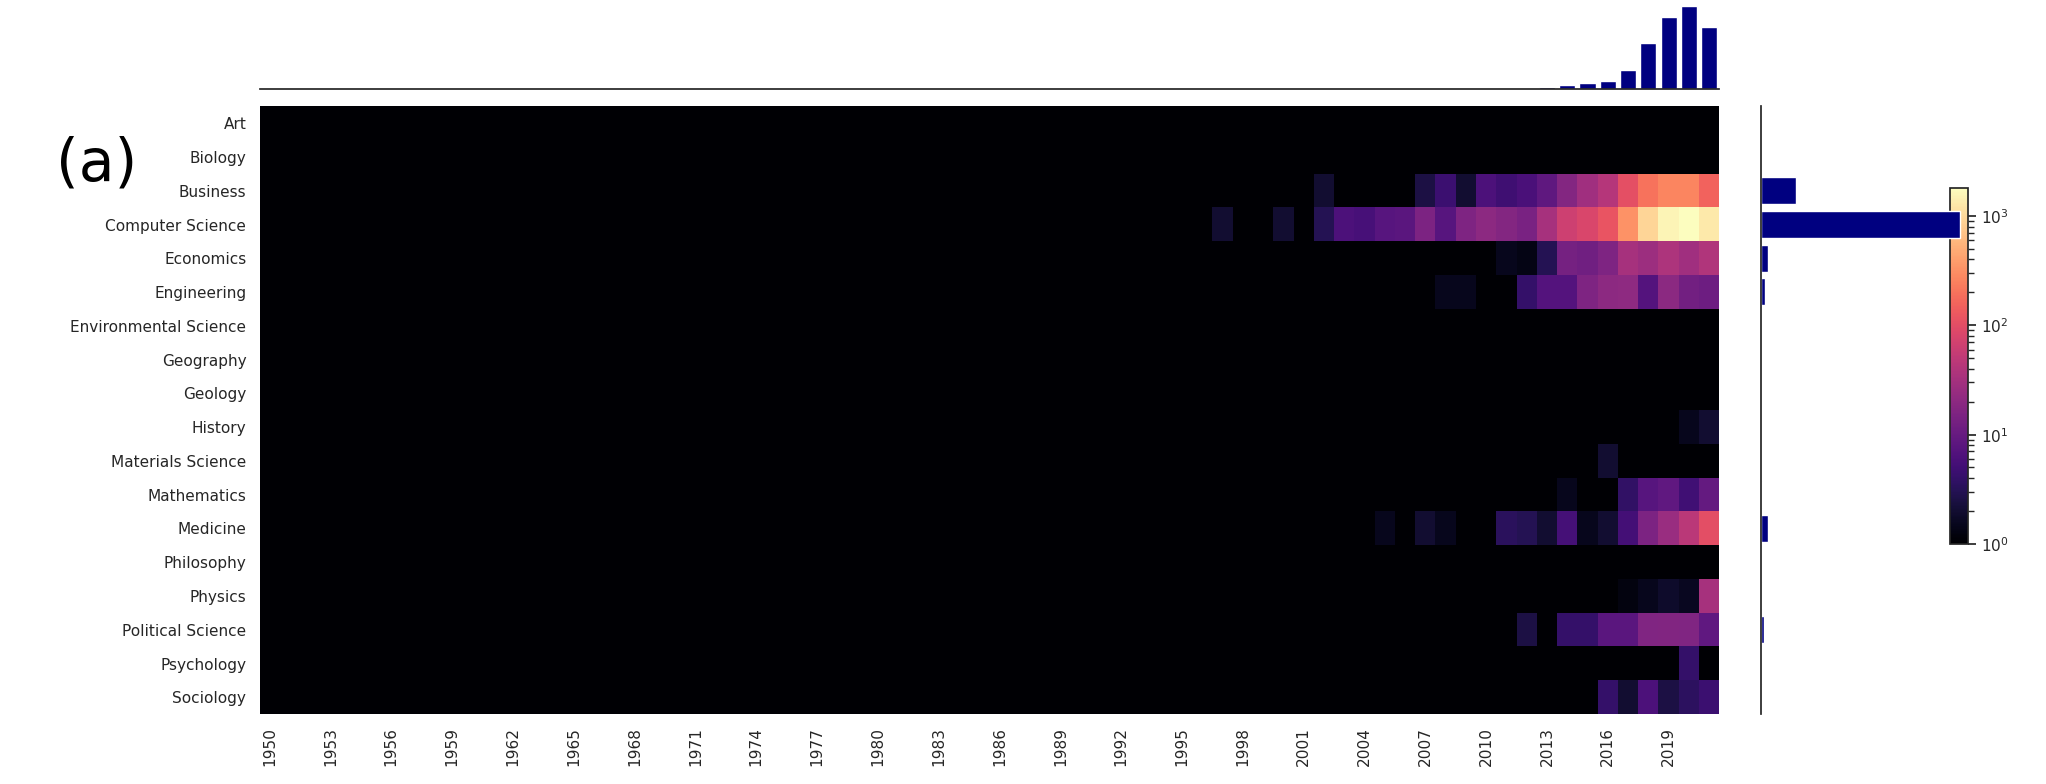

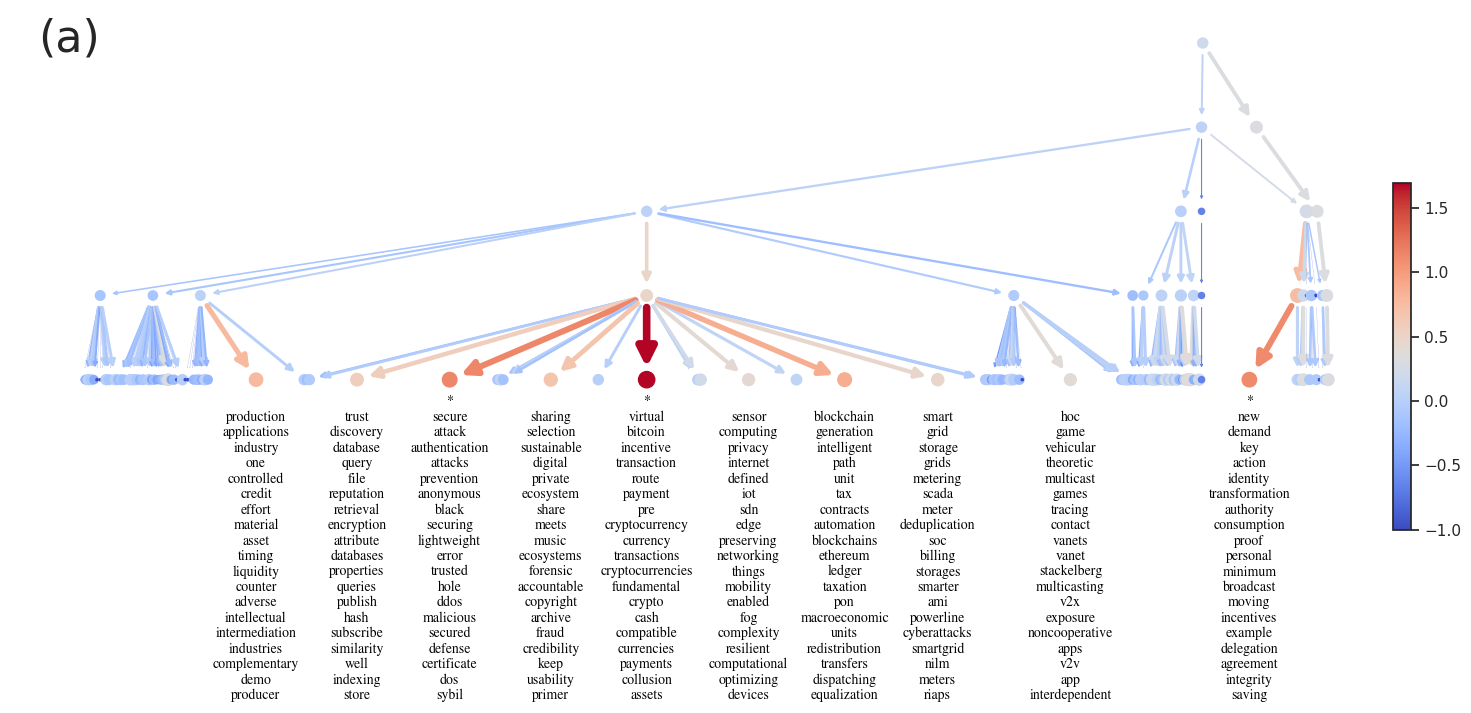

LEVEL 1 - CLUSTER 40



/tmp/ipykernel_19651/2242581569.py:390: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=rect)


50 MOST FREQUENT WORDS IN THE TOPICS ----> ['blockchain', 'bitcoin', 'voting', 'proof', 'secure', 'ethereum', 'blockchains', 'contracts', 'transaction', 'cryptocurrency', 'payment', 'anonymous', 'authentication', 'ledger', 'peer', 'transactions', 'cryptocurrencies', 'identity', 'stake', 'byzantine', 'sharding', 'signature', 'verifiable', 'trusted', 'token', 'p2p', 'pki', 'permissionless', 'signatures', 'anonymity', 'dag', 'lightning', 'payments', 'certificate', 'pow', 'oracle', 'proofs', 'lightweight', 'trustless', 'dns', 'asset', 'cryptography', 'currency', 'permissioned', 'ledgers', 'cash', 'securing', 'name', 'incentives', 'solidity'] 

---> TOPIC 347		normalized mixture proportion = 9.1335		mixture proportion = 0.0101
	30 WORDS - bitcoin - cryptocurrency - currency - cryptocurrencies - fundamental - crypto - currencies - coin - pools - dao - wallet - bitcoins - miner - sentiment - offerings - fintech - libra - wallets - laundering - daos 

---> TOPIC 306		normalized mixture proport

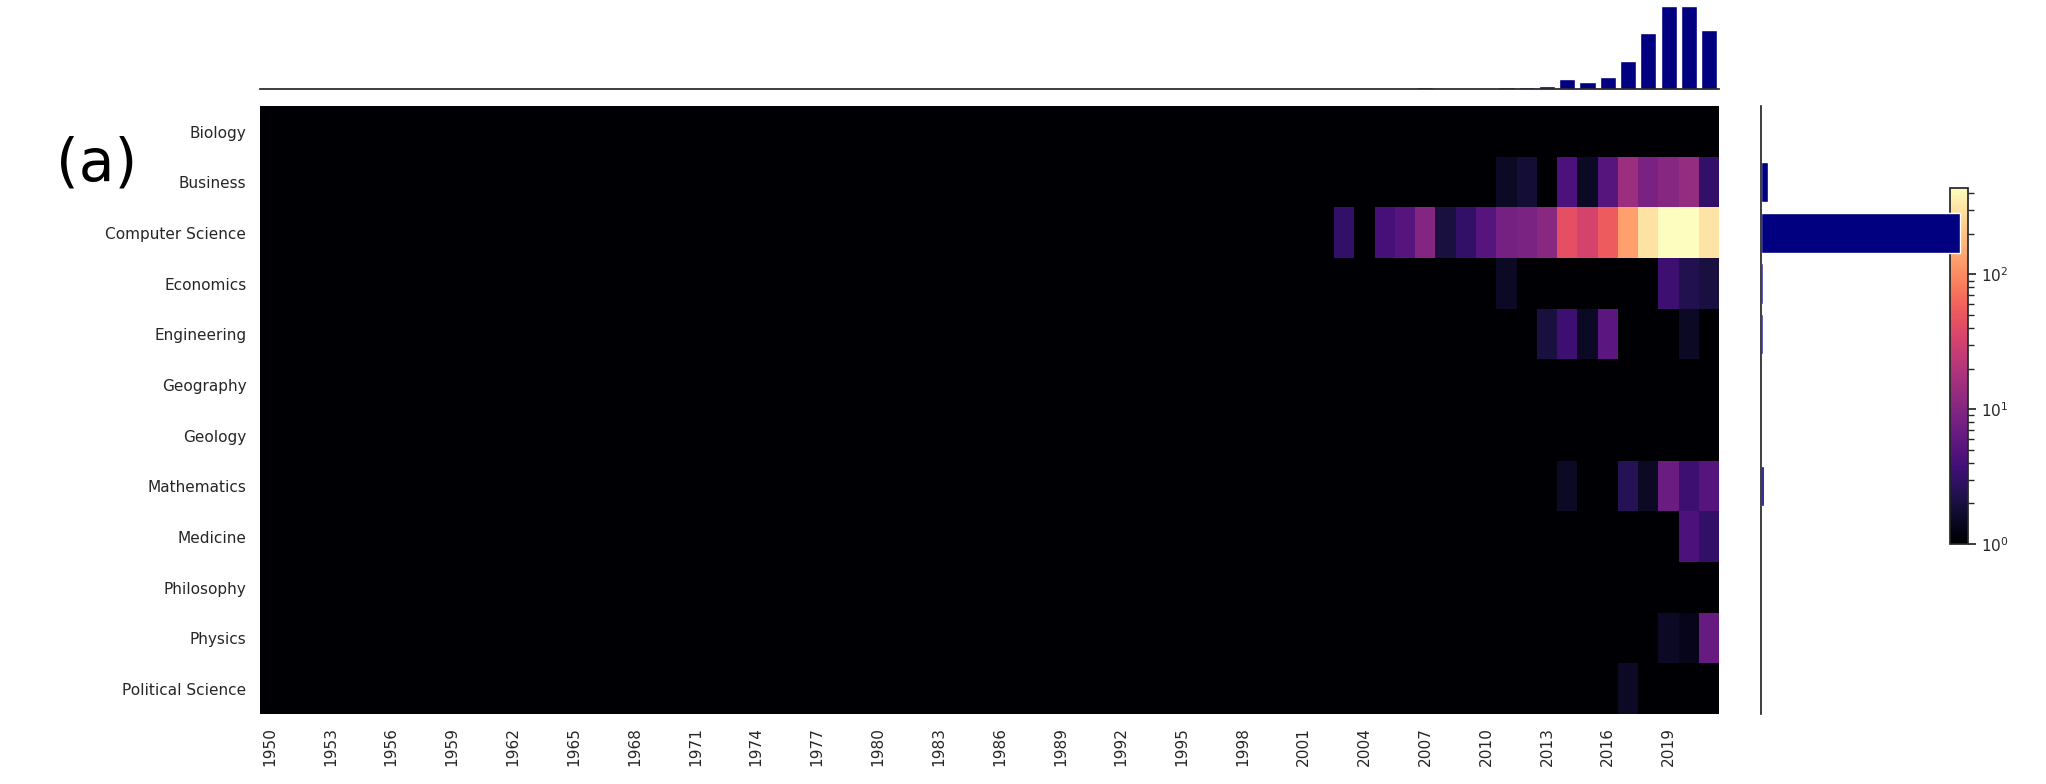

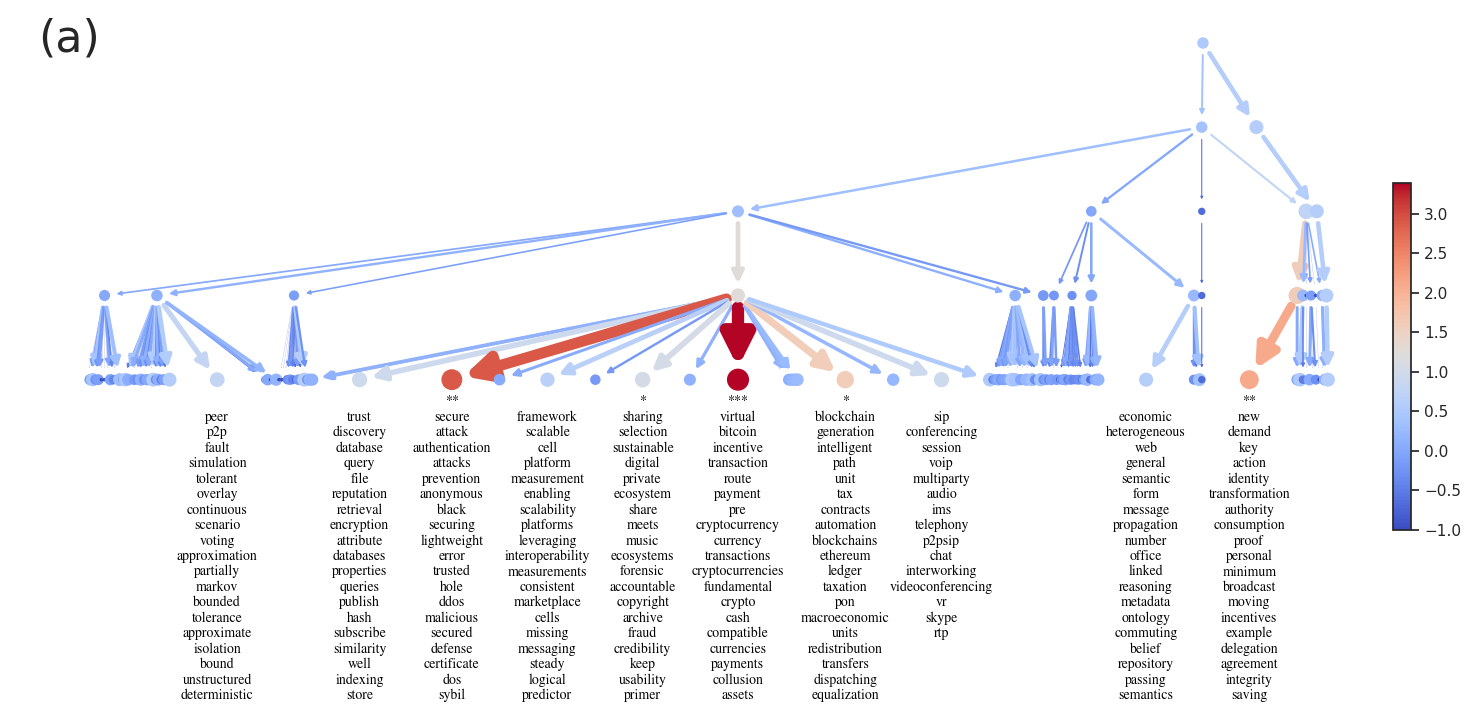

LEVEL 1 - CLUSTER 10



/tmp/ipykernel_19651/2242581569.py:390: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=rect)


50 MOST FREQUENT WORDS IN THE TOPICS ----> ['blockchain', 'identity', 'digital', 'healthcare', 'ledger', 'contracts', 'ethereum', 'secure', 'sovereign', 'blockchains', 'covid', 'hyperledger', 'bitcoin', 'care', 'ecosystem', 'authentication', 'verifiable', 'personal', 'medical', 'credentials', 'transaction', 'payment', 'identifiers', 'proof', 'cryptocurrency', 'permissioned', 'trusted', 'certificate', 'cybersecurity', 'electronic', 'cryptocurrencies', 'transactions', 'preprint', 'credential', 'pandemic', 'identities', 'securing', 'ecosystems', 'record', 'gdpr', 'crowdfunding', 'trustless', 'biometric', 'certificates', 'trustworthy', 'currency', 'ledgers', 'anonymous', 'medicine', 'ipfs'] 

---> TOPIC 306		normalized mixture proportion = 9.5542		mixture proportion = 0.0153
	39 WORDS - blockchain - contracts - blockchains - ethereum - ledger - hyperledger - ipfs - permissioned - cybersecurity - ledgers - trustless - tokens - gdpr - dlt - interplanetary - iota - dapp - immutable - crowdfun

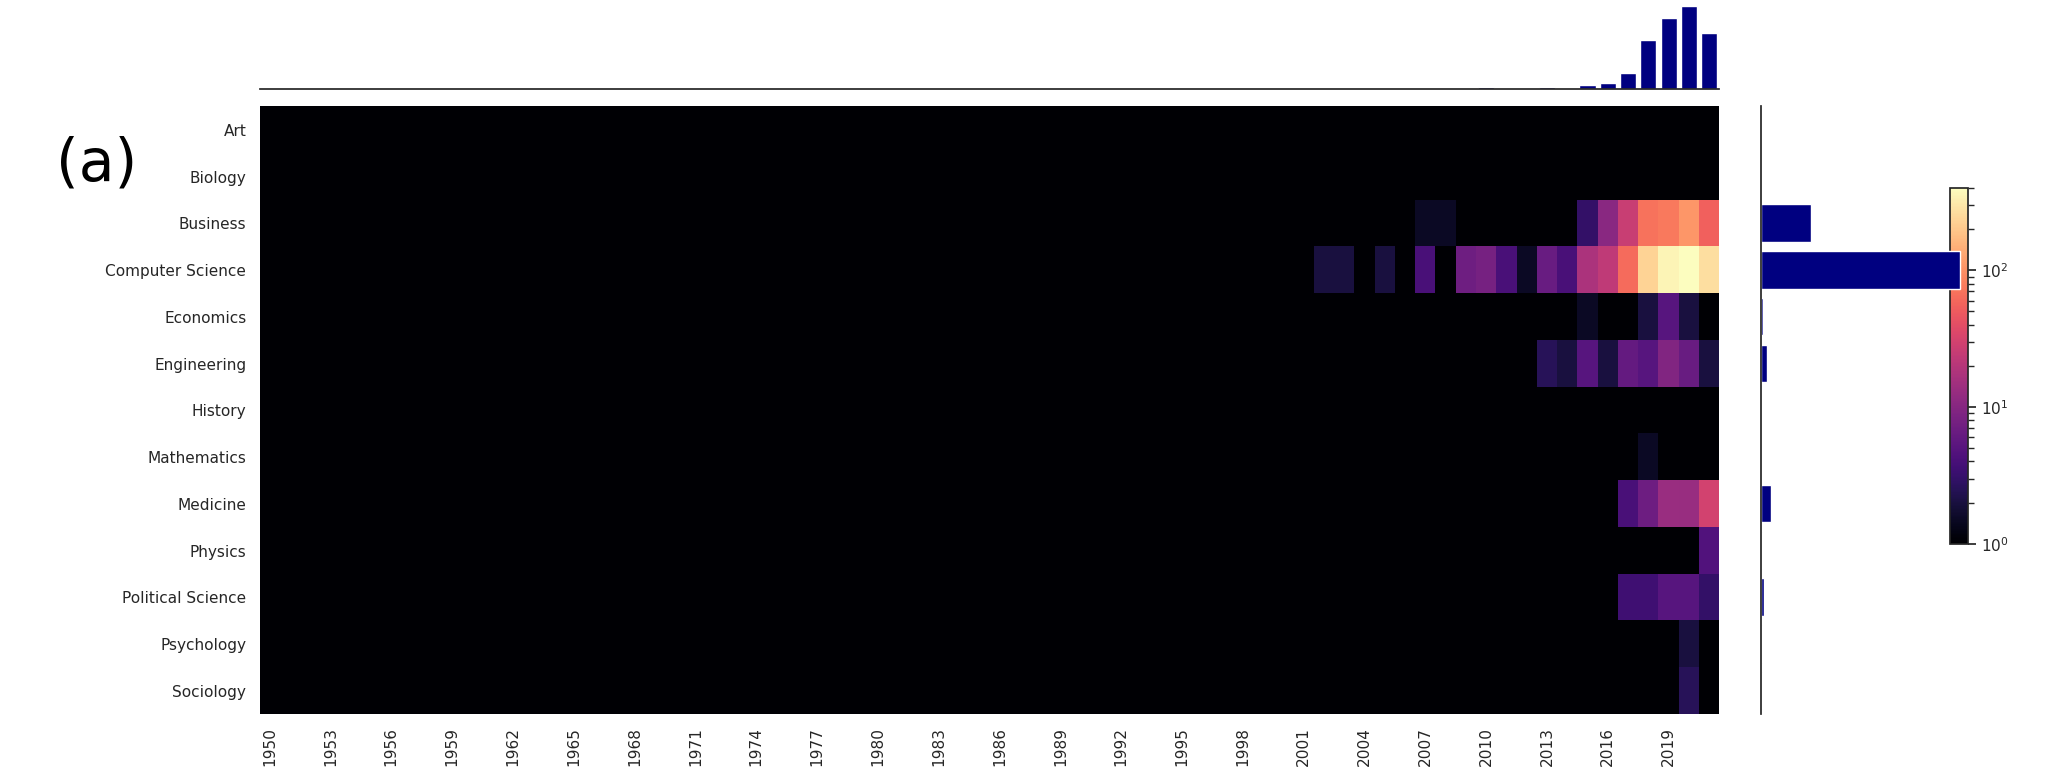

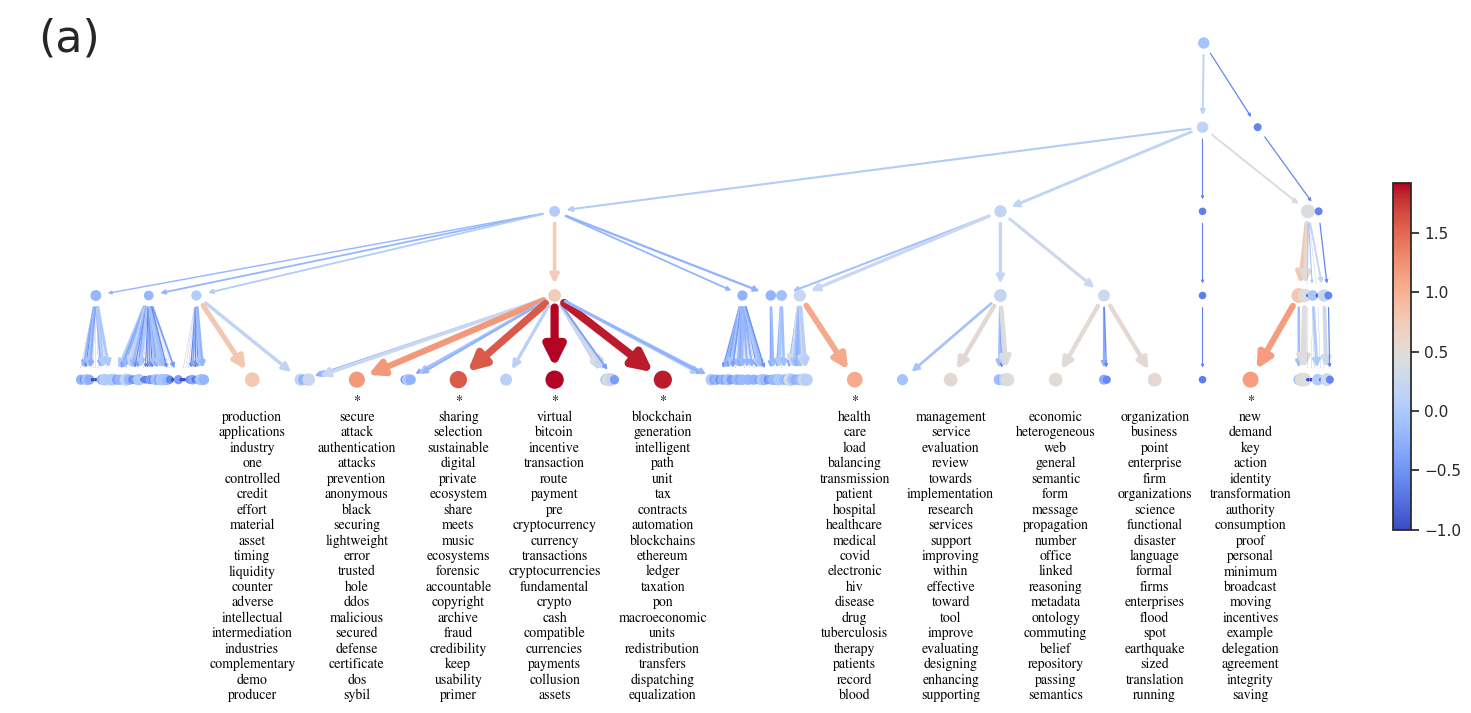

LEVEL 1 - CLUSTER 81



/tmp/ipykernel_19651/2242581569.py:390: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=rect)


50 MOST FREQUENT WORDS IN THE TOPICS ----> ['blockchain', 'healthcare', 'electronic', 'medical', 'record', 'secure', 'food', 'records', 'manufacturing', 'logistics', 'personal', 'agriculture', 'ledger', 'authentication', 'securing', 'ehr', 'hyperledger', 'covid', 'integrity', 'ipfs', 'agri', 'care', 'contracts', 'use', 'signature', 'permissioned', 'traceable', 'trusted', 'secured', 'ethereum', 'provenance', 'emr', 'transaction', 'blockchains', 'hospital', 'ensure', 'iomt', 'medicine', 'trustworthy', 'lightweight', 'biomedical', 'consent', 'medrec', 'ensuring', 'logistic', 'farming', 'encryption', 'attribute', 'cash', 'storing'] 

---> TOPIC 306		normalized mixture proportion = 9.8453		mixture proportion = 0.0157
	39 WORDS - blockchain - contracts - blockchains - ethereum - ledger - hyperledger - ipfs - permissioned - cybersecurity - ledgers - trustless - tokens - gdpr - dlt - interplanetary - iota - dapp - immutable - crowdfunding - incentivized 

---> TOPIC 278		normalized mixture pro

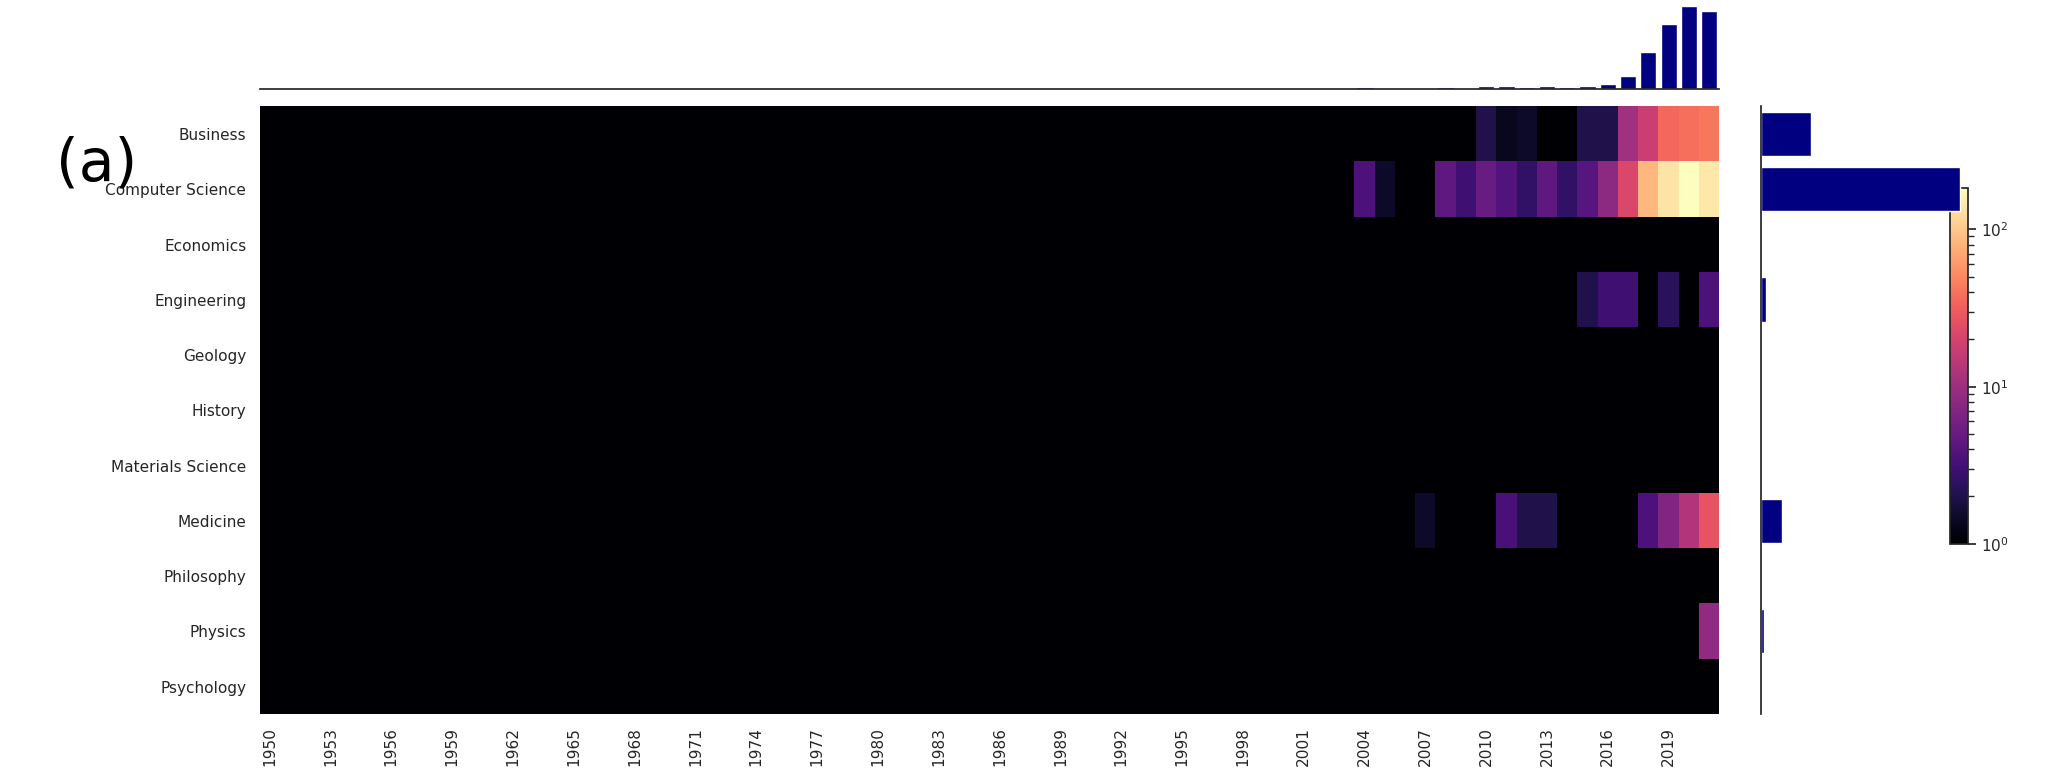

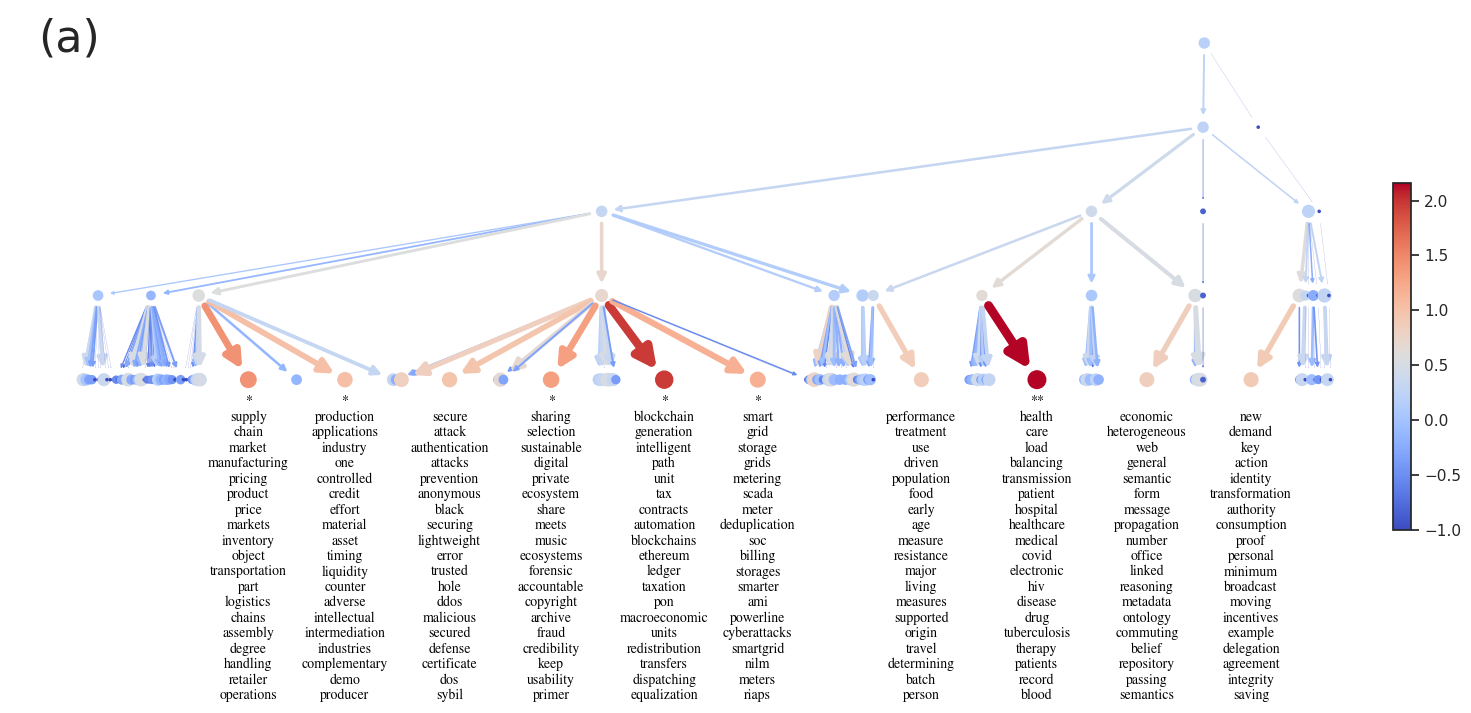

LEVEL 1 - CLUSTER 121



/tmp/ipykernel_19651/2242581569.py:390: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=rect)


50 MOST FREQUENT WORDS IN THE TOPICS ----> ['blockchain', 'iot', 'secure', 'things', 'security', 'cloud', 'authentication', 'edge', 'enabled', 'vehicular', 'fog', 'trusted', 'lightweight', 'ledger', 'devices', 'contracts', 'blockchains', 'securing', 'ipfs', 'integrity', 'ethereum', 'encryption', 'attribute', 'thing', 'trustworthy', 'provenance', 'proof', 'permissioned', 'vanets', 'auditing', 'secured', 'hoc', 'vanet', 'personal', 'anonymous', 'encrypted', '6g', 'empowered', 'hyperledger', 'cybersecurity', 'iov', 'm2m', 'ledgers', 'interplanetary', 'iiot', 'gdpr', 'firmware', 'v2x', 'forensics', 'offloading'] 

---> TOPIC 306		normalized mixture proportion = 10.3373		mixture proportion = 0.0164
	39 WORDS - blockchain - contracts - blockchains - ethereum - ledger - hyperledger - ipfs - permissioned - cybersecurity - ledgers - trustless - tokens - gdpr - dlt - interplanetary - iota - dapp - immutable - crowdfunding - incentivized 

---> TOPIC 154		normalized mixture proportion = 7.0640		m

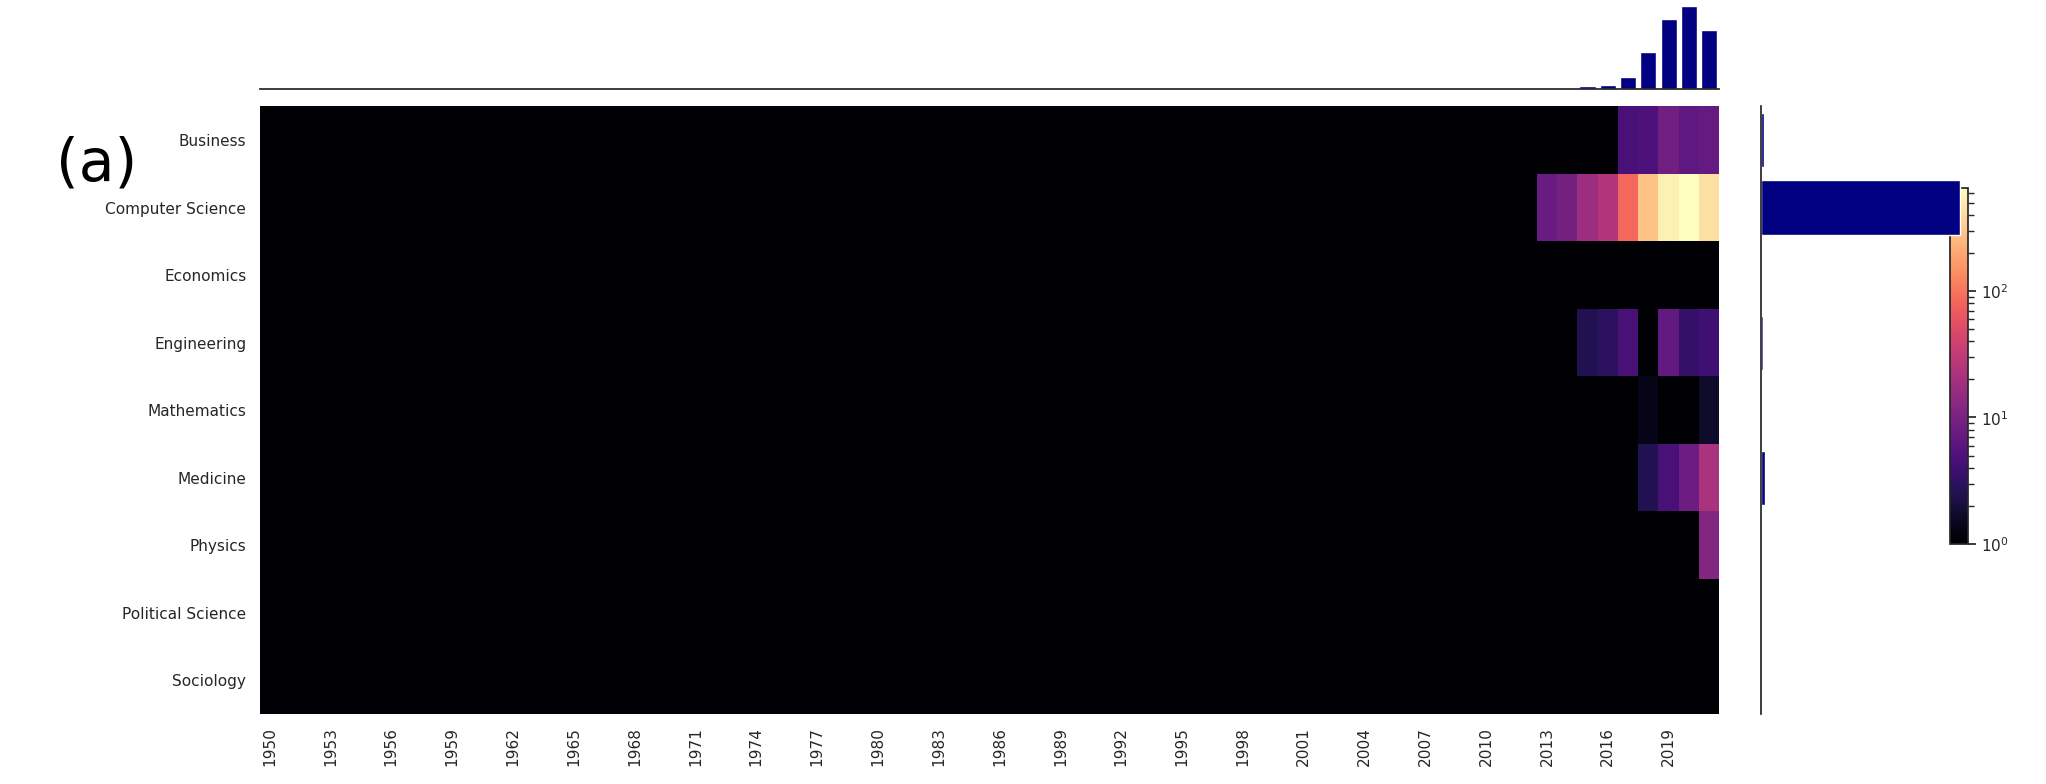

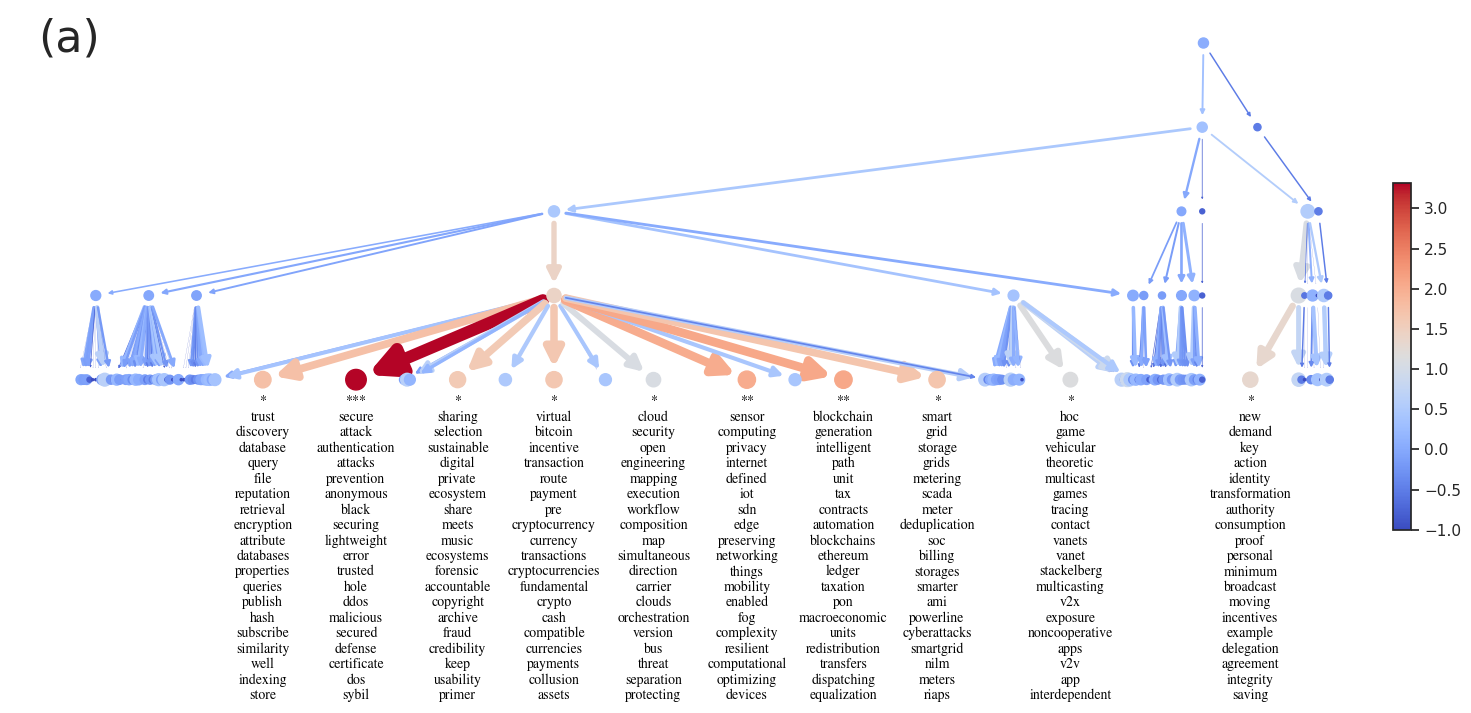

LEVEL 1 - CLUSTER 90



/tmp/ipykernel_19651/2242581569.py:390: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=rect)


50 MOST FREQUENT WORDS IN THE TOPICS ----> ['blockchain', 'bitcoin', 'digital', 'cryptocurrency', 'financial', 'cryptocurrencies', 'currency', 'money', 'finance', 'economy', 'covid', 'crypto', 'defi', 'blockchains', 'currencies', 'payment', 'contracts', 'peer', 'exchanges', 'bank', 'coin', 'economics', 'ecosystem', 'dao', 'ledger', 'token', 'asset', 'transaction', 'banking', 'makers', 'ethereum', 'assets', 'transactions', 'ledgers', 'pandemic', 'stablecoins', 'liquidity', 'tokens', 'payments', 'offerings', 'libra', 'stablecoin', 'volatility', 'economies', 'trustless', 'fintech', 'daos', 'cash', 'miner', 'laundering'] 

---> TOPIC 347		normalized mixture proportion = 10.5665		mixture proportion = 0.0115
	30 WORDS - bitcoin - cryptocurrency - currency - cryptocurrencies - fundamental - crypto - currencies - coin - pools - dao - wallet - bitcoins - miner - sentiment - offerings - fintech - libra - wallets - laundering - daos 

---> TOPIC 306		normalized mixture proportion = 6.0183		mixtur

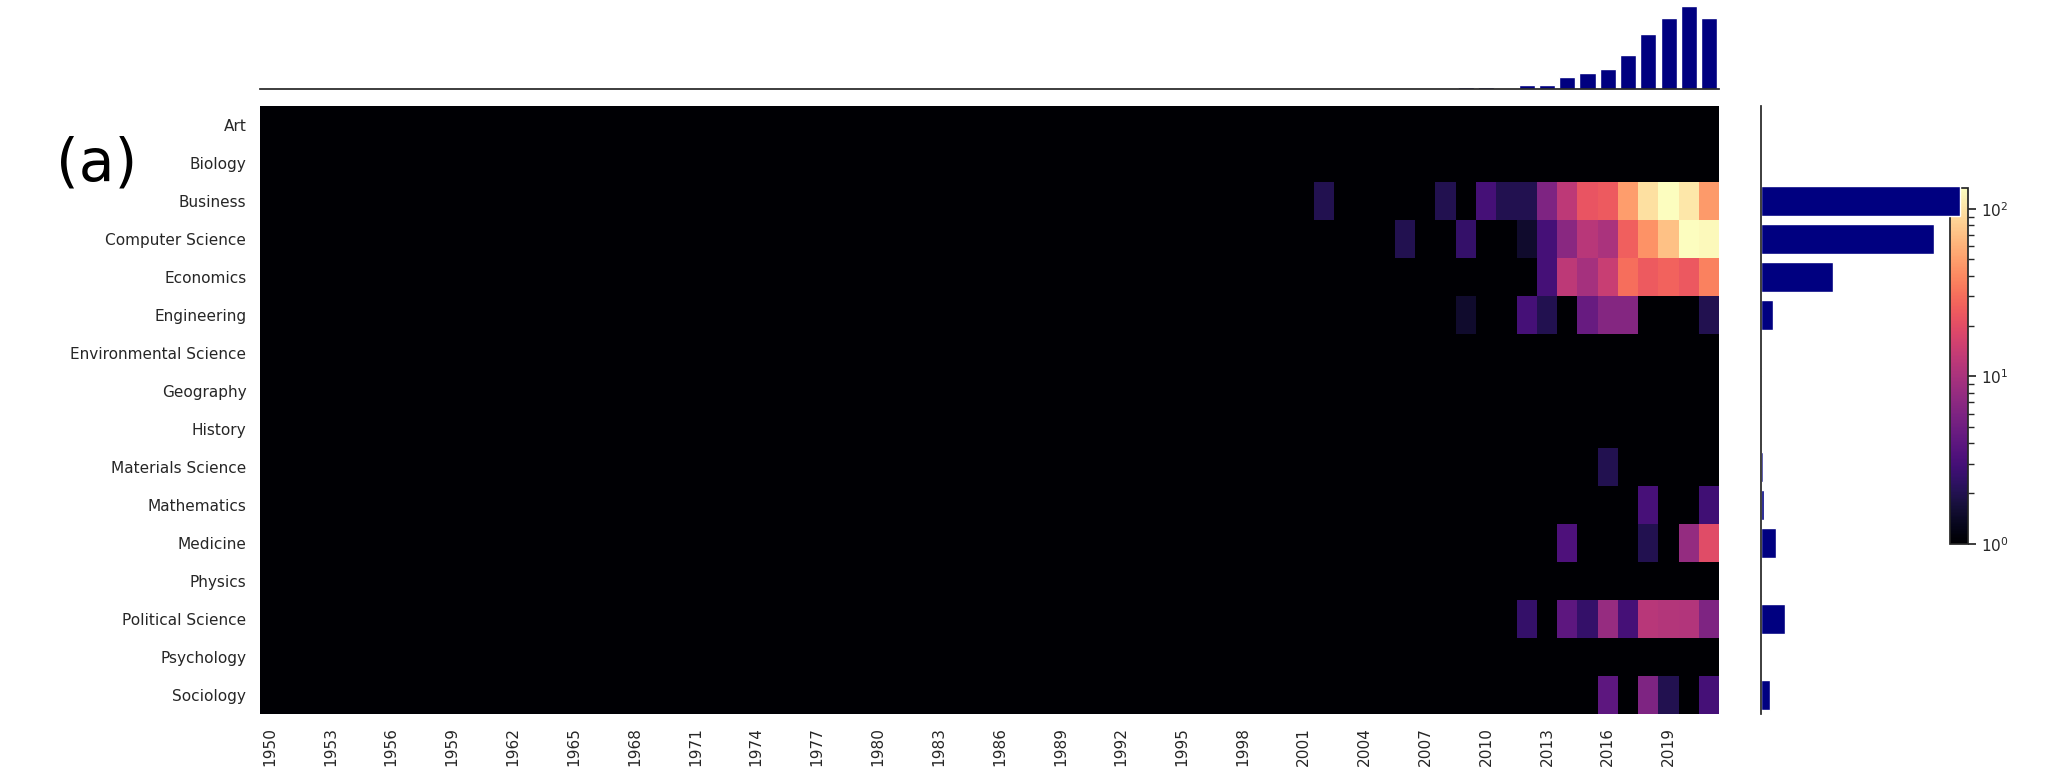

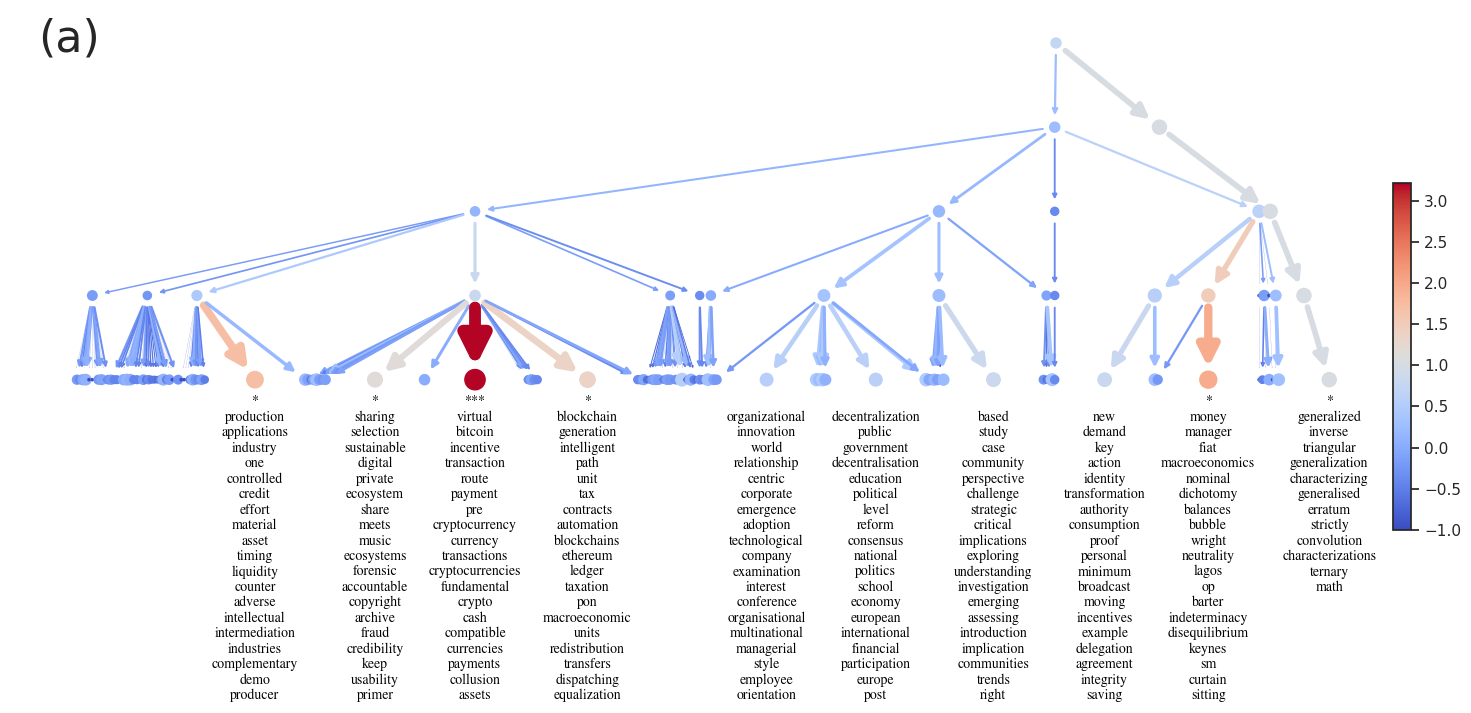

In [584]:
partition = 8
lev = 2
centralities_to_print = ['citations_overall','in_degree','eigenvector','betweenness','closeness','pagerank','katz']

x = analyse_cluster_supernew(lev = lev, top_level_topics=6, bottom_level_topics = 2, partition=partition, centralities_to_print=centralities_to_print, 
                 max_num_topics_to_represent = 10, num_most_frequent_words = 50, num_papers_to_show = 1, do_sample_knowledge_flow = True,
                 multiplicator_size_nodes=50, multiplicator_size_edges=0.04, multiplicator_ypos=0.25, fontsize_graph=10,
                    colorbar_log_heatmap=True)
for child in hierarchy_docs[lev][partition]:
    x = analyse_cluster_supernew(lev = lev-1, top_level_topics=6, bottom_level_topics = 1, partition=child, centralities_to_print=centralities_to_print, 
             max_num_topics_to_represent = 10, num_most_frequent_words = 50, num_papers_to_show = 1, do_sample_knowledge_flow = False,
             multiplicator_size_nodes=50, multiplicator_size_edges=0.04, multiplicator_ypos=0.25, fontsize_graph=10,
                                colorbar_log_heatmap=True, )

### DAOs and DeFi

In [595]:
len(all_papers_df.loc[(all_papers_df.abstract.str.contains(" defi ",case=False))&(all_papers_df.clusters_lev2==8)])

60

In [594]:
len(all_papers_df.loc[(all_papers_df.abstract.str.contains(" dao ",case=False))&(all_papers_df.clusters_lev2==8)])

55

# New Significant KF figures

In [649]:
knowledge_flow_normalized_per_field_per_time_window_to_future_by_level = {}
knowledge_flow_normalized_per_field_in_time_by_level = {}
knowledge_flow_normalized_per_field_per_time_window_by_level = {}
knowledge_flow_normalized_per_field_in_time_to_future_by_level = {}

for lev in [0,1,2,3,4,5]:
    with gzip.open(f"{results_folder}/knowledge_flow_normalized_per_cluster_per_time_window_to_future_df_gt_partition_lev_{lev}.pkl.gz","rb") as fp:
        knowledge_flow_normalized_per_field_per_time_window_to_future_by_level[lev] = pickle.load(fp)
    knowledge_flow_normalized_per_field_in_time_by_level[lev] = pd.read_csv(f"{results_folder}/knowledge_flow_normalized_per_cluster_in_time_df_gt_partition_lev_{lev}.csv")
    knowledge_flow_normalized_per_field_in_time_to_future_by_level[lev] = pd.read_csv(f"{results_folder}/knowledge_flow_normalized_per_cluster_in_time_to_future_df_gt_partition_lev_{lev}.csv.gz")
    with gzip.open(f"{results_folder}/knowledge_flow_normalized_per_cluster_per_time_window_gt_partition_lev_{lev}.pkl.gz","rb") as fp:
        knowledge_flow_normalized_per_field_per_time_window_by_level[lev] = pickle.load(fp)

/tmp/ipykernel_19651/2242581569.py:390: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=rect)


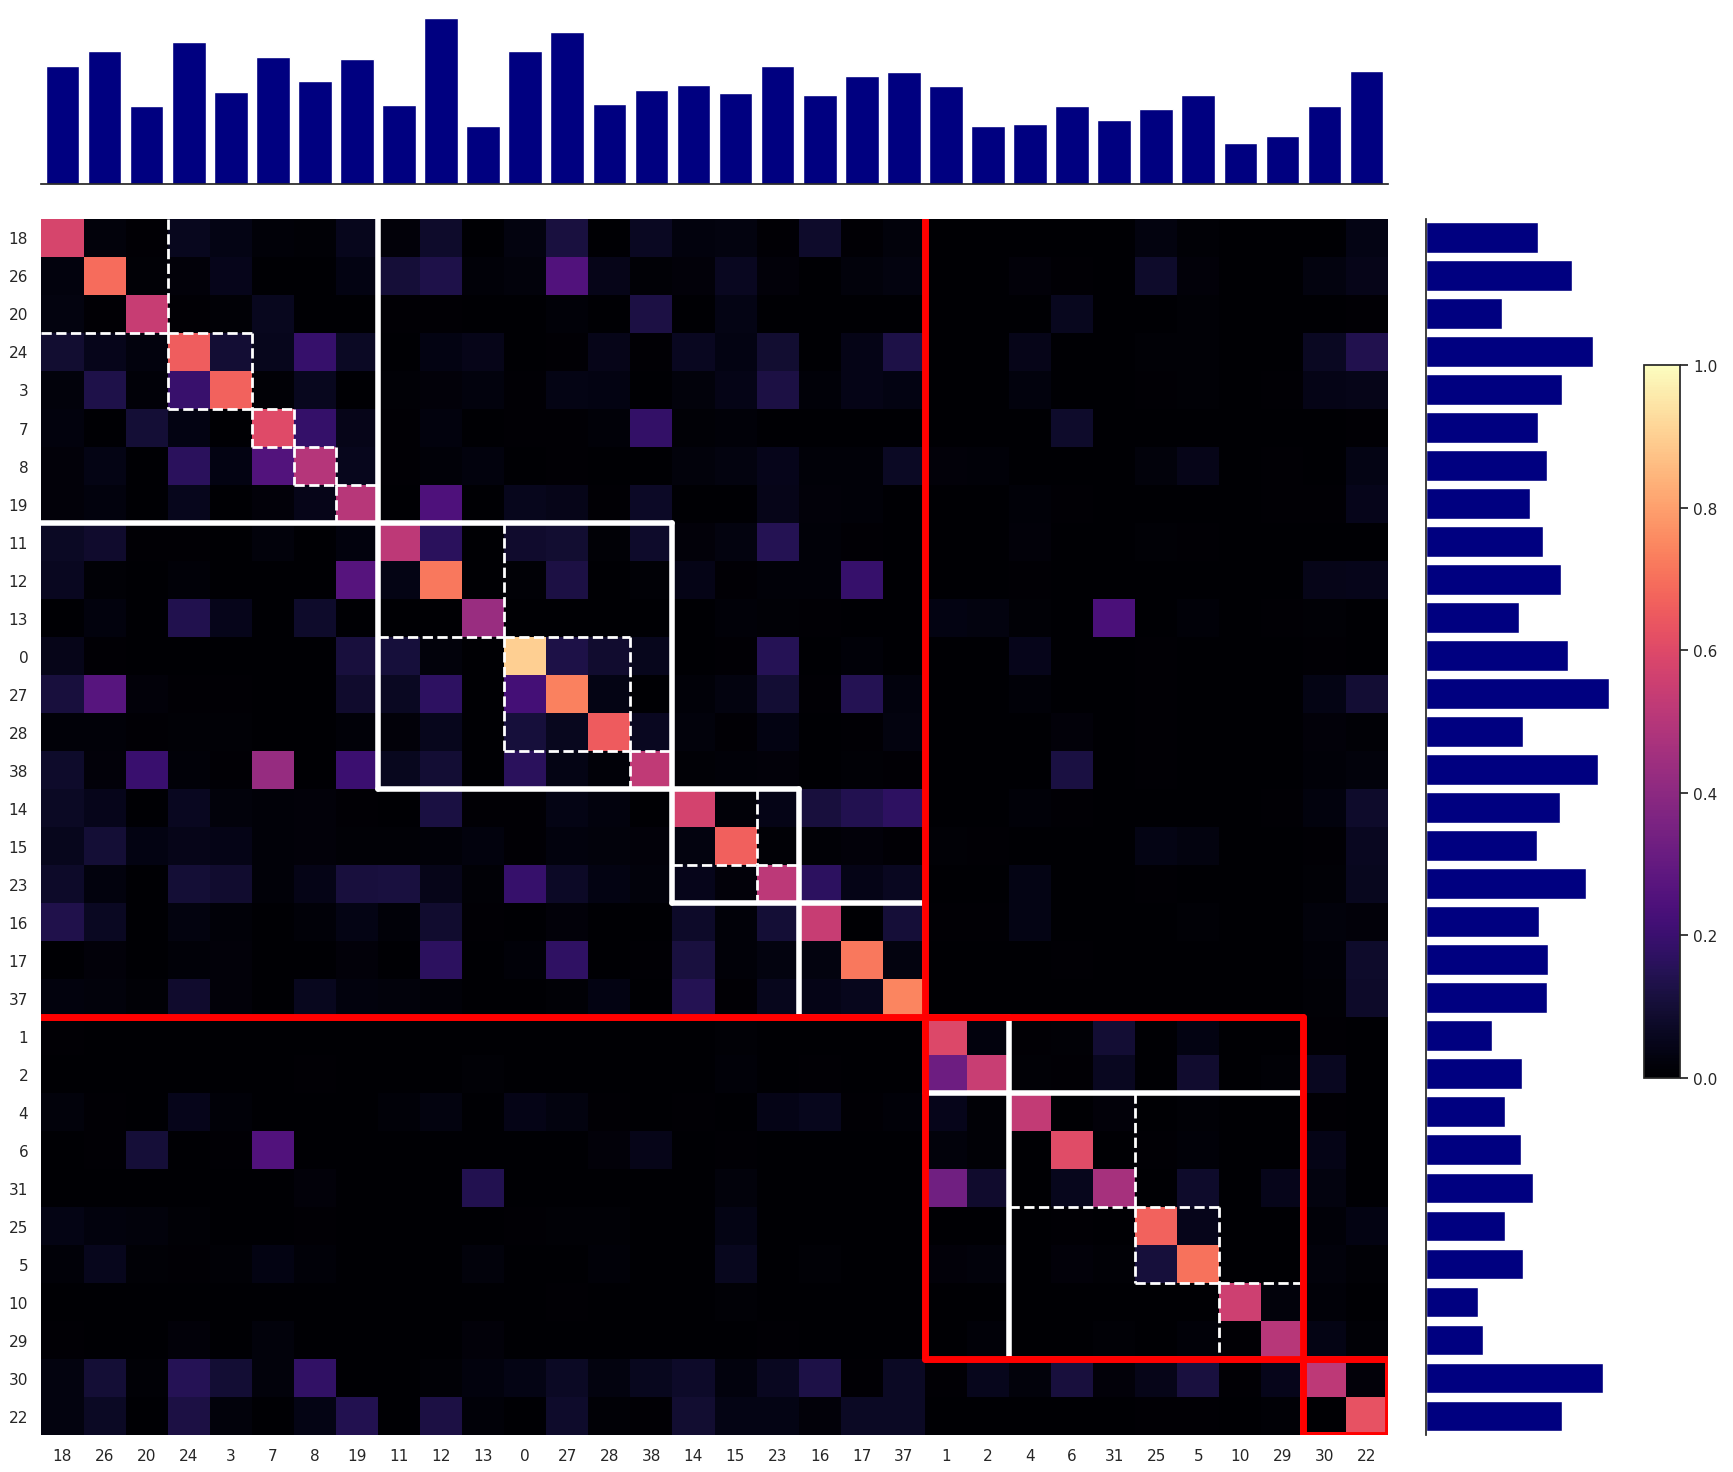

In [678]:
# set(year_cluster_field_no_papers_df.field.unique())
l = 2

tmp = knowledge_flow_normalized_per_field_in_time_to_future_by_level[l].copy()
tmp = tmp.groupby(["cluster_from","cluster_to"],as_index=False).significant_kf.mean()

fig = heatmap(df=tmp, fixed_labels=[], x_label="cluster_from", y_label="cluster_to", values_label="significant_kf", 
        costrains_equal={},figsize=(21,18),
             filename=paper_figures_folder + f"cluster_analysis/heatmaps/heatmap_knowledge_flow_between_clusters_{l}_new.pdf",
             ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=2,
             cut_small_clusters=True,threshold_num_papers=500,vmax=1
             )

/tmp/ipykernel_19651/1075556289.py:392: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_19651/1075556289.py:392: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_19651/1075556289.py:392: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


<AxesSubplot:>

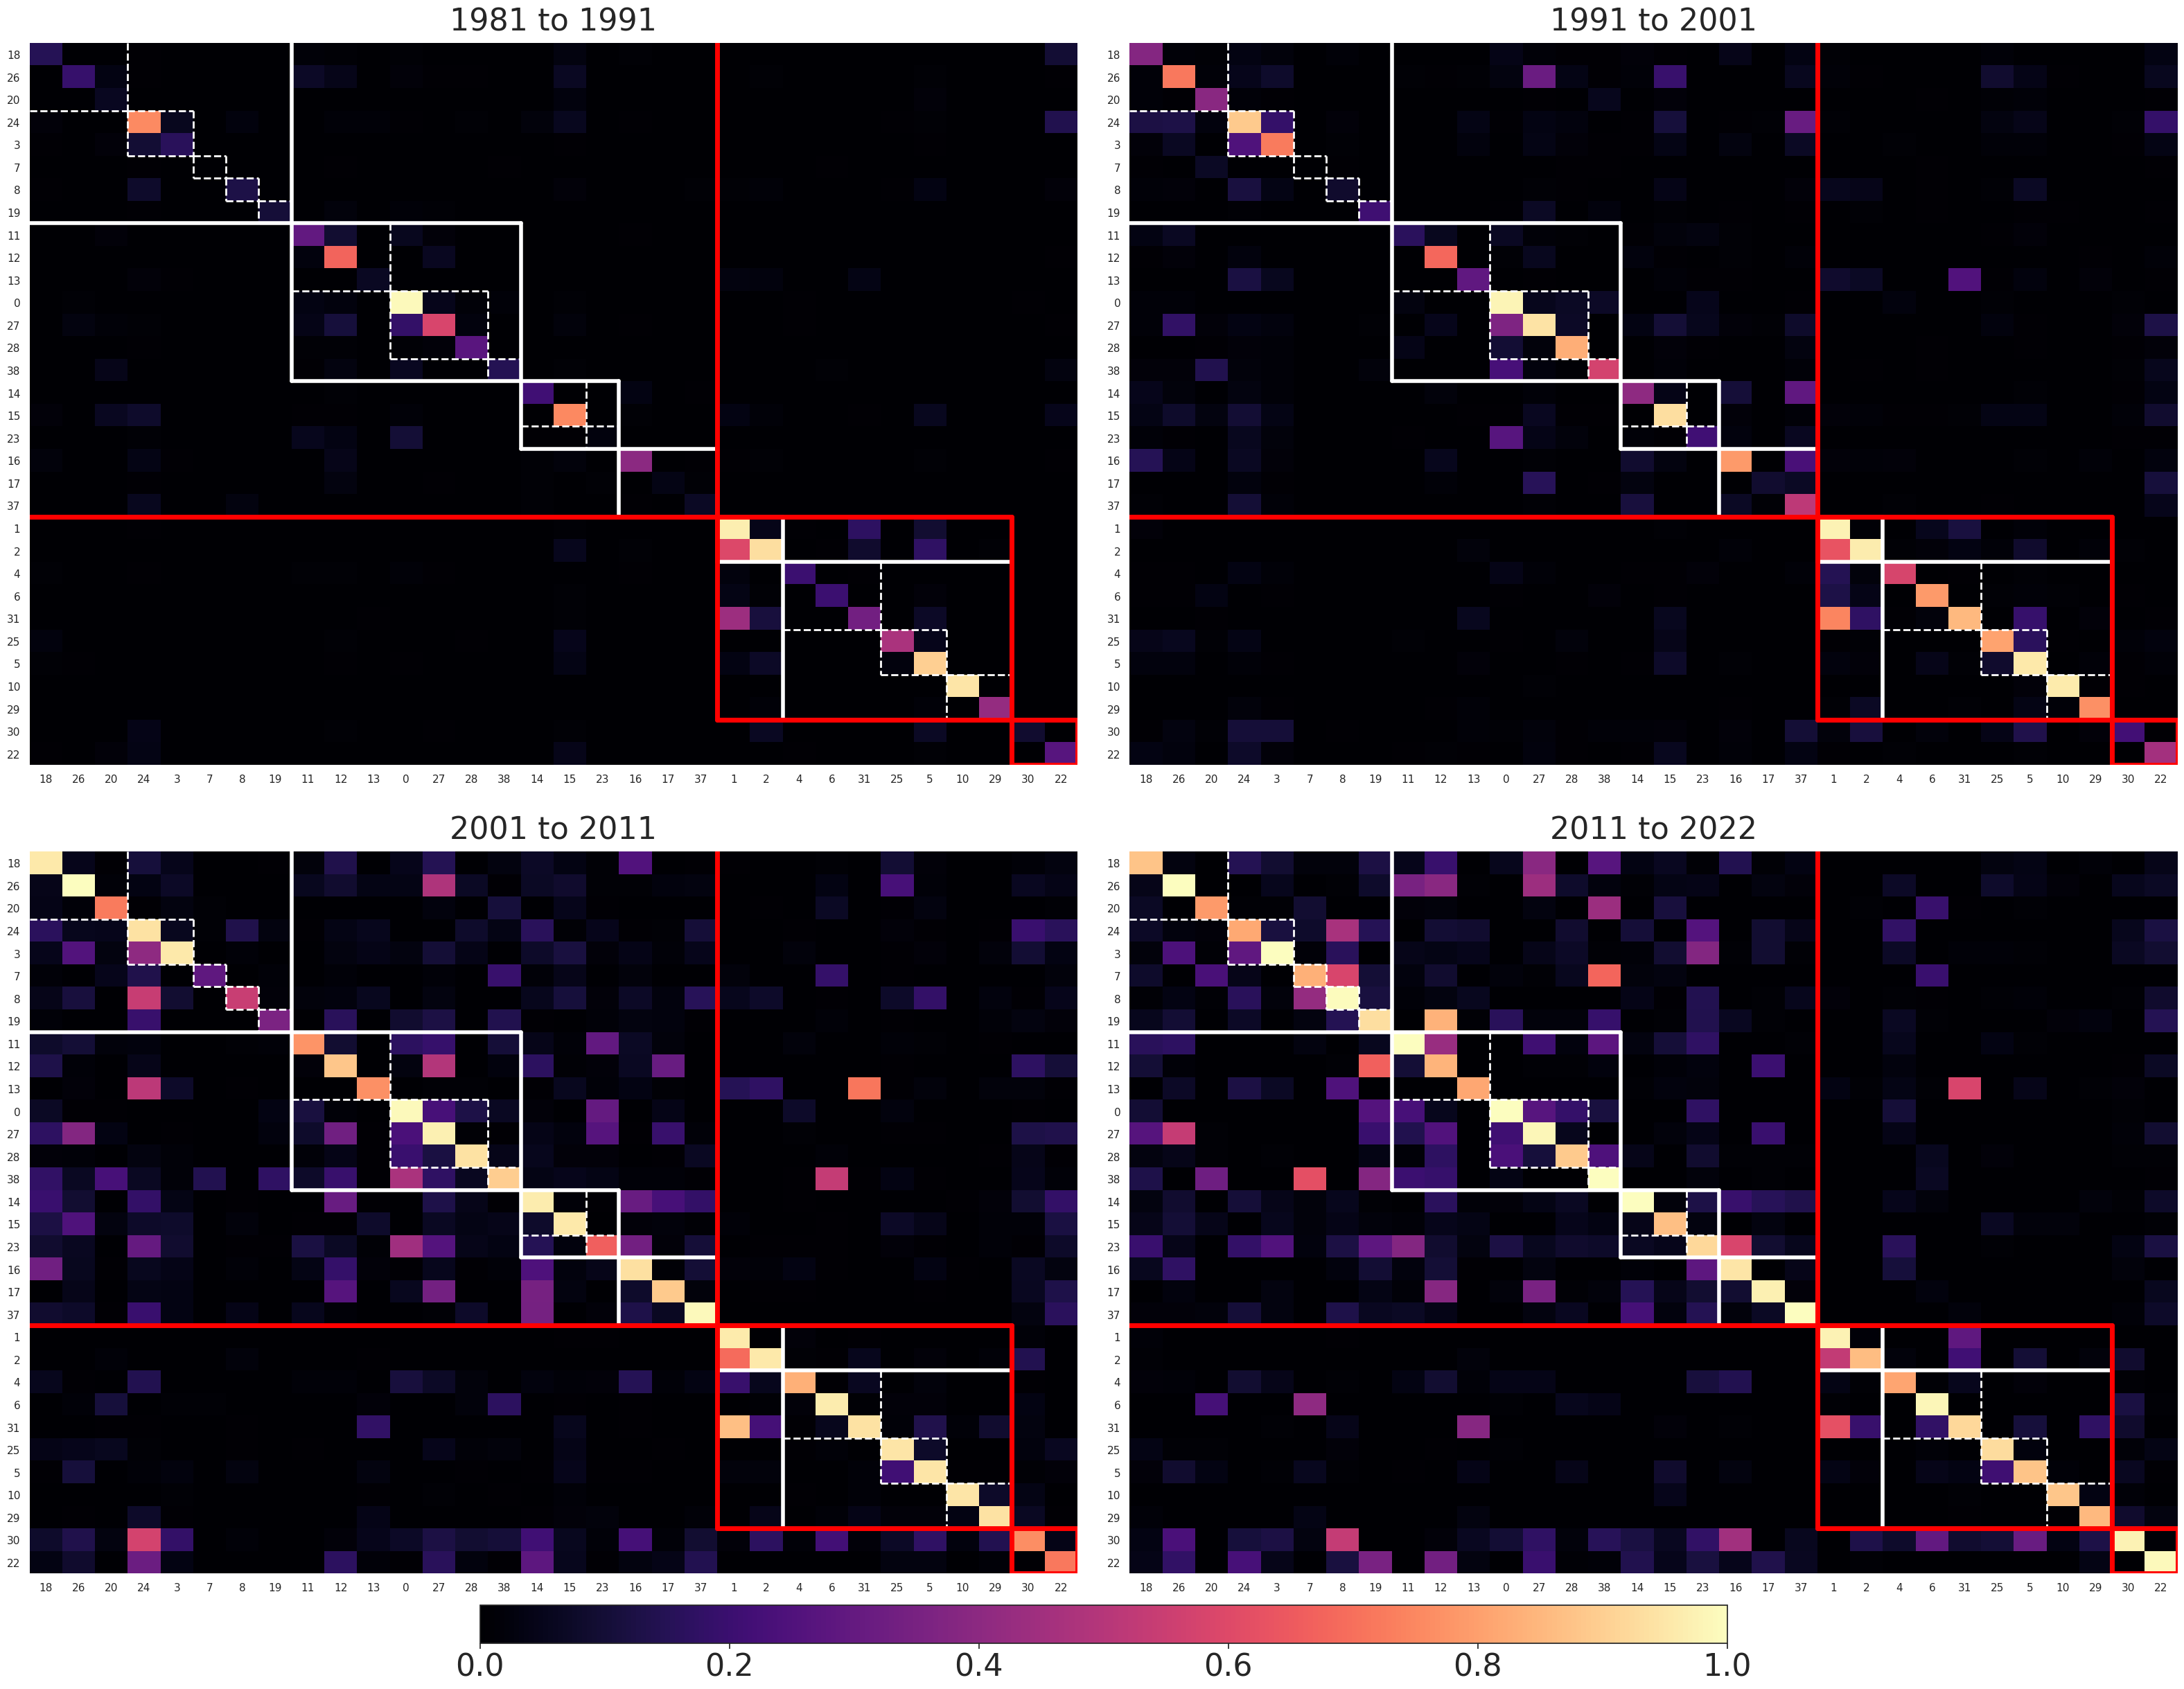

In [689]:
l = 2
fig = plt.figure(figsize=(40,30))
outer = gridspec.GridSpec(nrows=2, ncols=1,height_ratios=[40,1],hspace=0.04)
inner = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outer[0],wspace=0.05,hspace=0.12,)

# for i,(year_from,year_to) in enumerate([(1951,1971),(1971,1991),(1991,2011),(2011,2022)]):
for i,(year_from,year_to) in enumerate([(1981,1991),(1991,2001),(2001,2011),(2011,2022)]):
# for i,(year_from,year_to) in enumerate([(2011,2022)]):
    ax = plt.Subplot(fig, inner[i//2,i%2]) # axes[i//2,i%2]
#     x = tmp_future.copy()
#     x.knowledge_flow = x.knowledge_flow.apply(lambda t:t if t<5 else 5)
#     x = x.loc[tmp_future.year_from.isin(range(year_from,year_to))].groupby(["cluster_from","cluster_to"],as_index=False).knowledge_flow.mean()
#     fig,ax = heatmap(df=x, fixed_labels=[], x_label="cluster_from", y_label="cluster_to", values_label="knowledge_flow", 
#             costrains_equal={},figsize=(21,20),
#                  filename="",
#                  ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=2,
#                  cut_small_clusters=True,threshold_num_papers=500,do_barplot=False,
#                  fig=fig,ax=ax)
#     ax.set_title("%d to %d"%(year_from,year_to),y=1.01,fontsize=32)
#     fig.add_subplot(ax)
    
    tmp = knowledge_flow_normalized_per_field_in_time_to_future_by_level[l].copy()
    tmp = tmp.loc[tmp.year_from.isin(range(year_from,year_to))]
    tmp = tmp.groupby(["cluster_from","cluster_to"],as_index=False).significant_kf.mean()
    
    
    couples = set([tuple(x) for x in tmp[['cluster_from','cluster_to']].values])
    for cluster_f in keywords_clusters[2].keys():
        for cluster_t in keywords_clusters[2].keys():
            if (cluster_f,cluster_t) not in couples:
                tmp.loc[len(tmp)] = [cluster_f,cluster_t,0]
            
    
    fig,ax = heatmap(df=tmp, fixed_labels=[], x_label="cluster_from", y_label="cluster_to", values_label="significant_kf", 
            costrains_equal={},figsize=(21,18),
                 filename=paper_figures_folder + f"cluster_analysis/heatmaps/heatmap_knowledge_flow_between_clusters_{l}_new.pdf",
                 ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=2,
                 cut_small_clusters=True,threshold_num_papers=500,do_barplot=False,fig=fig,ax=ax, vmax=1)
    
    ax.set_title("%d to %d"%(year_from,year_to),y=1.01,fontsize=32)
    fig.add_subplot(ax)

inner = gridspec.GridSpecFromSubplotSpec(1, 3, width_ratios = [1,3,1],
                        subplot_spec=outer[1],wspace=0.05,hspace=0.12,)

ax_cmap = plt.Subplot(fig, inner[1])
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=1), cmap=plt.get_cmap("magma")), cax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation="horizontal")
ax_cmap.tick_params(labelsize=32) 
fig.add_subplot(ax_cmap)
# fig.savefig(paper_figures_folder + f"cluster_analysis/heatmaps/heatmaps_knowledge_flow_between_clusters_over_time_20_years.pdf")

## Figure 2

/home/enterprise.internal.city.ac.uk/aczy350/anaconda3/envs/gt/lib/python3.9/site-packages/matplotlib/patches.py:3024: RuntimeWarning: invalid value encountered in double_scalars
  cos_t, sin_t = head_length / head_dist, head_width / head_dist
/home/enterprise.internal.city.ac.uk/aczy350/anaconda3/envs/gt/lib/python3.9/site-packages/matplotlib/patches.py:3024: RuntimeWarning: invalid value encountered in double_scalars
  cos_t, sin_t = head_length / head_dist, head_width / head_dist


3 [(0, {32, 18, 26, 20}), (3, {24, 3}), (5, {7}), (6, {8, 9}), (12, {33, 19, 21}), (8, {11, 12, 13}), (1, {0, 27, 28}), (18, {38}), (9, {14, 15}), (11, {23}), (15, {35}), (10, {16, 17, 37}), (2, {1, 2}), (4, {4, 6, 31}), (14, {25, 5}), (7, {10, 29}), (20, {40}), (17, {36}), (19, {39}), (13, {30, 22})]
4 [(0, [32, 18, 26, 20, 24, 3, 7, 8, 9, 33, 19, 21]), (1, [11, 12, 13, 0, 27, 28, 38]), (4, [14, 15, 23, 35]), (5, [16, 17, 37]), (2, [1, 2]), (3, [4, 6, 31, 25, 5, 10, 29]), (8, [40]), (6, [36, 39, 30, 22])]
5 [(0, [32, 18, 26, 20, 24, 3, 7, 8, 9, 33, 19, 21, 11, 12, 13, 0, 27, 28, 38, 14, 15, 23, 35, 16, 17, 37]), (1, [1, 2, 4, 6, 31, 25, 5, 10, 29]), (2, [40, 36, 39, 30, 22])]


/tmp/ipykernel_19651/2970442196.py:416: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/home/enterprise.internal.city.ac.uk/aczy350/anaconda3/envs/gt/lib/python3.9/site-packages/matplotlib/patches.py:3024: RuntimeWarning: invalid value encountered in double_scalars
  cos_t, sin_t = head_length / head_dist, head_width / head_dist


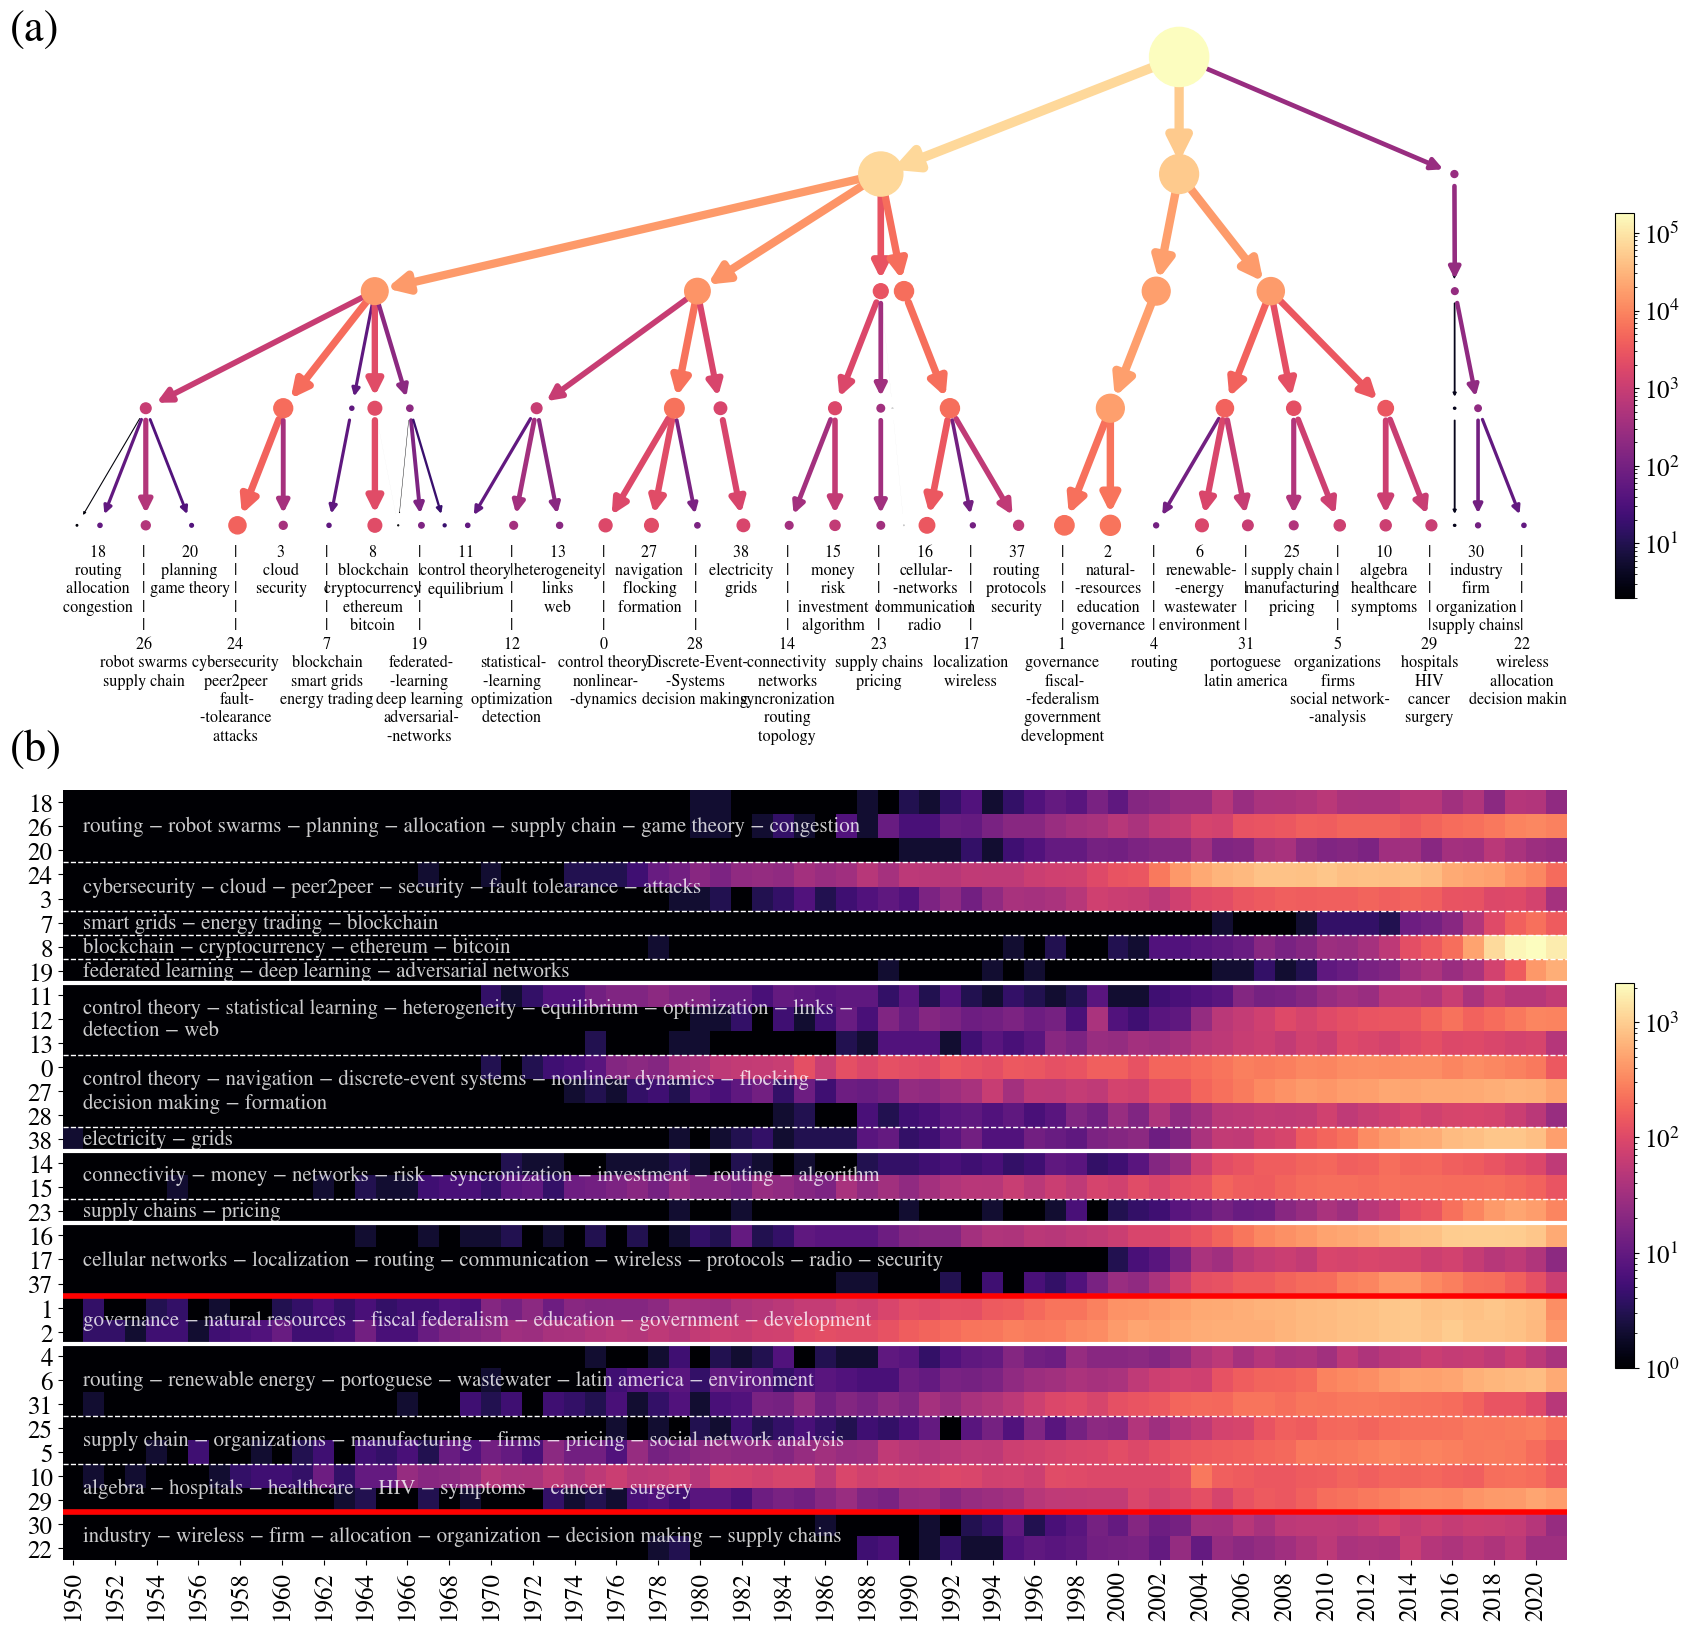

In [935]:
l = 2
year_cluster_log = year_cluster_field_no_papers_df_by_level[l].groupby(["year","cluster"],as_index=False).no_papers.sum()
year_cluster_log["no_papers_log"] = np.log([max(1,_) for _ in year_cluster_log["no_papers"]])

fig,axes = plt.subplots(2,2,figsize=(21,20),gridspec_kw={"hspace":0.0, "height_ratios":[1,1], "width_ratios":[20,1], 'wspace':0.06})

ax = axes[0][0]
pos,vm,vM = create_hierarchy_network_docs(partition=0, top_level=6, bottom_level=2, 
                             max_num_clusters_to_represent=10000, num_words_to_represent=20, 
                             multiplicator_size_nodes=.01, multiplicator_size_edges=1, multiplicator_ypos=0.20,#0.3
                             fontsize = 11.6, ax=ax, fig=fig, threshold_num_papers = 500, num_spaces=1000, 
                            do_barplot=False, number_bars=5)
min_pos = min([x[0] for x in pos.values()])
max_pos = max([x[0] for x in pos.values()])
ax.set_xlim(left = min_pos - (max_pos - min_pos)*0.01,
            right = max_pos*1.03)

ax_cmap = axes[0][1]
fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.LogNorm(vmin=vm,vmax=vM), cmap=plt.get_cmap("magma")), ax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation="vertical") # Normalize
ax_cmap.tick_params(labelsize=20) 
ax_cmap.axis('off')
fig.text(.1, .87, "(a)", fontsize=32, transform=fig.transFigure)



################################################################################################################################################################



ax = axes[1][0]

level2_pos = [(x,y) for x,y in pos.items() if x.split("_")[0]=="2"]
ordered_lev2_clusters_pos = sorted(level2_pos,key = lambda x:x[1][0])
ordered_lev2_clusters = [int(x[0].split("_")[1].split("\n")[0]) for x in ordered_lev2_clusters_pos]


fig, ax = heatmap(df=year_cluster_log, fixed_labels=[], x_label="year", y_label="cluster", values_label="no_papers_log", 
             costrains_equal={"year":set(range(1950,2022))},#figsize=(21,14),
             ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=1,
             cut_small_clusters=True,threshold_num_papers=500,
             bottom_level=l,top_level=6,
             ax=ax,fig=fig,do_barplot=False)
fig.add_subplot(ax)

ax_cmap = axes[1][1]
vmin = np.e**year_cluster_log.no_papers_log.unique().min()
vmax = year_cluster_log.no_papers.unique().max()
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax), cmap=plt.get_cmap("magma")), ax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation="vertical")
ax_cmap.tick_params(labelsize=20) 
ax_cmap.axis('off')
fig.add_subplot(ax_cmap)
fig.text(.1, 0.51, "(b)", fontsize=32, transform=fig.transFigure)

fig.savefig(f"{paper_figures_folder2}Figure2_lev{l}.pdf",bbox_inches='tight')

/home/enterprise.internal.city.ac.uk/aczy350/anaconda3/envs/gt/lib/python3.9/site-packages/matplotlib/patches.py:3024: RuntimeWarning: invalid value encountered in double_scalars
  cos_t, sin_t = head_length / head_dist, head_width / head_dist
/home/enterprise.internal.city.ac.uk/aczy350/anaconda3/envs/gt/lib/python3.9/site-packages/matplotlib/patches.py:3024: RuntimeWarning: invalid value encountered in double_scalars
  cos_t, sin_t = head_length / head_dist, head_width / head_dist


3 [(0, ()), (3, ()), (5, ()), (6, ()), (12, ()), (8, ()), (1, ()), (18, ()), (9, ()), (11, ()), (15, ()), (10, ()), (2, ()), (4, ()), (14, ()), (7, ()), (20, ()), (17, ()), (19, ()), (13, ())]
4 [(0, {0, 3, 5, 6, 12}), (1, {8, 1, 18}), (4, {9, 11, 15}), (5, {10}), (2, {2}), (3, {4, 14, 7}), (8, {20}), (6, {17, 19, 13})]
5 [(0, [0, 3, 5, 6, 12, 8, 1, 18, 9, 11, 15, 10]), (1, [2, 4, 14, 7]), (2, [20, 17, 19, 13])]


/tmp/ipykernel_19651/2970442196.py:416: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/home/enterprise.internal.city.ac.uk/aczy350/anaconda3/envs/gt/lib/python3.9/site-packages/matplotlib/patches.py:3024: RuntimeWarning: invalid value encountered in double_scalars
  cos_t, sin_t = head_length / head_dist, head_width / head_dist


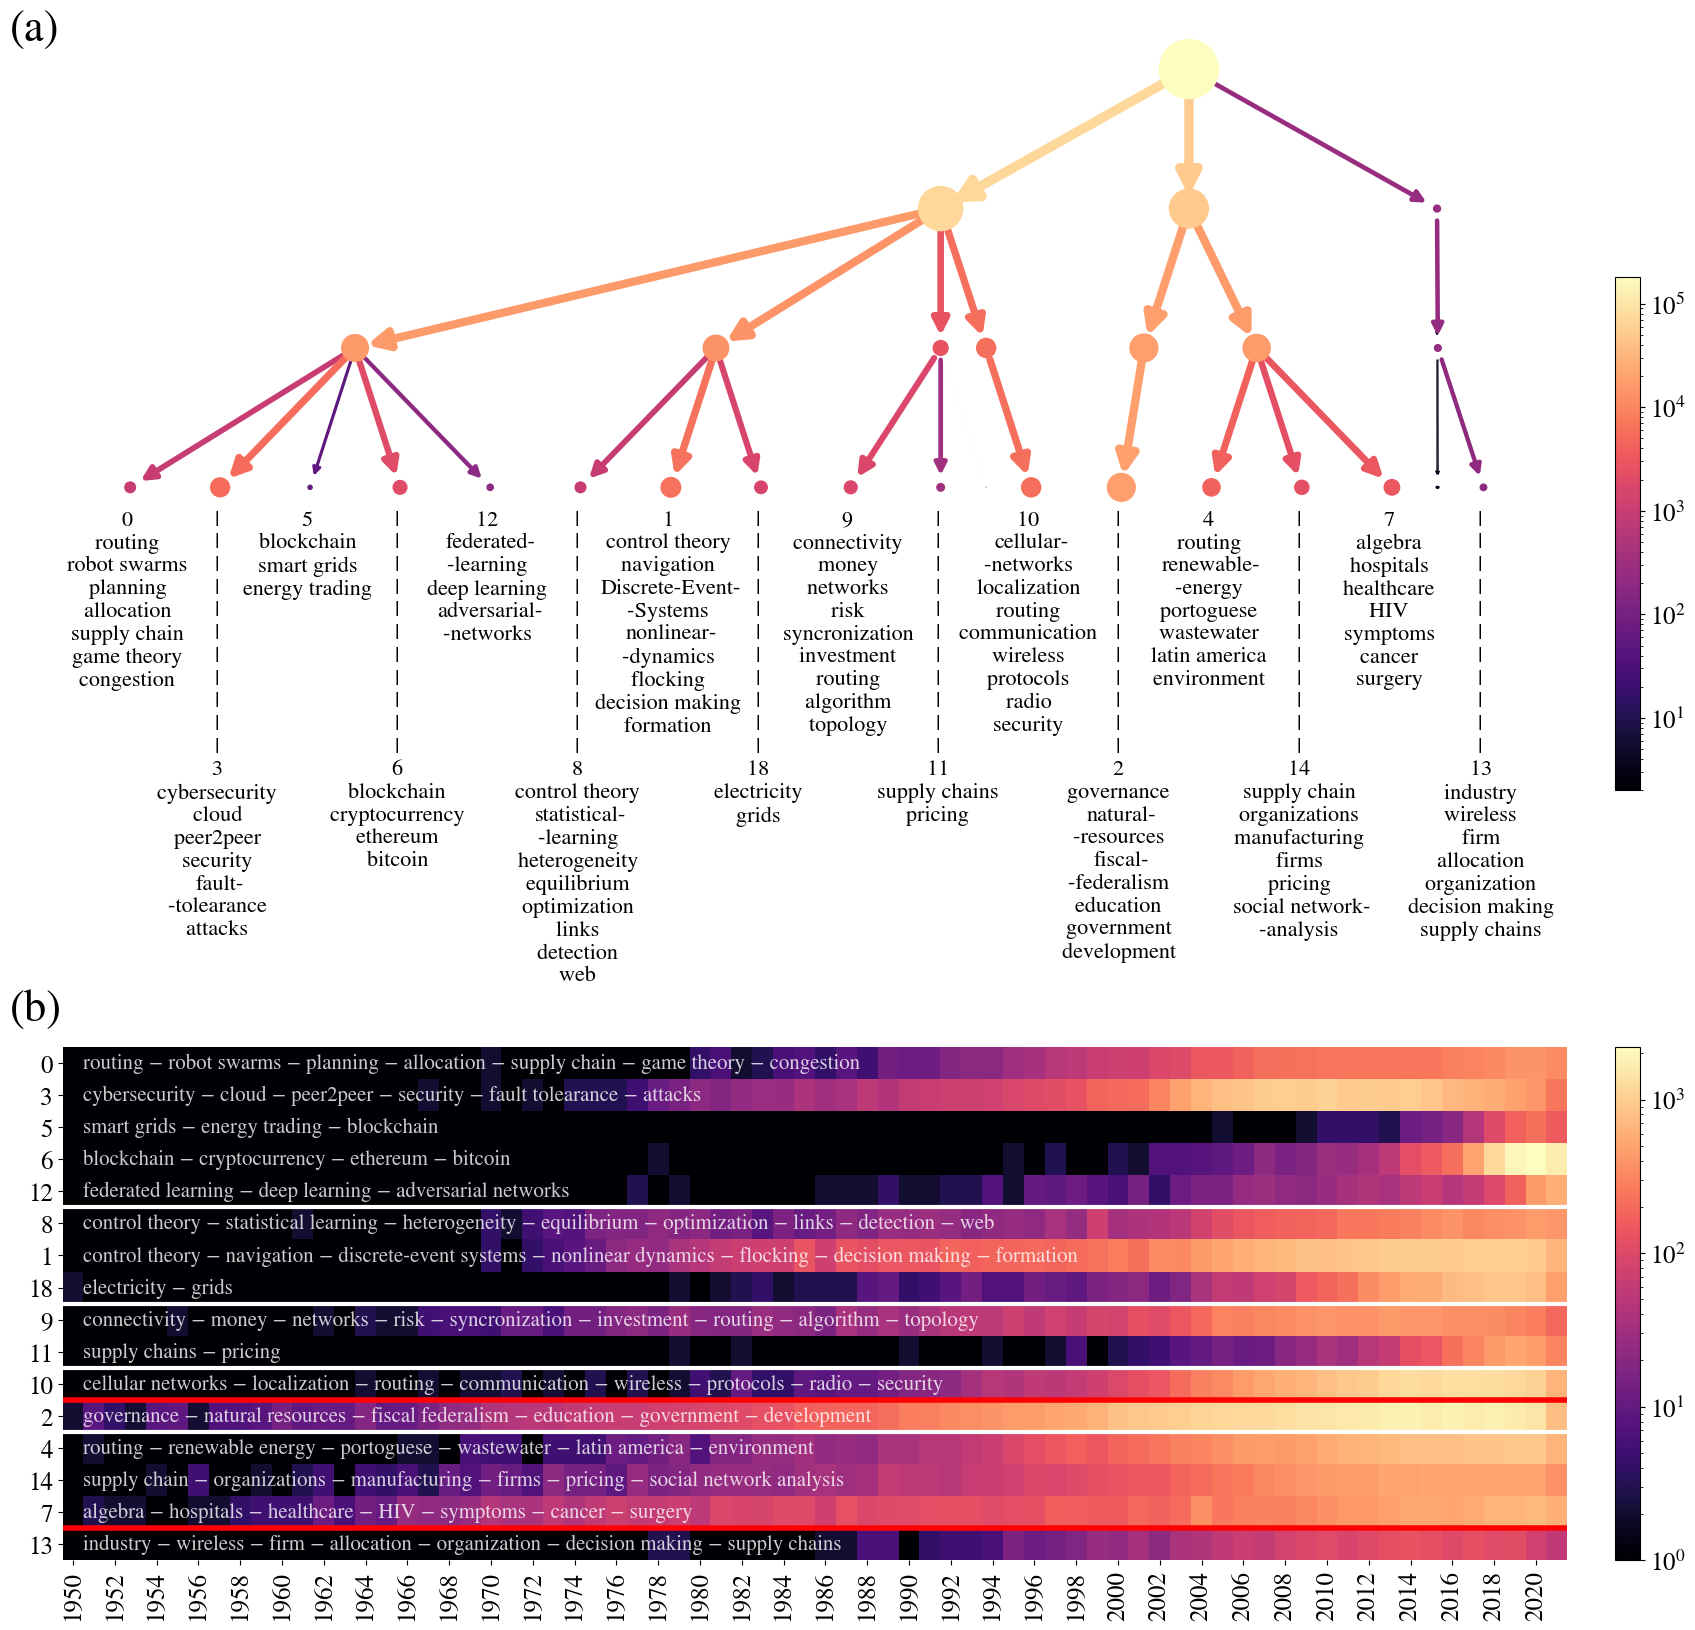

In [936]:
l = 3
year_cluster_log = year_cluster_field_no_papers_df_by_level[l].groupby(["year","cluster"],as_index=False).no_papers.sum()
year_cluster_log["no_papers_log"] = np.log([max(1,_) for _ in year_cluster_log["no_papers"]])

fig,axes = plt.subplots(2,2,figsize=(21,20),gridspec_kw={"hspace":0., "height_ratios":[2,1], "width_ratios":[20,1], 'wspace':0.06})

ax = axes[0][0]
pos,vm,vM = create_hierarchy_network_docs(partition=0, top_level=6, bottom_level=l, 
                             max_num_clusters_to_represent=10000, num_words_to_represent=20, 
                             multiplicator_size_nodes=.01, multiplicator_size_edges=1, multiplicator_ypos=0.40,#0.3
                             fontsize = 16, ax=ax, fig=fig, threshold_num_papers = 500, num_spaces=1000, 
                            do_barplot=False, number_bars=11, MAX_CHARS=15)
min_pos = min([x[0] for x in pos.values()])
max_pos = max([x[0] for x in pos.values()])
ax.set_xlim(left = min_pos - (max_pos - min_pos)*0.05,
            right = max_pos*1.06)

ax_cmap = axes[0][1]
fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.LogNorm(vmin=vm,vmax=vM), cmap=plt.get_cmap("magma")), ax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation="vertical") # Normalize
ax_cmap.tick_params(labelsize=20) 
ax_cmap.axis('off')
fig.text(.1, .87, "(a)", fontsize=32, transform=fig.transFigure)


#########################################################################################################################################


level3_pos = [(x,y) for x,y in pos.items() if x.split("_")[0]=="3"]
ordered_lev3_clusters_pos = sorted(level3_pos,key = lambda x:x[1][0])
ordered_lev3_clusters = [int(x[0].split("_")[1].split("\n")[0]) for x in ordered_lev3_clusters_pos]

ordered_hierarchy_lev_4 = []
for c in ordered_lev3_clusters:
    for c3 in hierarchy_docs[4].keys():
        if c in hierarchy_docs[4][c3] and c3 not in [x[0] for x in ordered_hierarchy_lev_4]:
            ordered_hierarchy_lev_4.append((c3,hierarchy_docs[4][c3]))

ax = axes[1][0]

fig, ax = heatmap(df=year_cluster_log, fixed_labels=[], x_label="year", y_label="cluster", values_label="no_papers_log", 
             costrains_equal={"year":set(range(1950,2022))},#figsize=(21,14),
             ordered_cluster_labels=ordered_lev3_clusters, ordered_cluster_groups=ordered_hierarchy_lev_4,linewidth=1,
             cut_small_clusters=True,threshold_num_papers=500,
             bottom_level = l, top_level = 6,
             ax=ax,fig=fig,do_barplot=False,linelength = 150)
fig.add_subplot(ax)


ax_cmap = axes[1][1]
vmin = np.e**year_cluster_log.no_papers_log.unique().min()
vmax = year_cluster_log.no_papers.unique().max()
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax), cmap=plt.get_cmap("magma")), ax=ax_cmap,shrink=1,pad=0., fraction=1,orientation="vertical")
ax_cmap.tick_params(labelsize=20) 
ax_cmap.axis('off')
fig.add_subplot(ax_cmap)
fig.text(.1, 0.38, "(b)", fontsize=32, transform=fig.transFigure)

fig.savefig(f"{paper_figures_folder2}Figure2_lev{l}.pdf",bbox_inches='tight')

## Figure 3

/tmp/ipykernel_19651/2970442196.py:416: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


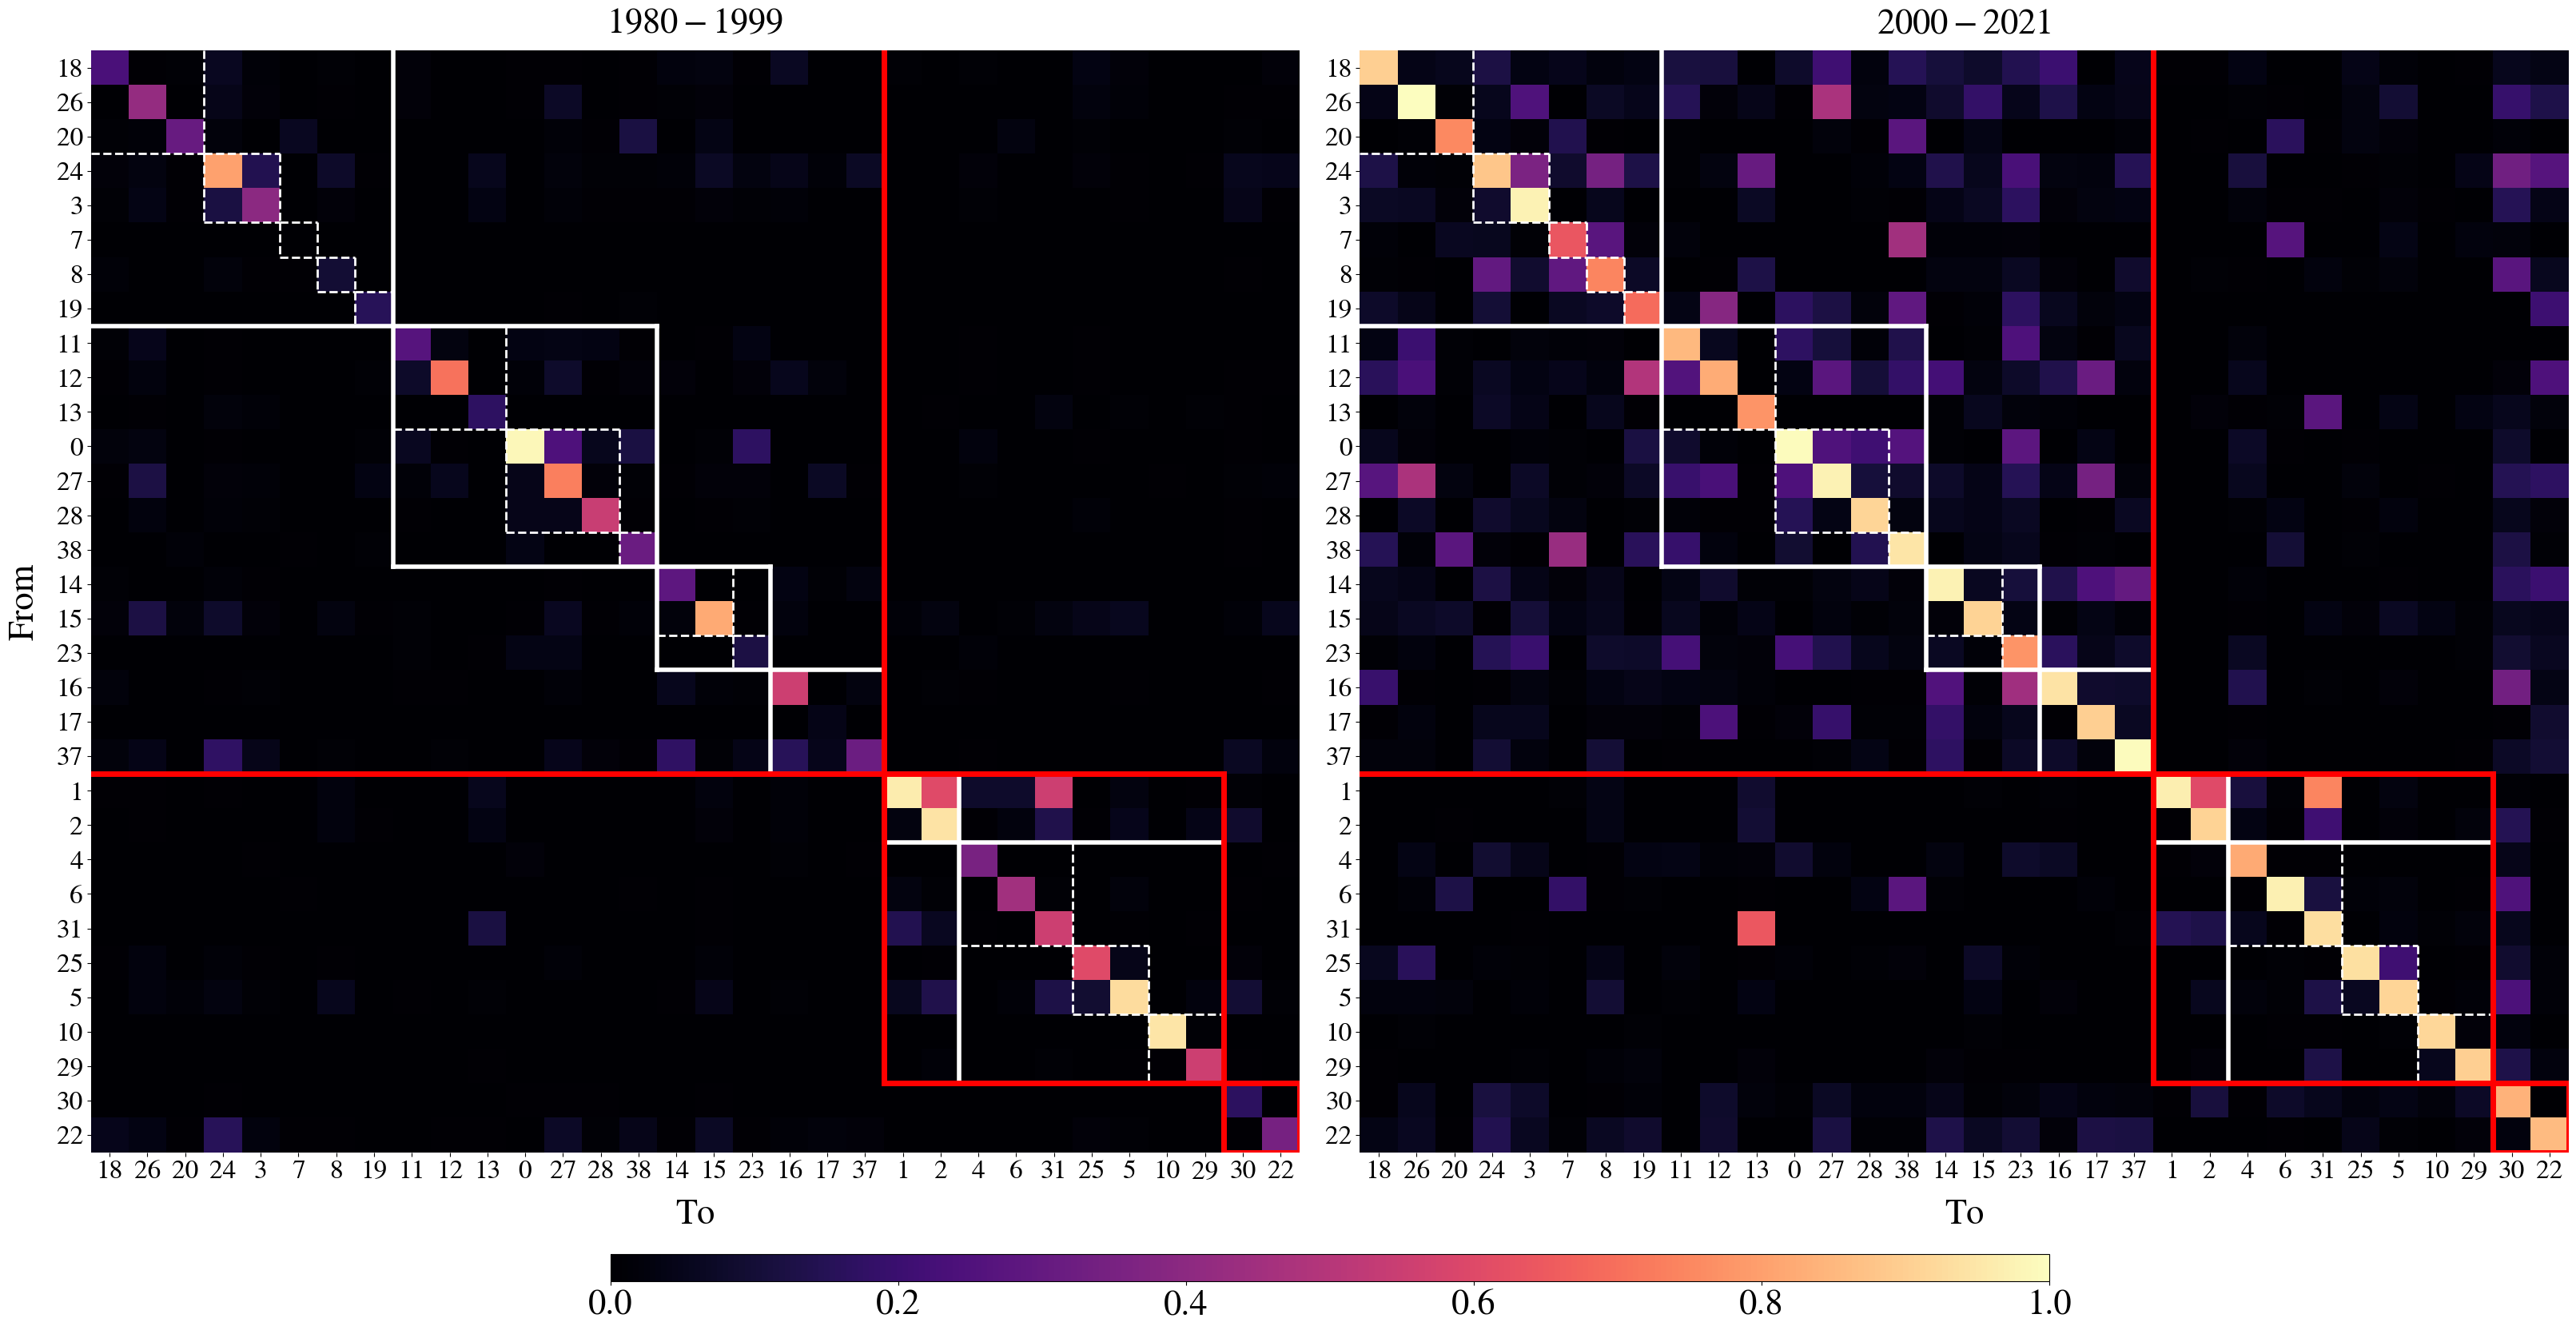

In [925]:
# TODO do also at level 3!

l = 2
fig = plt.figure(figsize=(40,20))
outer = gridspec.GridSpec(nrows=2, ncols=1,height_ratios=[40,1],hspace=0.18)
inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                        subplot_spec=outer[0],wspace=0.05,hspace=0.12,)

# for i,(year_from,year_to) in enumerate([(1951,1971),(1971,1991),(1991,2011),(2011,2022)]):
for i,(year_from,year_to) in enumerate([(1980,2000),(2000,2022)]):
# for i,(year_from,year_to) in enumerate([(2011,2022)]):
    ax = plt.Subplot(fig, inner[i]) # axes[i//2,i%2]
#     x = tmp_future.copy()
#     x.knowledge_flow = x.knowledge_flow.apply(lambda t:t if t<5 else 5)
#     x = x.loc[tmp_future.year_from.isin(range(year_from,year_to))].groupby(["cluster_from","cluster_to"],as_index=False).knowledge_flow.mean()
#     fig,ax = heatmap(df=x, fixed_labels=[], x_label="cluster_from", y_label="cluster_to", values_label="knowledge_flow", 
#             costrains_equal={},figsize=(21,20),
#                  filename="",
#                  ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=2,
#                  cut_small_clusters=True,threshold_num_papers=500,do_barplot=False,
#                  fig=fig,ax=ax)
#     ax.set_title("%d to %d"%(year_from,year_to),y=1.01,fontsize=32)
#     fig.add_subplot(ax)
    
#     tmp = knowledge_flow_normalized_per_field_in_time_by_level_df[l].copy()
#     tmp['significant_kf'] = tmp.knowledge_flow >= 1
#     tmp = tmp.loc[tmp.year_from.isin(range(year_from,year_to))]
#     tmp = tmp.loc[tmp.year_to.isin(range(year_from,year_to))]
#     tmp = tmp.groupby(["cluster_from","cluster_to","year_from"],as_index=False).significant_kf.mean()
#     tmp = tmp.groupby(["cluster_from","cluster_to"],as_index=False).significant_kf.mean()
    
    
    tmp = knowledge_flow_normalized_per_field_in_time_to_future_by_level[l].copy()
    tmp = tmp.loc[tmp.year_from.isin(range(year_from,year_to))]
    tmp = tmp.groupby(["cluster_from","cluster_to"],as_index=False).significant_kf.mean()
    
    
    couples = set([tuple(x) for x in tmp[['cluster_from','cluster_to']].values])
    for cluster_f in keywords_clusters[2].keys():
        for cluster_t in keywords_clusters[2].keys():
            if (cluster_f,cluster_t) not in couples:
                tmp.loc[len(tmp)] = [cluster_f,cluster_t,0]
            
    
    fig,ax = heatmap(df=tmp, fixed_labels=[], x_label="cluster_to", y_label="cluster_from", values_label="significant_kf", 
            costrains_equal={},figsize=(21,18),
                 filename=paper_figures_folder + f"cluster_analysis/heatmaps/heatmap_knowledge_flow_between_clusters_{l}_new.pdf",
                 ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=2,
                 cut_small_clusters=True,threshold_num_papers=500,do_barplot=False,fig=fig,ax=ax, vmax=1)
    
    ax.set_title("$%d - %d$"%(year_from,year_to-1),y=1.01,fontsize=32)
    fig.add_subplot(ax)
    ax.set_xlabel("To",fontsize=32,labelpad = 14)
    if i==0:
        ax.set_ylabel("From",fontsize=32,labelpad = 14)
    ax.tick_params(labelsize=24) 

inner = gridspec.GridSpecFromSubplotSpec(1, 3, width_ratios = [1,3,1],
                        subplot_spec=outer[1],wspace=0.05,hspace=0.12,)

ax_cmap = plt.Subplot(fig, inner[1])
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=1), cmap=plt.get_cmap("magma")), cax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation="horizontal")
ax_cmap.tick_params(labelsize=32) 
fig.add_subplot(ax_cmap)

paper_figures_folder2 = "/home/enterprise.internal.city.ac.uk/aczy350/Dropbox/phd/projects/decentralization/clean_code_copy/figures/heatmaps/"
fig.savefig(f"{paper_figures_folder2}Figure3_lev{l}.pdf")
# fig.savefig(paper_figures_folder2 + f"cluster_analysis/heatmaps/heatmaps_knowledge_flow_between_clusters_over_time_20_years_from1980.pdf")

/tmp/ipykernel_19651/2970442196.py:416: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


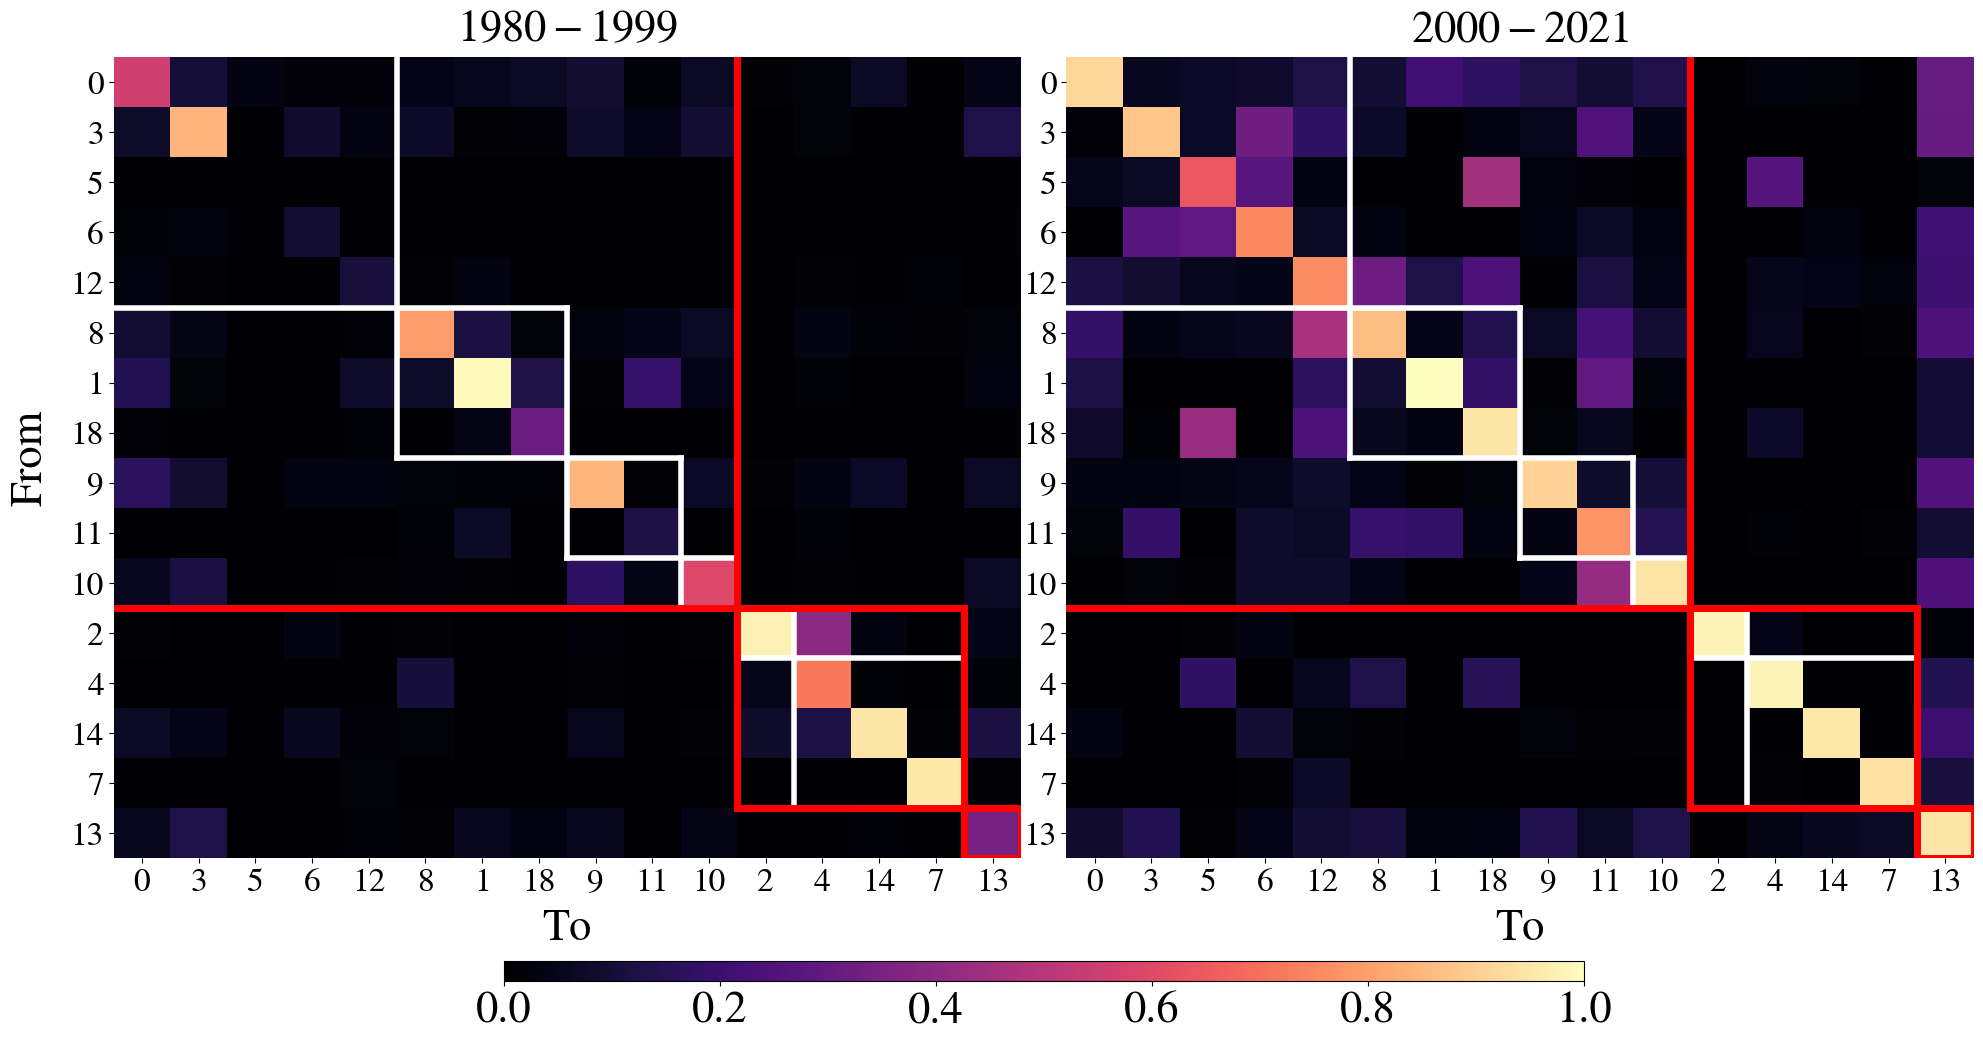

In [931]:
# TODO do also at level 3!

l = 3
fig = plt.figure(figsize=(24,12))
outer = gridspec.GridSpec(nrows=2, ncols=1,height_ratios=[40,1],hspace=0.25)
inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                        subplot_spec=outer[0],wspace=0.05,hspace=0.12,)

# for i,(year_from,year_to) in enumerate([(1951,1971),(1971,1991),(1991,2011),(2011,2022)]):
for i,(year_from,year_to) in enumerate([(1980,2000),(2000,2022)]):
# for i,(year_from,year_to) in enumerate([(2011,2022)]):
    ax = plt.Subplot(fig, inner[i]) # axes[i//2,i%2]
#     x = tmp_future.copy()
#     x.knowledge_flow = x.knowledge_flow.apply(lambda t:t if t<5 else 5)
#     x = x.loc[tmp_future.year_from.isin(range(year_from,year_to))].groupby(["cluster_from","cluster_to"],as_index=False).knowledge_flow.mean()
#     fig,ax = heatmap(df=x, fixed_labels=[], x_label="cluster_from", y_label="cluster_to", values_label="knowledge_flow", 
#             costrains_equal={},figsize=(21,20),
#                  filename="",
#                  ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=2,
#                  cut_small_clusters=True,threshold_num_papers=500,do_barplot=False,
#                  fig=fig,ax=ax)
#     ax.set_title("%d to %d"%(year_from,year_to),y=1.01,fontsize=32)
#     fig.add_subplot(ax)
    
#     tmp = knowledge_flow_normalized_per_field_in_time_by_level_df[l].copy()
#     tmp['significant_kf'] = tmp.knowledge_flow >= 1
#     tmp = tmp.loc[tmp.year_from.isin(range(year_from,year_to))]
#     tmp = tmp.loc[tmp.year_to.isin(range(year_from,year_to))]
#     tmp = tmp.groupby(["cluster_from","cluster_to","year_from"],as_index=False).significant_kf.mean()
#     tmp = tmp.groupby(["cluster_from","cluster_to"],as_index=False).significant_kf.mean()
    
    
    tmp = knowledge_flow_normalized_per_field_in_time_to_future_by_level[l].copy()
    tmp = tmp.loc[tmp.year_from.isin(range(year_from,year_to))]
    tmp = tmp.groupby(["cluster_from","cluster_to"],as_index=False).significant_kf.mean()
    
    
    couples = set([tuple(x) for x in tmp[['cluster_from','cluster_to']].values])
    for cluster_f in keywords_clusters[l].keys():
        for cluster_t in keywords_clusters[l].keys():
            if (cluster_f,cluster_t) not in couples:
                tmp.loc[len(tmp)] = [cluster_f,cluster_t,0]
            
    level3_pos = [(x,y) for x,y in pos.items() if x.split("_")[0]=="3"]
    ordered_lev3_clusters_pos = sorted(level3_pos,key = lambda x:x[1][0])
    ordered_lev3_clusters = [int(x[0].split("_")[1].split("\n")[0]) for x in ordered_lev3_clusters_pos]

    ordered_hierarchy_lev_4 = []
    for c in ordered_lev3_clusters:
        for c3 in hierarchy_docs[4].keys():
            if c in hierarchy_docs[4][c3] and c3 not in [x[0] for x in ordered_hierarchy_lev_4]:
                ordered_hierarchy_lev_4.append((c3,hierarchy_docs[4][c3]))
            
    fig,ax = heatmap(df=tmp, fixed_labels=[], x_label="cluster_to", y_label="cluster_from", values_label="significant_kf", 
            costrains_equal={},figsize=(21,18),
                 filename=paper_figures_folder + f"cluster_analysis/heatmaps/heatmap_knowledge_flow_between_clusters_{l}_new.pdf",
                 ordered_cluster_labels=ordered_lev3_clusters, ordered_cluster_groups=ordered_hierarchy_lev_4,linewidth=2,
                 cut_small_clusters=True,threshold_num_papers=500,do_barplot=False,fig=fig,ax=ax, vmax=1,
                 bottom_level=3,top_level=6)
    
    ax.set_title("$%d - %d$"%(year_from,year_to-1),y=1.01,fontsize=32)
    fig.add_subplot(ax)
    ax.set_xlabel("To",fontsize=32,labelpad = 8)
    if i==0:
        ax.set_ylabel("From",fontsize=32,labelpad = 14)
    ax.tick_params(labelsize=24) 

inner = gridspec.GridSpecFromSubplotSpec(1, 3, width_ratios = [1,3,1],
                        subplot_spec=outer[1],wspace=0.05,hspace=0.12,)

ax_cmap = plt.Subplot(fig, inner[1])
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=1), cmap=plt.get_cmap("magma")), cax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation="horizontal")
ax_cmap.tick_params(labelsize=32) 
fig.add_subplot(ax_cmap)

paper_figures_folder2 = "/home/enterprise.internal.city.ac.uk/aczy350/Dropbox/phd/projects/decentralization/clean_code_copy/figures/heatmaps/"
fig.savefig(f"{paper_figures_folder2}Figure3_lev{l}.pdf")
# fig.savefig(paper_figures_folder2 + f"cluster_analysis/heatmaps/heatmaps_knowledge_flow_between_clusters_over_time_20_years_from1980.pdf")

## Figure 4 analysis

In [937]:
y = knowledge_flow_normalized_per_field_in_time_by_level_df[3].copy()
y = y.loc[(y.cluster_to == 6)&(y.year_to>2007)&(y.year_to<2015)]
y['significant_kf'] = y.knowledge_flow >= 2

In [938]:
y = y.loc[y.year_from > 1900].groupby(["cluster_from","year_from"],as_index=False).significant_kf.mean()
y['cluster_to'] = 6

/tmp/ipykernel_19651/2242581569.py:390: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=rect)


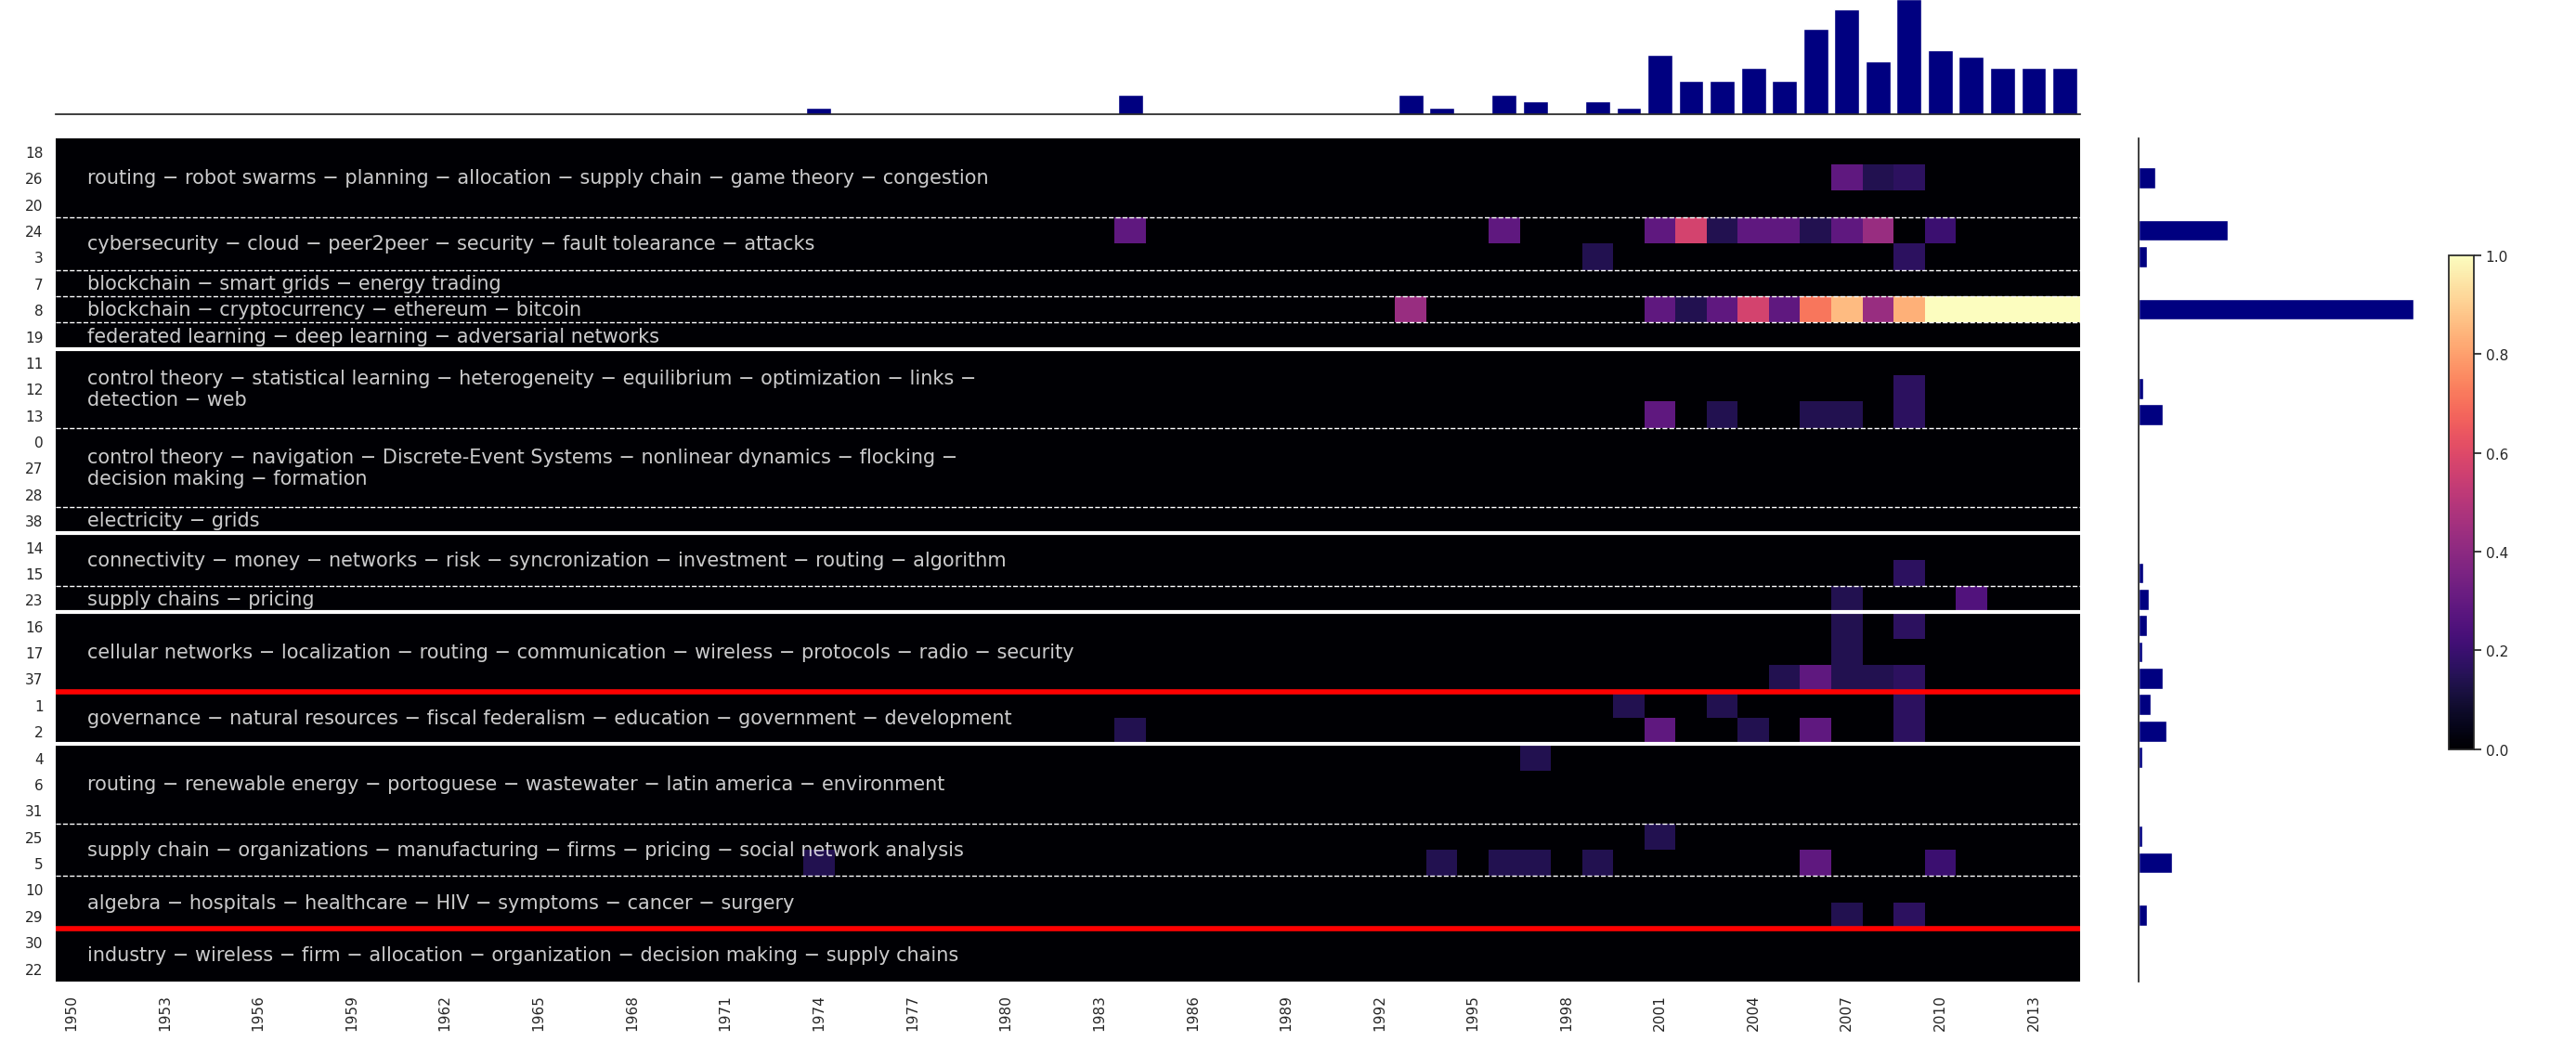

In [570]:
fig = heatmap(df=y, fixed_labels=["cluster_to"], x_label="year_from", y_label="cluster_from", values_label="significant_kf", 
            costrains_equal={"cluster_to":set([8]), "year_from":set(range(1950,2022))},figsize=(28,14),cut_small_clusters=True,threshold_num_papers=500,
              ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3)

3 [(0, ()), (3, ()), (5, ()), (6, ()), (12, ()), (8, ()), (1, ()), (18, ()), (9, ()), (11, ()), (15, ()), (10, ()), (2, ()), (4, ()), (14, ()), (7, ()), (20, ()), (17, ()), (19, ()), (13, ())]
4 [(0, {0, 3, 5, 6, 12}), (1, {8, 1, 18}), (4, {9, 11, 15}), (5, {10}), (2, {2}), (3, {4, 14, 7}), (8, {20}), (6, {17, 19, 13})]
5 [(0, [0, 3, 5, 6, 12, 8, 1, 18, 9, 11, 15, 10]), (1, [2, 4, 14, 7]), (2, [20, 17, 19, 13])]


/tmp/ipykernel_19651/2970442196.py:414: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=rect)


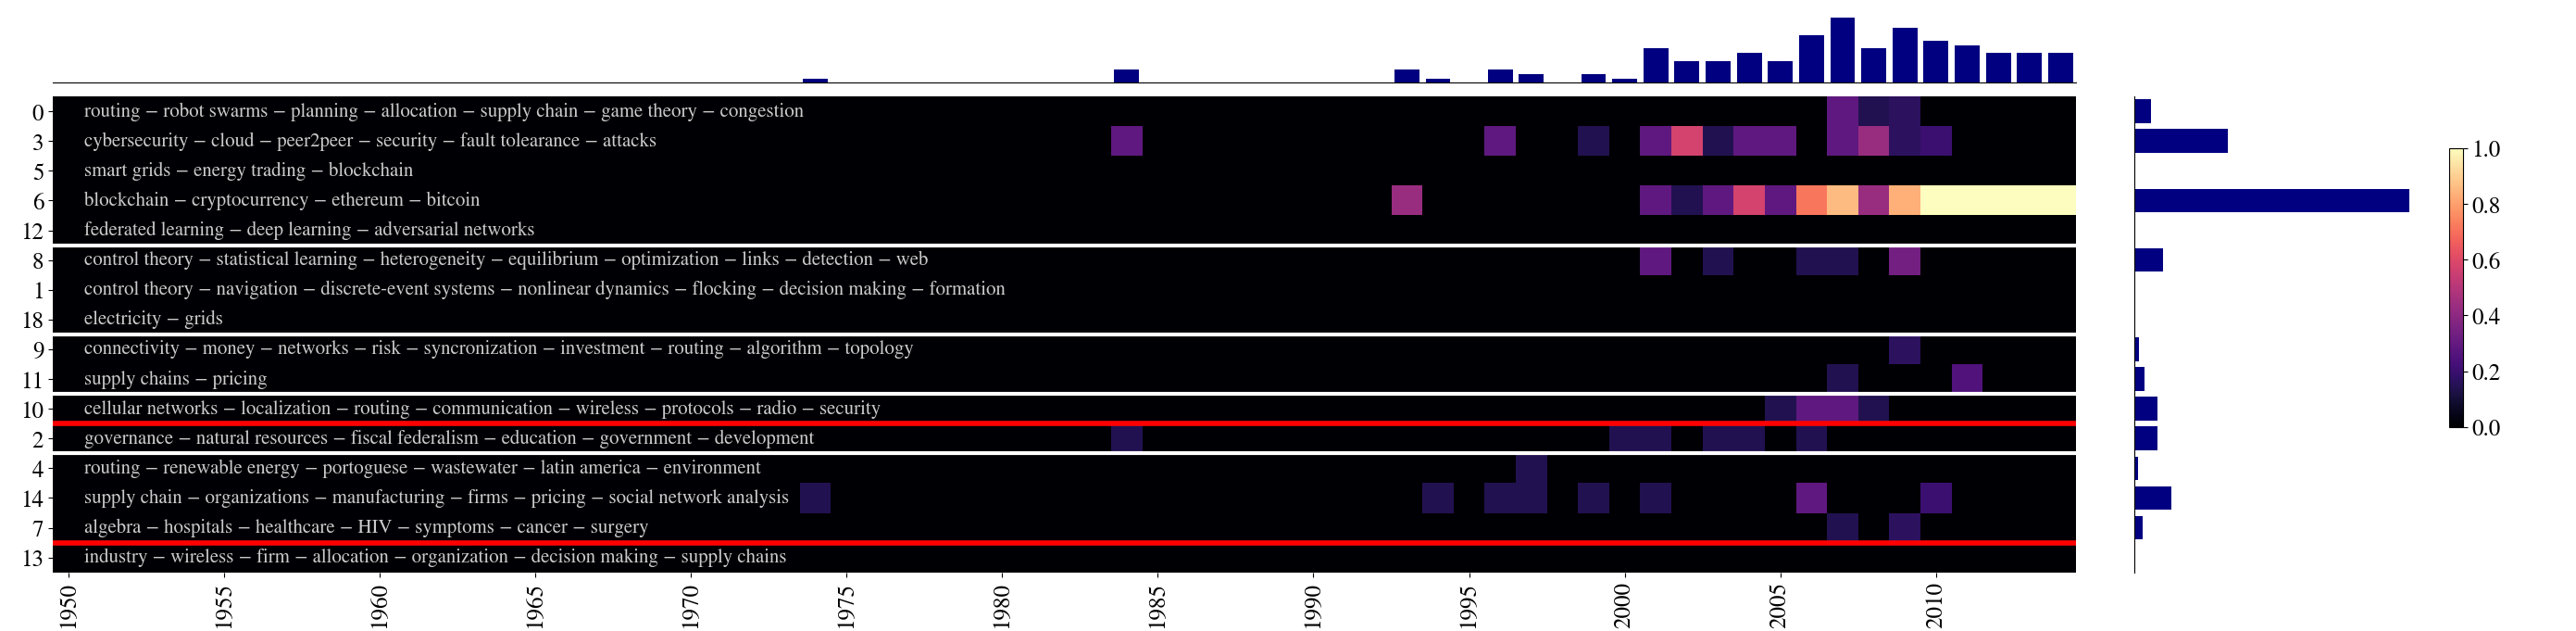

In [942]:
fig = heatmap(df=y, fixed_labels=["cluster_to"], x_label="year_from", y_label="cluster_from", values_label="significant_kf", 
            costrains_equal={"cluster_to":set([6]), "year_from":set(range(1950,2022))},figsize=(28,14),cut_small_clusters=True,threshold_num_papers=500,
              ordered_cluster_labels=ordered_lev3_clusters, ordered_cluster_groups=ordered_hierarchy_lev_4,
             bottom_level=3, linelength=150)

In [598]:
keywords_clusters[2][5]

'organizations\nfirms\nsocial network analysis'

In [578]:
y[(y.significant_kf>0)&(y.cluster_from==5)]

cluster_from  year_from  significant_kf  cluster_to
643             5       1974        0.142857           8
663             5       1994        0.142857           8
665             5       1996        0.142857           8
666             5       1997        0.142857           8
668             5       1999        0.142857           8
675             5       2006        0.285714           8
679             5       2010        0.200000           8

### 2015-2022 influenced by

In [944]:
y = knowledge_flow_normalized_per_field_in_time_by_level_df[3].copy()
y = y.loc[(y.cluster_to == 6)&(y.year_to>=2015)]
y['significant_kf'] = y.knowledge_flow >= 1

In [945]:
y = y.loc[y.year_from > 1900].groupby(["cluster_from","year_from"],as_index=False).significant_kf.mean()
y['cluster_to'] = 6

3 [(0, ()), (3, ()), (5, ()), (6, ()), (12, ()), (8, ()), (1, ()), (18, ()), (9, ()), (11, ()), (15, ()), (10, ()), (2, ()), (4, ()), (14, ()), (7, ()), (20, ()), (17, ()), (19, ()), (13, ())]
4 [(0, {0, 3, 5, 6, 12}), (1, {8, 1, 18}), (4, {9, 11, 15}), (5, {10}), (2, {2}), (3, {4, 14, 7}), (8, {20}), (6, {17, 19, 13})]
5 [(0, [0, 3, 5, 6, 12, 8, 1, 18, 9, 11, 15, 10]), (1, [2, 4, 14, 7]), (2, [20, 17, 19, 13])]


/tmp/ipykernel_19651/2970442196.py:414: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=rect)


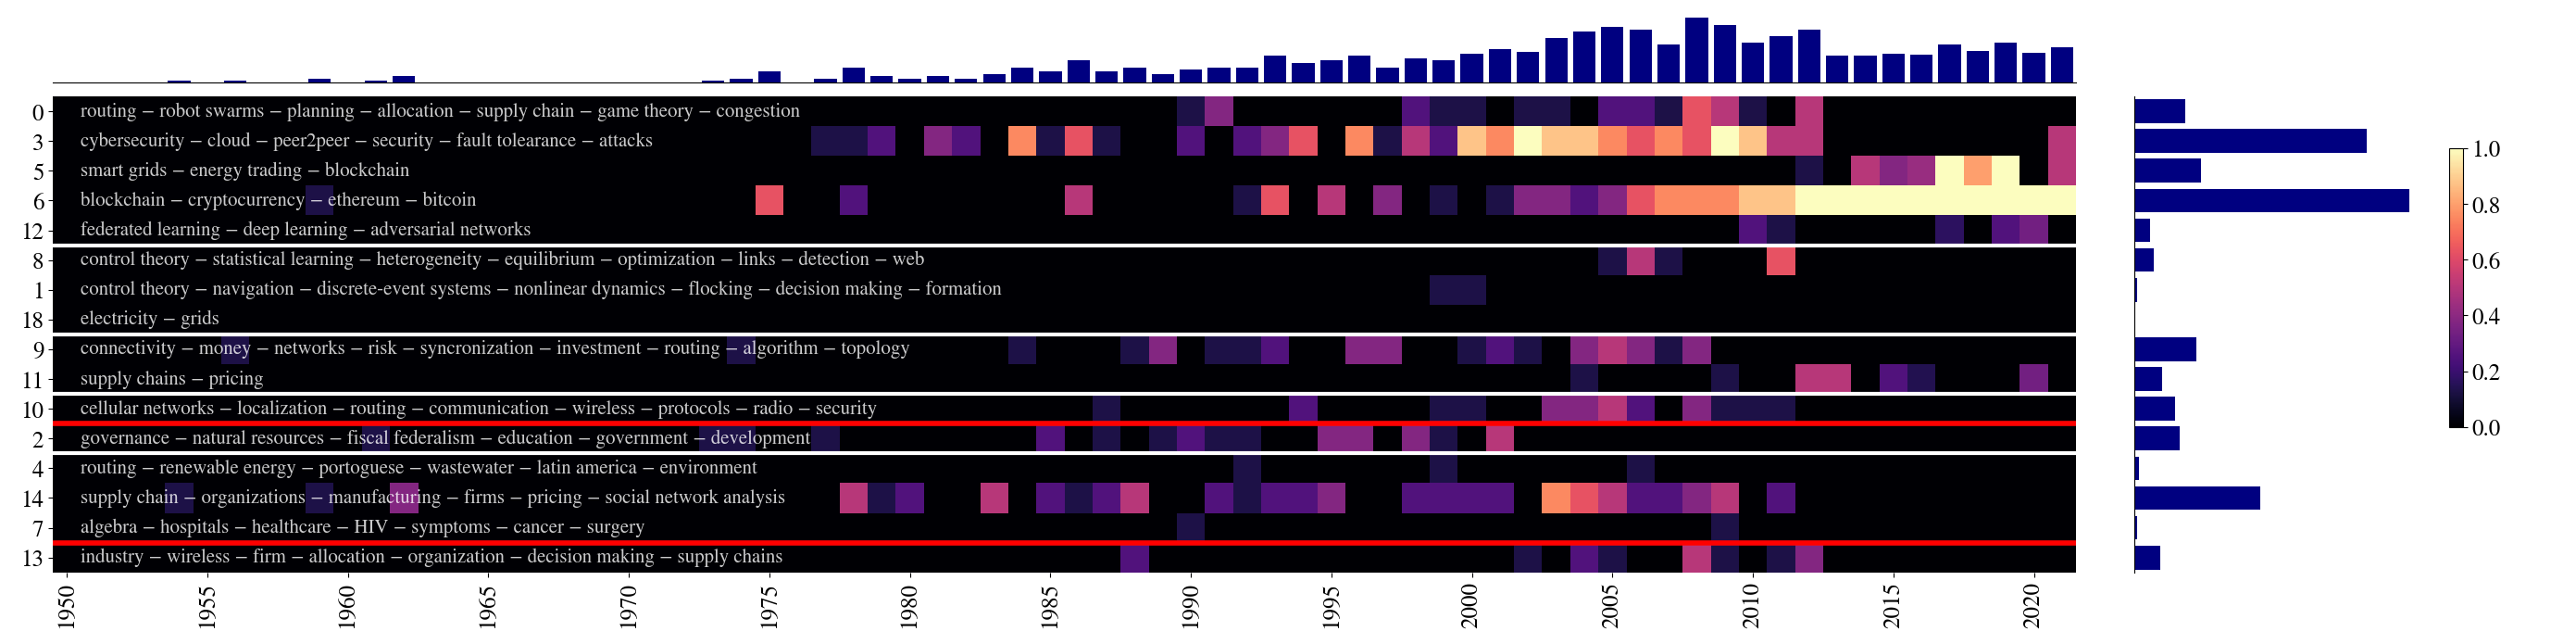

In [946]:
fig = heatmap(df=y, fixed_labels=["cluster_to"], x_label="year_from", y_label="cluster_from", values_label="significant_kf", 
            costrains_equal={"cluster_to":set([6]), "year_from":set(range(1950,2022))},figsize=(28,14),cut_small_clusters=True,threshold_num_papers=500,
              ordered_cluster_labels=ordered_lev3_clusters, ordered_cluster_groups=ordered_hierarchy_lev_4,
                          bottom_level=3, linelength=150)

/tmp/ipykernel_19651/2242581569.py:390: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=rect)


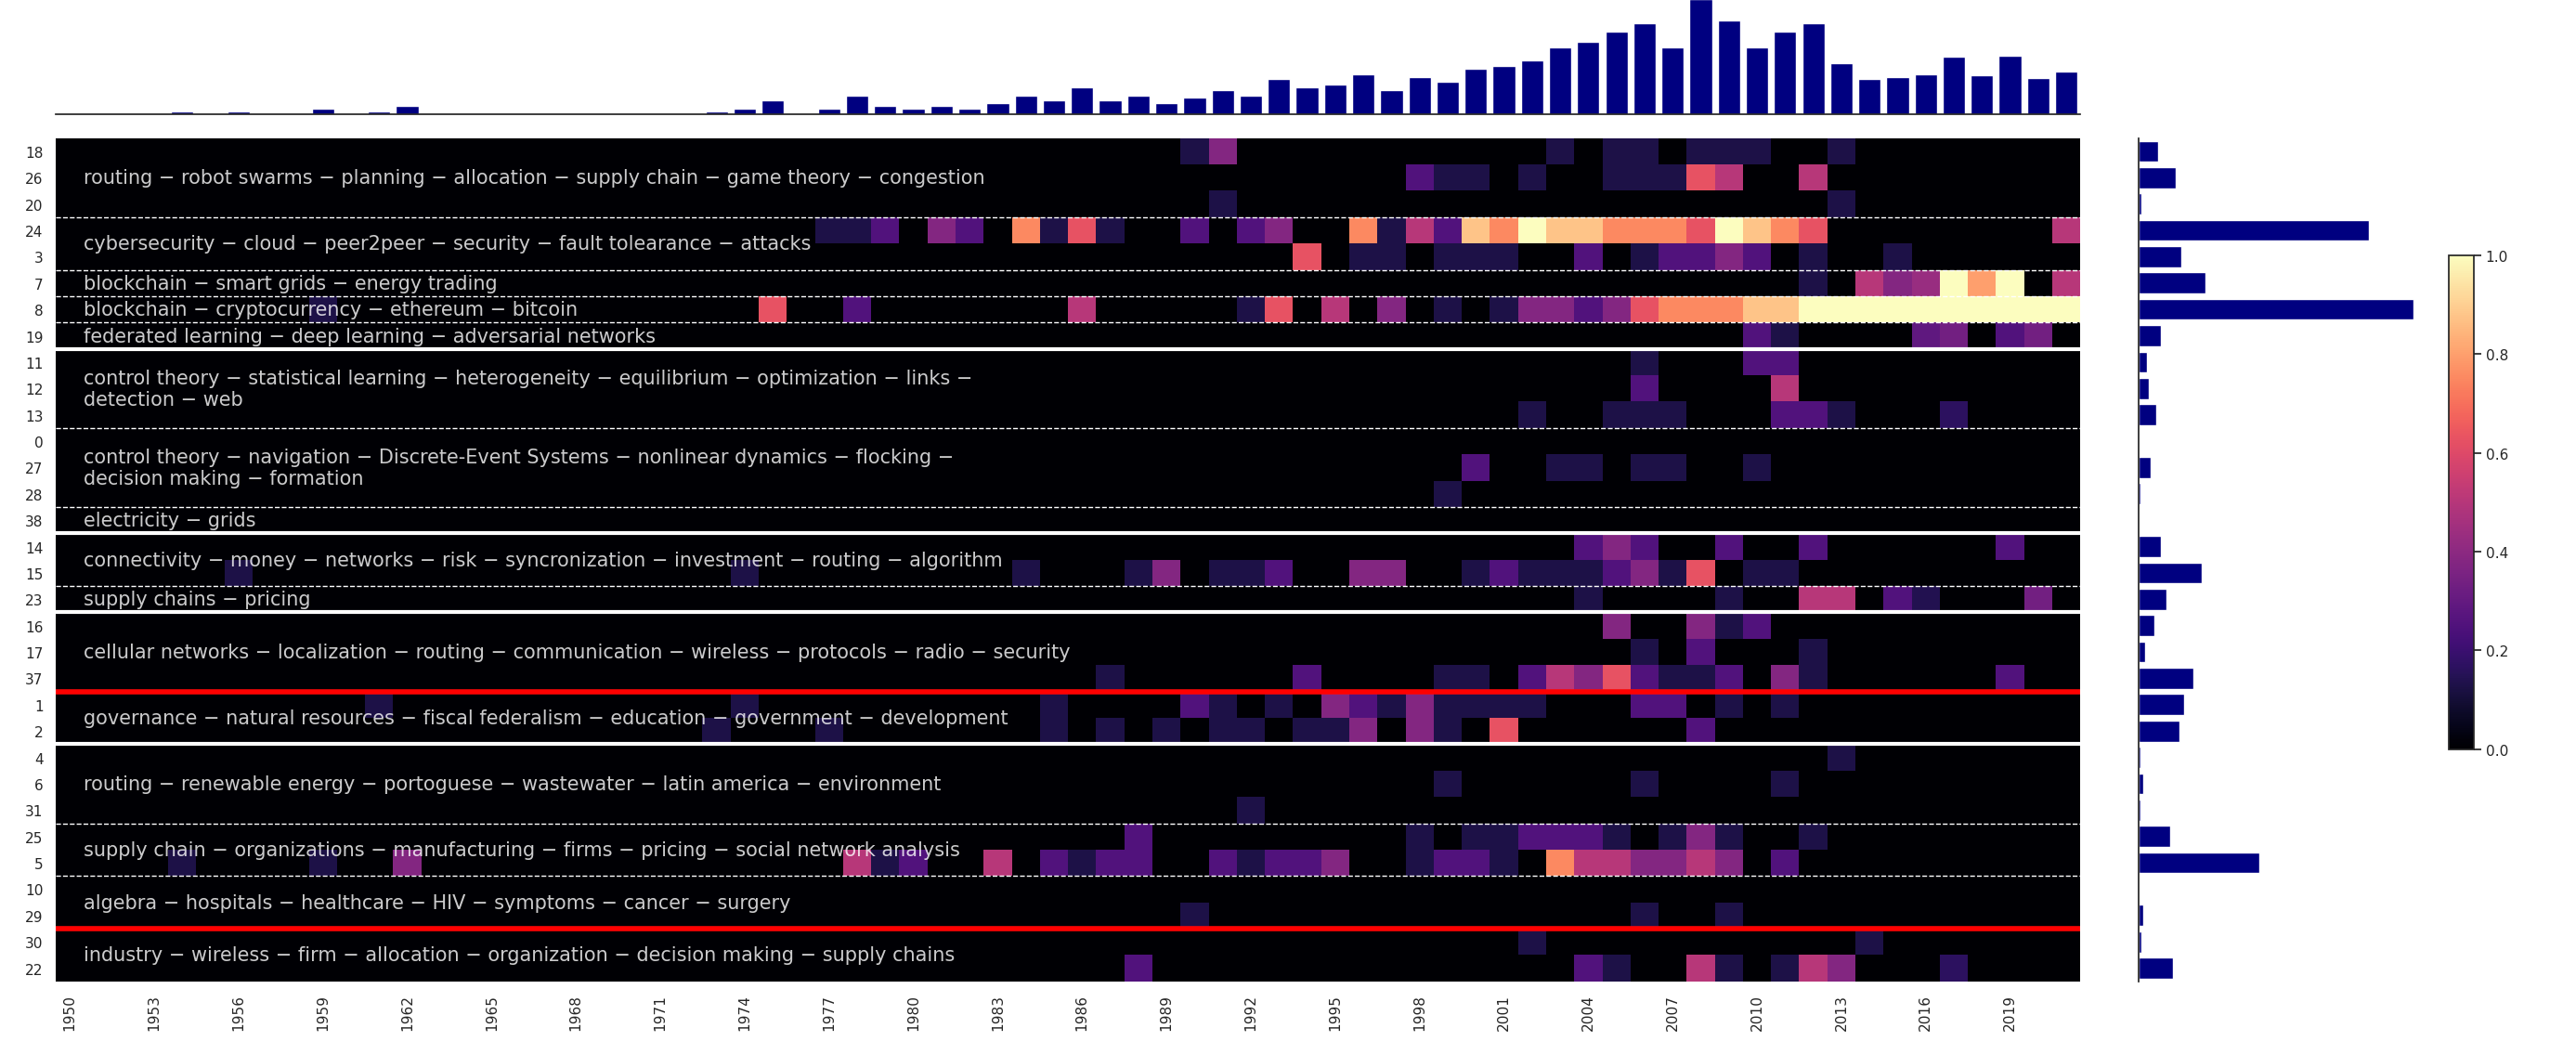

In [615]:
fig = heatmap(df=y, fixed_labels=["cluster_to"], x_label="year_from", y_label="cluster_from", values_label="significant_kf", 
            costrains_equal={"cluster_to":set([8]), "year_from":set(range(1950,2022))},figsize=(28,14),cut_small_clusters=True,threshold_num_papers=500,
              ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3)

### 2019-2022 influenced by

In [605]:
y = knowledge_flow_normalized_per_field_in_time_by_level_df[2].copy()
y = y.loc[(y.cluster_to == 8)&(y.year_to>=2019)]
y['significant_kf'] = y.knowledge_flow >= 2

In [606]:
y = y.loc[y.year_from > 1900].groupby(["cluster_from","year_from"],as_index=False).significant_kf.mean()
y['cluster_to'] = 8

/tmp/ipykernel_19651/2242581569.py:390: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=rect)


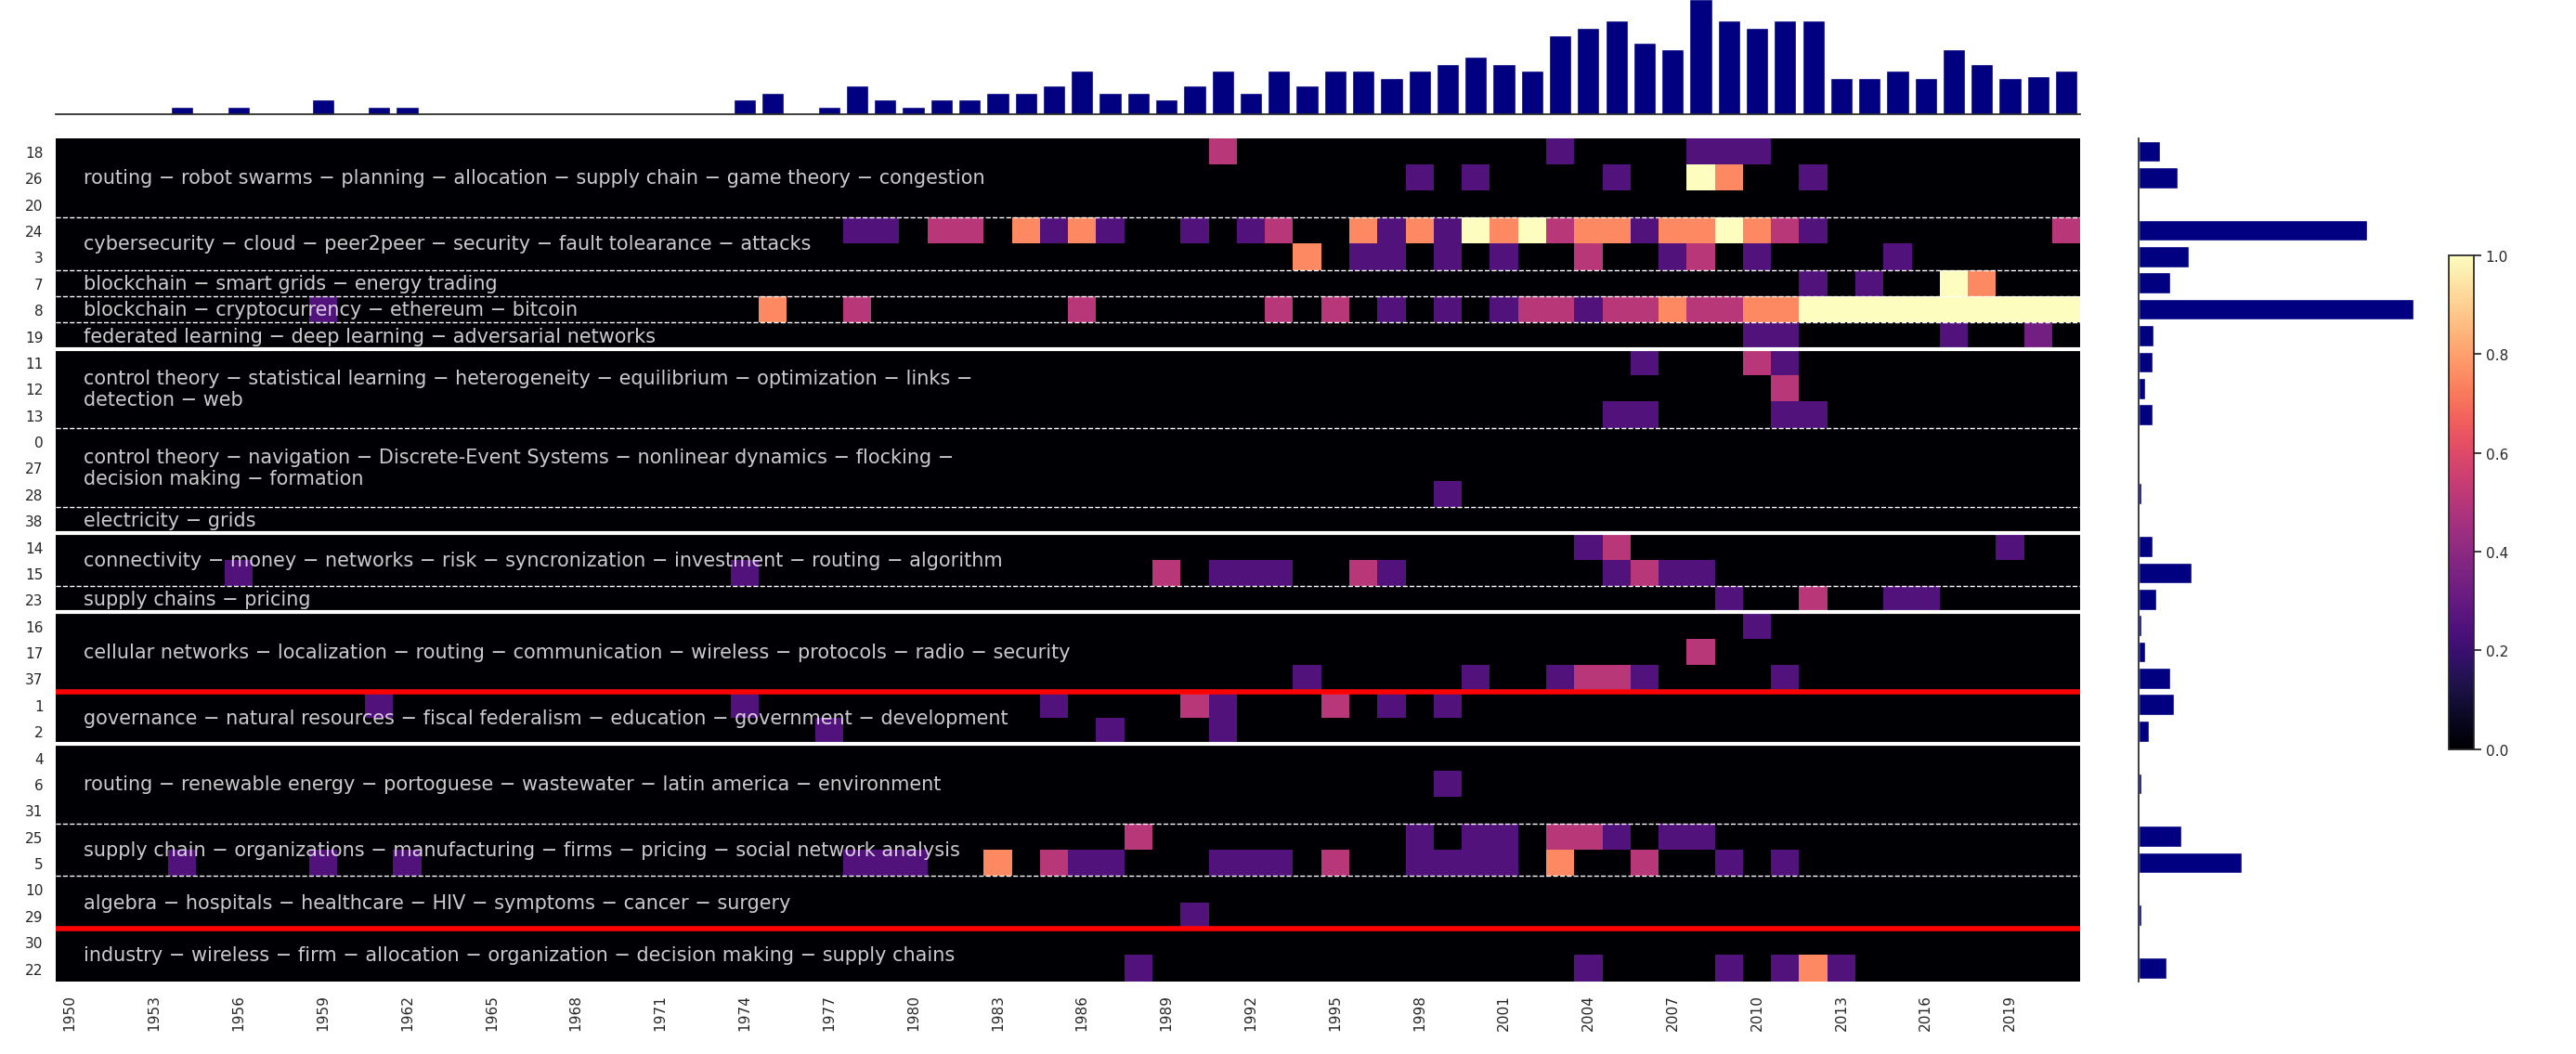

In [607]:
fig = heatmap(df=y, fixed_labels=["cluster_to"], x_label="year_from", y_label="cluster_from", values_label="significant_kf", 
            costrains_equal={"cluster_to":set([8]), "year_from":set(range(1950,2022))},figsize=(28,14),cut_small_clusters=True,threshold_num_papers=500,
              ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3)

In [612]:
keywords_clusters[2][15]

'money\nrisk\ninvestment\nalgorithm'

### 2002-2022 influence to

In [544]:
y = knowledge_flow_normalized_per_field_in_time_by_level_df[2].copy()
y = y.loc[(y.cluster_from == 8)&(y.year_to>=2002)]
y['significant_kf'] = y.knowledge_flow >= 2

In [545]:
y = y.loc[y.year_from > 1900].groupby(["cluster_to","year_from"],as_index=False).significant_kf.mean()
y['cluster_from'] = 8

/tmp/ipykernel_19651/2242581569.py:390: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=rect)


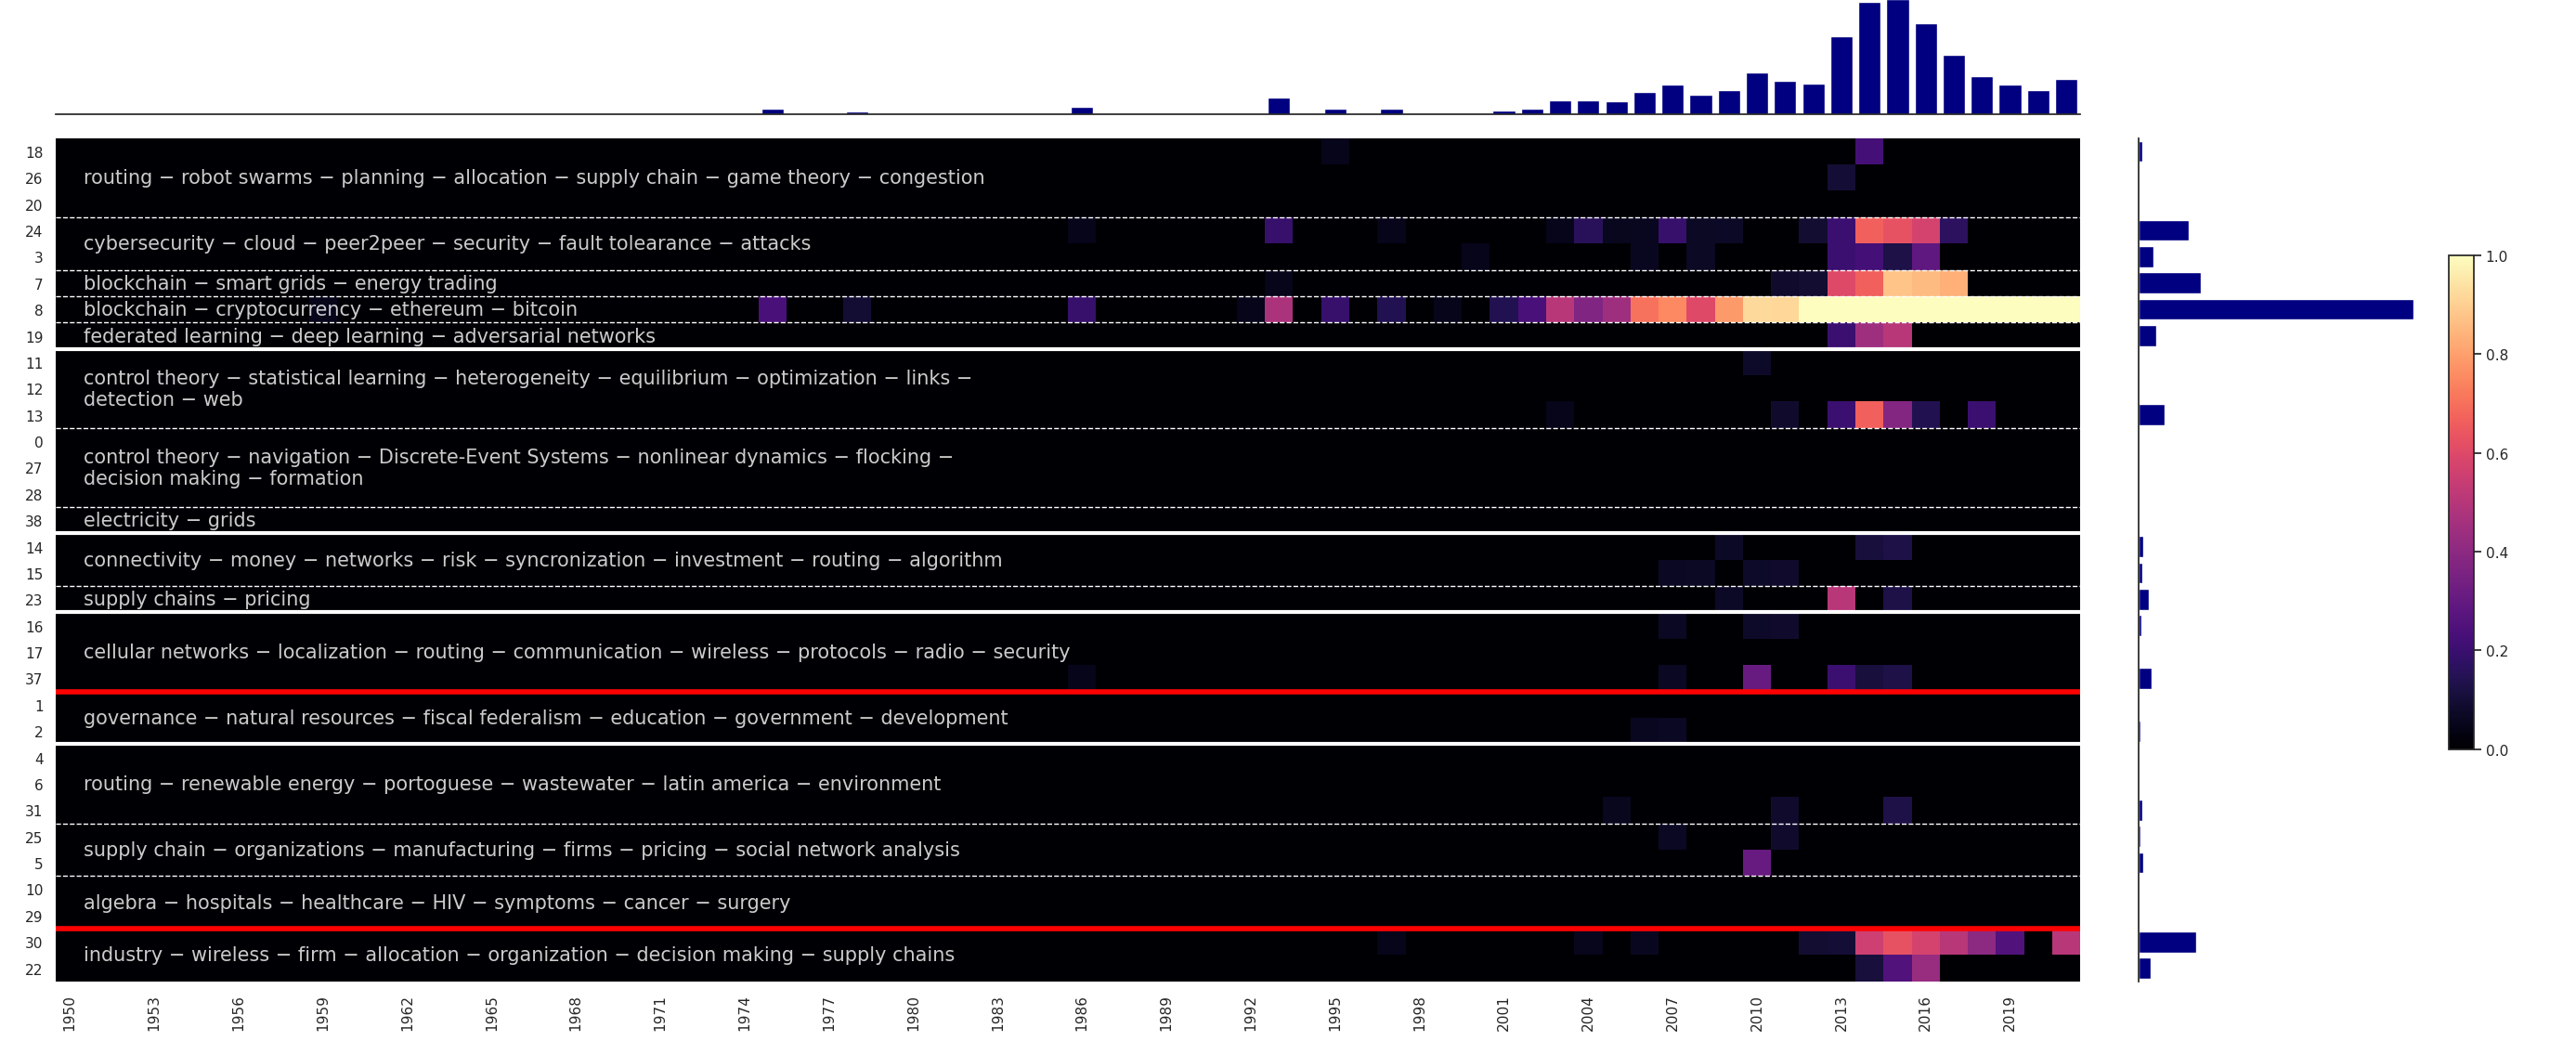

In [546]:
fig = heatmap(df=y, fixed_labels=["cluster_from"], x_label="year_from", y_label="cluster_to", values_label="significant_kf", 
            costrains_equal={"cluster_from":set([8]), "year_from":set(range(1950,2022))},figsize=(28,14),cut_small_clusters=True,threshold_num_papers=500,
              ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3)

In [567]:
keywords_clusters[2][30]

'industry\nfirm\norganization\nsupply chains'

In [565]:
keywords_clusters[3][12]

'federated learning\ndeep learning\nadversarial networks'

### Data creation

In [950]:
from utils.hsbm_knowledge_flow import check_papers_existence,create_papers_existence_set,assign_partition

In [951]:
all_docs_dict2, t,tt = assign_partition(h_t_doc_consensus_by_level,hyperlink_g,2,all_docs_dict)

In [952]:
papers_existence_set = create_papers_existence_set(all_docs_dict2)

In [956]:
def average_kf_signficance(df,years,cluster,threshold = 1, direction='from'):
    
    if direction == 'from':
        direction_inverse = 'to'
    else:
        direction_inverse = 'from'
        
    df = df.loc[(df[f'cluster_{direction_inverse}'] == cluster)&(df[f'year_{direction_inverse}'].isin(years))]
    
    df = df.loc[df.apply(lambda x: check_papers_existence(x[f'cluster_{direction}'],x[f'year_{direction}'],papers_existence_set),axis=1)]
    
    df['significant_kf'] = df.knowledge_flow >= threshold

    df = df.groupby([f"cluster_{direction}","year_from"],as_index=False).significant_kf.mean()
    df = df.groupby([f"cluster_{direction}"],as_index=False).significant_kf.mean()
    
    df[f'cluster_{direction_inverse}'] = cluster
    
    return df

In [958]:
average_kf_signficance(knowledge_flow_normalized_per_field_in_time_by_level[2],range(2008,2015),8,direction='to')

cluster_to  significant_kf  cluster_from
0            0        0.000000             8
1            1        0.011905             8
2            2        0.010989             8
3            3        0.095522             8
4            4        0.000000             8
5            5        0.043956             8
6            6        0.000000             8
7            7        0.205844             8
8            8        0.889351             8
9           10        0.000000             8
10          11        0.011905             8
11          12        0.014286             8
12          13        0.151587             8
13          14        0.046703             8
14          15        0.048291             8
15          16        0.051465             8
16          17        0.000000             8
17          18        0.035714             8
18          19        0.092063             8
19          20        0.000000             8
20          21        0.017857             8
21          22        0.017857             8
22          23        0.145125             8
23          24        0.376255             8
24          25        0.026190             8
25          26        0.015873             8
26          27        0.000000             8
27          28        0.000000             8
28          29        0.000000             8
29          30        0.119444             8
30          31        0.011905             8
31          32        0.000000             8
32          33        0.000000             8
33          34        0.000000             8
34          35        0.000000             8
35          37        0.162698             8
36          38        0.000000             8
37          39        0.125794             8
38          40        0.000000             8

In [955]:
df = knowledge_flow_normalized_per_field_in_time_by_level[l].loc[knowledge_flow_normalized_per_field_in_time_by_level[2].apply(lambda x: check_papers_existence(x['cluster_from'],x['year_from'],papers_existence_set),axis=1)]

0          True
1          True
2          True
3          True
4          True
           ... 
1695704    True
1695705    True
1695706    True
1695707    True
1695708    True
Length: 1695709, dtype: bool